In [1]:
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import os
from tqdm import tqdm
tqdm.pandas()

import seaborn as sns
import time

from scipy.stats import kruskal

pd.set_option('display.min_rows', 40) 
pd.set_option('display.max_rows', 40)

In [2]:
pd.options.display.max_columns = None
os.getcwd()

'/Users/mac/Library/CloudStorage/OneDrive-Personal/Epi/HT Research/Quanti'

# HDC data

In [ ]:
# Initialize variables
input_file = 'HDC data/multi_dx/Multi_dx.csv'
output_file = 'HDC data/multi_dx/Cleaned_Multi_dx.csv'
field_count = 20

with open(input_file, 'r') as f_in, open(output_file, 'w') as f_out:
    for line_num, line in enumerate(f_in):
        stripped_line = line.strip()
        parts = stripped_line.split(',')

        if len(parts) == field_count:
            f_out.write(line)
        elif len(parts) == field_count + 1:  # Special case
            # Add your specific logic here to handle the special case.
            # For example, if the 'occupation_new' field is often empty, 
            # you can remove the extra comma.
            print(f"Special case on line {line_num + 1}: {stripped_line}")
        else:
            print(f"Repairing line {line_num + 1}: Expected {field_count} fields, but got {len(parts)}.")

            # Reconstruct field 17 if quotes are missing
            is_inside_quotes = False
            new_parts = []
            combined_field = ''
            for part in parts:
                if is_inside_quotes:
                    combined_field += ',' + part
                else:
                    combined_field = part

                quote_count_double = combined_field.count('"')
                quote_count_single = combined_field.count("'")
                
                if quote_count_double % 2 == 1 or quote_count_single % 2 == 1:  # Quote is mismatched
                    is_inside_quotes = not is_inside_quotes

                if not is_inside_quotes:
                    new_parts.append(combined_field)

            if len(new_parts) == field_count:
                new_line = ','.join(new_parts) + '\n'
                f_out.write(new_line)
                print(f"Repaired Field: {combined_field}")
            else:
                print(f"Line {line_num + 1} could not be repaired. Number of fields: {len(new_parts)}")


In [ ]:
# After creating the cleaned file, read it into a DataFrame
HDC_origin = pd.read_csv('HDC data/multi_dx/Cleaned_Multi_dx.csv', header=0)

In [ ]:
line_number_to_read = 2647778
file_path = 'HDC data/multi_dx/Cleaned_Multi_dx.csv'

with open(file_path, 'r') as f:
    for current_line_number, line in enumerate(f, start=1):
        if current_line_number == line_number_to_read:
            print(f'Line {current_line_number}: {line}')
            break

In [ ]:
HDC_origin

In [ ]:
HDC = HDC_origin.copy()

In [ ]:
HDC['cid'].nunique()

In [ ]:
# Group by 'cid' and calculate the frequency
cid_frequency = HDC.groupby('cid').size()

# Calculate the median, Q1, and Q3 of the frequency
median = cid_frequency.median()
q1 = cid_frequency.quantile(0.25)
q3 = cid_frequency.quantile(0.75)

print("Median of frequency:", median)
print("Q1 of frequency:", q1)
print("Q3 of frequency:", q3)

In [ ]:
# HDC = HDC[['cid', 'sex', 'birth', 'education', 'occupation_new', 'area','instype', 'hospcode', 'pid', 'seq', 'date_serv', 'sbp', 'dbp']]
# HDC

In [ ]:
# print("Birth date NA are = " , len(HDC[HDC['birth'].isna()]))
# HDC = HDC[HDC['birth'].notna()]

In [ ]:
# HDC[(HDC.hospcode == 10661) & (HDC.pid == 5344795  )]
# HDC[HDC.cid == '176b5eefface53314b34c1b16d13d899']

In [ ]:
# HDC.drop(columns=['Unnamed: 15'], inplace=True)

In [ ]:
# HDC = HDC.rename(columns={'ranking2': 'visit'})

In [ ]:
HDC[HDC.duplicated()]

## Parse date

In [ ]:
from datetime import datetime
from tqdm import tqdm

# Parse Birth date
def apply_parsing_birth(row, HDC):
    text = row['birth']

    # Check if the date is '1899-12-30'
    if text == '1899-12-30'or text == '0001-01-01':
        # Find other rows have correct birth
        correct_dates = HDC.loc[(HDC['cid'] == row['cid']) & (HDC['birth'] != '1899-12-30') & (HDC['birth'] != '0001-01-01') , 'birth']
        if not correct_dates.empty:
            for d in correct_dates:
                if d != '1899-12-30'or d != '0001-01-01':
                    text = d
        else:
            return pd.NaT

    # Parse the date using the specified formats
    formats = ('%Y-%m-%d', '%d/%m/%Y')
    for fmt in formats:
        try:
            date = datetime.strptime(text, fmt).date()
            year = date.year

            if year < 1922:
                year = int("19" + str(year)[-2:])

            corrected_date = date.replace(year=year)
            return corrected_date
        except ValueError:
            pass

    raise ValueError('No valid date format found')
    
# Apply the function to each row in the HDC DataFrame with a progress bar
total_rows = len(HDC)

def apply_function_to_row(row):
    global progress_bar
    parsed_date = apply_parsing_birth(row, HDC)
    progress_bar.update(1)
    return parsed_date


In [ ]:
# Parse serve_date
def apply_parsing_column(column):
    def try_parsing_date(text):
        formats = ('%Y-%m-%d', '%d/%m/%Y')

        for fmt in formats:
            try:
                date = datetime.strptime(text, fmt).date()
                year = date.year

                if year < 1922:
                    year = int("19" + str(year)[-2:])

                corrected_date = date.replace(year=year)
                return corrected_date
            except ValueError:
                pass

        raise ValueError('No valid date format found')

    total_rows = len(column)
    progress_bar = tqdm(total=total_rows, desc='Parsing dates')

    def parse_date(text):
        nonlocal progress_bar
        parsed_date = try_parsing_date(text)
        progress_bar.update(1)
        return parsed_date

    parsed_column = column.apply(parse_date)

    progress_bar.close()

    return parsed_column


In [ ]:
progress_bar = tqdm(total=total_rows, desc='Processing rows')
HDC['birth'] = HDC.apply(apply_function_to_row, axis=1)

progress_bar.close()

In [ ]:
# HDC['date_serv'] = HDC['date_serv'].apply(lambda x: try_parsing_date(x))
HDC['date_serv'] = apply_parsing_column(HDC['date_serv'])

## Backup HDC after parse date

In [ ]:
# Back up and save
# HDC_backup = HDC.copy()

In [ ]:
# HDC.to_csv('output/HDC_multiDx_parse_date.csv')

In [ ]:
# Read backup
HDC = pd.read_csv('output/HDC_multiDx_parse_date.csv', header=0)

In [ ]:
HDC

In [ ]:
HDC.drop(columns=['Unnamed: 0','education','occupation_new','typearea'], inplace=True)

In [ ]:
HDC

In [ ]:
# Convert columns to datetime format
HDC['date_serv'] = pd.to_datetime(HDC['date_serv'], errors='coerce')
HDC['birth'] = pd.to_datetime(HDC['birth'], errors='coerce')
HDC['file'] = 'HDC'

In [ ]:
HDC.info()

# Person

In [ ]:
PERSON = pd.read_csv('HDC data/person/person.csv', header=0, na_values= "\\N")

In [ ]:
PERSON

In [ ]:
PERSON['cid'].nunique()

In [ ]:
PERSON[PERSON.duplicated(subset=['cid'], keep=False)].sort_values(by='cid')
# cid hospcode pid sex birth nation education occupation_new typearea

In [ ]:
PERSON[PERSON.duplicated(subset=['cid'], keep=False)]['cid'].nunique()

## Group and clean from 'cid', 'hospcode'

In [ ]:
# Filter the columns you need
filtered_PERSON = PERSON[['cid', 'hospcode', 'pid', 'sex', 'birth', 'nation', 'education', 'occupation_new', 'typearea']]

tqdm.pandas()

def most_frequent_or_typearea1(x, typearea):
    if x.empty:
        return np.nan
    value_counts = x.value_counts()
    if value_counts.empty:
        return np.nan
    most_frequent = value_counts.idxmax()
    if value_counts.max() == 1:
        return x[typearea == 1].iloc[0] if not x[typearea == 1].empty else most_frequent
    return most_frequent

def highest_education(x):
    x = x[x <= 6]
    return x.max() if not x.empty else 9

# Custom aggregation function for the groupby
def custom_agg(group):
    return pd.Series({
        'pid': ' '.join(map(str, group['pid'])),
        'sex': most_frequent_or_typearea1(group['sex'], group['typearea']),
        'birth': most_frequent_or_typearea1(group['birth'], group['typearea']),
        'nation': most_frequent_or_typearea1(group['nation'], group['typearea']),
        'education': highest_education(group['education']),
        'occupation_new': most_frequent_or_typearea1(group['occupation_new'], group['typearea']),
        'typearea': group['typearea'].iloc[0]
    })



In [ ]:
# Group by 'cid' and 'hospcode' and aggregate
PERSON_aggregated = filtered_PERSON.groupby(['cid', 'hospcode']).progress_apply(custom_agg).reset_index()

In [ ]:
PERSON_aggregated

In [ ]:
PERSON_aggregated['cid'].nunique()

## Fill and clean NA value

In [ ]:
# Grouping Criteria: Group by cid and hospcode.

# Aggregation Rules:

# pid: Concatenate with spaces if multiple.
# sex, birth, nation, occupation_new:
# Most frequent value within the group.
# If no most frequent, choose from the group where typearea is 1.
# education: Highest value not exceeding 6.0.
# Special Cases:

# occupation_new: 9998.0 means 'Unknown'.
# education: 7.0, 8.0, 9.0 mean 'Unknown'.

# Find the most frequent values for each 'cid' group
most_frequent_values = PERSON_aggregated.groupby('cid').agg({
    'sex': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
    'birth': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
    'nation': lambda x: x.mode()[0] if not x.mode().empty else np.nan,
    'education': lambda x: x[x <= 6].max(),
    'occupation_new': lambda x: x.mode()[0] if not x.mode().empty else np.nan
}).reset_index()


In [ ]:
# Merge the most frequent values back to the original DataFrame
PERSON_aggregated = pd.merge(PERSON_aggregated, most_frequent_values, on='cid', suffixes=('', '_most_frequent'))

In [ ]:
# Update the original DataFrame based on the most frequent values
PERSON_aggregated['sex'] = np.where(PERSON_aggregated['sex'].isin([1, 2]), PERSON_aggregated['sex'], PERSON_aggregated['sex_most_frequent'])
PERSON_aggregated['birth'] = PERSON_aggregated['birth_most_frequent']
PERSON_aggregated['nation'].fillna(PERSON_aggregated['nation_most_frequent'], inplace=True)
PERSON_aggregated['education'] = np.where(PERSON_aggregated['education'] == 9.0, PERSON_aggregated['education_most_frequent'], PERSON_aggregated['education'])


In [ ]:
# Update 'occupation_new'
def replace_occupation(row):
    if pd.isna(row['occupation_new']) or row['occupation_new'] == 9998.0:
        return row['occupation_new_most_frequent']
    return row['occupation_new']

PERSON_aggregated['occupation_new'] = PERSON_aggregated.apply(replace_occupation, axis=1)

In [ ]:
# Update the original DataFrame based on the most frequent values
PERSON_aggregated['sex'] = PERSON_aggregated['sex_most_frequent']
PERSON_aggregated['birth'] = PERSON_aggregated['birth_most_frequent']
PERSON_aggregated['nation'] = PERSON_aggregated['nation_most_frequent']
PERSON_aggregated['education'] = PERSON_aggregated['education_most_frequent']
PERSON_aggregated['occupation_new'] = PERSON_aggregated['occupation_new_most_frequent']


In [ ]:
PERSON_aggregated

In [ ]:

def check_consistency(group):
    consistent = True
    for col in ['sex', 'birth', 'nation', 'education', 'occupation_new']:
        if group[col].nunique() > 1:
            consistent = False
            break
    return pd.Series({'is_consistent': consistent})

# Assuming PERSON_aggregated is your DataFrame
result = PERSON_aggregated.groupby('cid').apply(check_consistency).reset_index()

# To find out which 'cid' values are inconsistent
inconsistent_cids = result[result['is_consistent'] == False]['cid']


In [ ]:
result

In [ ]:
inconsistent_cids

In [ ]:
PERSON_aggregated[PERSON_aggregated['cid'] == '00000e94b7b61609bc48d00dc4965f5a']

In [ ]:
# Drop the temporary columns
PERSON_aggregated.drop(columns=[col for col in PERSON_aggregated.columns if 'most_frequent' in col], inplace=True)

In [ ]:
PERSON_aggregated[PERSON_aggregated['pid'].str.contains(' ', regex=True)]

In [ ]:
PERSON_aggregated

In [ ]:
PERSON_aggregated.info()

## Backup Person

In [ ]:
# PERSON_aggregated.to_csv('output/PERSON_clean.csv', index=False)

In [ ]:
PERSON = pd.read_csv('output/PERSON_clean.csv', header=0)

In [ ]:
PERSON

In [ ]:
PERSON.info()

# Merge HDC with PERSON

In [ ]:
HDC

In [ ]:
HDC.drop(columns=['pid','sex'], inplace=True)

In [ ]:
PERSON

In [ ]:
HDC = pd.merge(HDC,PERSON, on=['cid', 'hospcode'], how='left')
HDC

In [ ]:
HDC['birth_y'] = pd.to_datetime(HDC['birth_y'], errors='coerce')

In [ ]:
HDC.info()

In [ ]:
HDC[ HDC['birth_x'] != HDC['birth_y'] ]

In [ ]:
HDC[ HDC['birth_x'] != HDC['birth_y'] ]['cid'].nunique()

In [ ]:
HDC[ HDC['birth_x'].isna() ]

In [ ]:
HDC['birth_x'].fillna(HDC['birth_y'], inplace=True)

In [ ]:
HDC.drop(columns=['birth_y'], inplace=True)

In [ ]:
HDC.rename(columns={"birth_x": "birth"}, inplace=True)

In [ ]:
HDC = HDC[['cid','hospcode', 'date_serv', 'sex', 'nation', 'education', 'occupation_new', 'typearea', 'instype',  'pid', 'seq', 'sbp', 'dbp', 'diagcodes', 'location', 'intime', 'chiefcomp', 'typein', 'typeout', 'visit', 'birth', 'file']]
HDC

In [ ]:
HDC['cid'].nunique()

In [ ]:
# Group by 'cid' and calculate the frequency
cid_frequency = HDC.groupby('cid').size()

# Calculate the median, Q1, and Q3 of the frequency
median = cid_frequency.median()
q1 = cid_frequency.quantile(0.25)
q3 = cid_frequency.quantile(0.75)

print("Median number of Visit:", median)
print("Q1 number of Visit:", q1)
print("Q3 number of Visit:", q3)

# NCD Screen

In [ ]:
NCD = pd.read_csv('HDC data/NCD_screen/NCD_screen.csv', header=0)

In [ ]:
NCD

In [ ]:
# Convert columns to numeric type
NCD['sbp_1'] = pd.to_numeric(NCD['sbp_1'], errors='coerce')
NCD['sbp_2'] = pd.to_numeric(NCD['sbp_2'], errors='coerce')
NCD['dbp_1'] = pd.to_numeric(NCD['dbp_1'], errors='coerce')
NCD['dbp_2'] = pd.to_numeric(NCD['dbp_2'], errors='coerce')


In [ ]:
# 1. Select the lowest sbp_1 or sbp_2 and corresponding dbp_1 or dbp_2
NCD['sbp'] = NCD.apply(lambda row: row['sbp_1'] if row['sbp_1'] <= row['sbp_2'] else row['sbp_2'], axis=1)
NCD['dbp'] = NCD.apply(lambda row: row['dbp_1'] if row['sbp_1'] <= row['sbp_2'] else row['dbp_2'], axis=1)

# 2. Rename 'screenplace' to 'hospcode'
NCD.rename(columns={'screenplace': 'hospcode', 'ranking': 'ncd_visit'}, inplace=True)

NCD

In [ ]:
NCD = NCD[['cid', 'date_serv', 'hospcode', 'sbp',	'dbp','smoke',	'alcohol',	'weight',	'height',	'waist_cm','ncd_visit']]
NCD

In [ ]:
NCD['cid'].nunique()

In [ ]:
NCD.info()

In [ ]:
# Group by 'cid' and calculate the frequency
cid_frequency = NCD.groupby('cid').size()

# Calculate the median, Q1, and Q3 of the frequency
median = cid_frequency.median()
q1 = cid_frequency.quantile(0.25)
q3 = cid_frequency.quantile(0.75)

print("Median number of Visit:", median)
print("Q1 number of Visit:", q1)
print("Q3 number of Visit:", q3)

## Merge NCD with Person

In [ ]:
# Add Source from NCD or Service
NCD = pd.merge(NCD,PERSON, on=['cid', 'hospcode'], how='left')
NCD['file'] = 'NCD'
NCD

In [ ]:
NCD['bmi'] = NCD['weight'] / ((NCD['height'] / 100) ** 2)
NCD

In [ ]:
NCD[NCD['sex'].isna()]

In [ ]:
NCD['alcohol'].unique()

In [ ]:
NCD['smoke'].unique()

In [ ]:
grouped = NCD.groupby('cid')['alcohol'].nunique()
different_alcohol = grouped[grouped > 1]
different_alcohol

In [ ]:
grouped = NCD.groupby('cid')['smoke'].nunique()
different_smoke = grouped[grouped > 1]
different_smoke

In [ ]:
grouped = NCD.groupby('cid')['weight'].nunique()
different = grouped[grouped > 1]
different

In [ ]:
NCD.isna().sum()

In [ ]:
NCD

In [ ]:
NCD['date_serv'] = pd.to_datetime(NCD['date_serv'], errors='coerce')
NCD['birth'] = pd.to_datetime(NCD['birth'], errors='coerce')

In [ ]:
NCD = NCD[['cid', 'hospcode', 'date_serv', 'sex', 'nation', 'education', 'occupation_new', 'typearea','smoke'	,'alcohol',	'weight',	'height'	,'waist_cm', 'bmi',  'pid', 'sbp', 'dbp', 'ncd_visit', 'birth', 'file']]
NCD

In [ ]:
NCD.info()

# Merge NCD and HDC

In [ ]:
HDC

In [ ]:
HDC.info()

In [ ]:
NCD

In [ ]:
NCD.info()

In [ ]:
# If you also want to consider 'date_serv' for merging
HDC_NCD = pd.merge(HDC, NCD, on=['cid', 'hospcode', 'date_serv'], how='outer', suffixes=('_HDC', '_NCD'))
HDC_NCD

In [ ]:
# Now perform the merging operations on HDC_NCD
HDC_NCD['sex'] = HDC_NCD['sex_HDC'].fillna(HDC_NCD['sex_NCD'])
HDC_NCD['nation'] = HDC_NCD['nation_HDC'].fillna(HDC_NCD['nation_NCD'])
HDC_NCD['education'] = HDC_NCD['education_HDC'].fillna(HDC_NCD['education_NCD'])
HDC_NCD['occupation_new'] = HDC_NCD['occupation_new_HDC'].fillna(HDC_NCD['occupation_new_NCD'])
HDC_NCD['typearea'] = HDC_NCD['typearea_HDC'].fillna(HDC_NCD['typearea_NCD'])
HDC_NCD['pid'] = HDC_NCD['pid_HDC'].fillna(HDC_NCD['pid_NCD'])
HDC_NCD['sbp'] = HDC_NCD['sbp_HDC'].fillna(HDC_NCD['sbp_NCD'])
HDC_NCD['dbp'] = HDC_NCD['dbp_HDC'].fillna(HDC_NCD['dbp_NCD'])
HDC_NCD['birth'] = HDC_NCD['birth_HDC'].fillna(HDC_NCD['birth_NCD'])
HDC_NCD['file'] = HDC_NCD['file_HDC'].fillna(HDC_NCD['file_NCD'])


In [ ]:
HDC_NCD

In [ ]:
HDC.isna().sum()

In [ ]:
NCD.isna().sum()

In [ ]:
HDC_NCD.isna().sum()

In [ ]:
# Drop the original columns
columns_to_drop = [col for col in HDC_NCD.columns if col.endswith('_HDC') or col.endswith('_NCD')]
HDC_NCD.drop(columns=columns_to_drop, inplace=True)
HDC_NCD

In [ ]:
HDC_NCD = HDC_NCD.sort_values(by=['cid', 'date_serv', 'hospcode'])
HDC_NCD

In [ ]:
HDC_NCD[HDC_NCD['file'] == 'HDC']

## Parse INT

In [ ]:
HDC_NCD['sbp'].replace('\\N', np.nan, inplace=True)
HDC_NCD['dbp'].replace('\\N', np.nan, inplace=True)

In [ ]:
HDC_NCD['sbp'] = HDC_NCD['sbp'].astype('float').astype('Int64', errors='ignore')
HDC_NCD['dbp'] = HDC_NCD['dbp'].astype('float').astype('Int64', errors='ignore')

In [ ]:
HDC_NCD[
    (HDC_NCD['sbp'].isna()) | 
    (HDC_NCD['sbp'] == 0) | 
    (HDC_NCD['dbp'].isna()) | 
    (HDC_NCD['dbp'] == 0)
].nunique()

In [ ]:
 HDC_NCD[(HDC_NCD['sbp'] ==  '\\N') | (HDC_NCD['dbp'] ==  '\\N')]

## If SBP < DBP, Swap bp

In [ ]:
HDC_NCD[HDC_NCD['sbp'] < HDC_NCD['dbp']]


In [ ]:
mask = HDC_NCD['sbp'] < HDC_NCD['dbp']
HDC_NCD.loc[mask, ['sbp', 'dbp']] = HDC_NCD.loc[mask, ['dbp', 'sbp']].values


In [ ]:
HDC_NCD[HDC_NCD['sbp'] < HDC_NCD['dbp']]

## Backup HDC_NCD

In [ ]:
# HDC_NCD.to_csv('output/HDC_NCD.csv', index=False)

In [ ]:
HDC_NCD = pd.read_csv('output/HDC_NCD.csv', header=0)

## Remove duplicate rows, keep longest Diagcodes

In [ ]:
HDC_NCD[HDC_NCD.duplicated(subset=['cid', 'sex', 'hospcode', 'date_serv', 'sbp', 'dbp'], keep=False)]

In [ ]:
HDC_NCD[HDC_NCD.duplicated(subset=['cid', 'date_serv', 'sbp', 'dbp', 'file'], keep=False)]

In [ ]:
HDC_NCD[HDC_NCD.duplicated(subset=['cid', 'date_serv', 'sbp', 'dbp', 'file'], keep=False)]['cid'].nunique()

In [ ]:
# First, create a new column that contains the length of 'diagcodes'
HDC_NCD['diagcodes_length'] = HDC_NCD['diagcodes'].str.len()

# Sort by the new column in descending order so that the longest 'diagcodes' come first
HDC_NCD = HDC_NCD.sort_values(by=['diagcodes_length'], ascending=False)

# Drop duplicates and keep the first (which will be the one with the longest 'diagcodes' due to sorting)
HDC_NCD = HDC_NCD.drop_duplicates(subset=['cid', 'date_serv', 'sbp', 'dbp', 'file'], keep='first')

# Optionally, you can drop the 'diagcodes_length' column if you no longer need it
HDC_NCD.drop('diagcodes_length', axis=1, inplace=True)



In [ ]:
HDC_NCD = HDC_NCD.sort_values(by=['cid', 'date_serv']).reset_index(drop=True)
HDC_NCD

## Backup HDC_NCD drop duplicated

In [ ]:
# HDC_NCD.to_csv('output/HDC_NCD.csv', index=False)

In [ ]:
HDC_NCD = pd.read_csv('output/HDC_NCD.csv', header=0)

In [ ]:
HDC_NCD

In [ ]:
HDC_NCD.info(show_counts=True)

In [ ]:
HDC_NCD[['smoke', 'alcohol', 'waist_cm', 'bmi']].isnull().sum()
# NA values
# smoke       8369428
# alcohol     8369428
# waist_cm    8355782
# bmi         8372203

# Clean Merged data

## Average Weight and Height in duplicate date_serve and cid in NCD 

In [ ]:
# First, find the duplicated rows
duplicated_rows = HDC_NCD[HDC_NCD.duplicated(subset=['date_serv', 'cid', 'file'], keep=False)]

# Then, average height and weight for those duplicated rows, excluding zeros
for _, group in duplicated_rows.groupby(['date_serv', 'cid', 'file']):
    mean_height = group[group['height'] != 0]['height'].mean()
    mean_weight = group[group['weight'] != 0]['weight'].mean()
    
    # If all values were zero, mean will be NaN.
    if not pd.isna(mean_height):
        HDC_NCD.loc[group.index, 'height'] = mean_height
    if not pd.isna(mean_weight):
        HDC_NCD.loc[group.index, 'weight'] = mean_weight


In [ ]:
# Only NCD
HDC_NCD[ (HDC_NCD.duplicated(subset=['date_serv', 'cid', 'file'], keep=False)) & (HDC_NCD['file']=='NCD')]

In [ ]:
HDC_NCD[ (HDC_NCD.duplicated(subset=['date_serv', 'cid', 'file'], keep=False)) & (HDC_NCD['file']=='HDC')]

In [ ]:
HDC_NCD.info(show_counts=True)

## Fill data in duplicated HDC and NCD

In [ ]:
# Duplicated HDC and NCD row in the same cid and date_serv

# Sort the DataFrame by 'date_serv' and 'cid'
HDC_NCD.sort_values(['date_serv', 'cid'], inplace=True)

# Create a mask for duplicated rows based on 'date_serv' and 'cid'
duplicated_mask = HDC_NCD.duplicated(subset=['date_serv', 'cid'], keep=False)
duplicated_df = HDC_NCD.loc[duplicated_mask]

# Use groupby and transform to find groups where 'file' has more than one unique value
diff_file_mask = duplicated_df.groupby(['date_serv', 'cid'])['file'].transform('nunique') > 1
duplicated_df = duplicated_df.loc[diff_file_mask]

duplicated_df


In [ ]:
duplicated_df['smoke'].isna().sum()

In [ ]:
(6983/14047)*100

In [ ]:
# Fill 
# Columns to fill for each file type
hdc_cols_to_fill = ["instype", "seq", "diagcodes", "location", "intime", "chiefcomp", "typein", "typeout", "visit"]
ncd_cols_to_fill = ["smoke", "alcohol", "weight", "height", "waist_cm", "bmi", "ncd_visit"]

# Separate HDC and NCD rows
hdc_df = HDC_NCD[HDC_NCD['file'] == 'HDC'][['cid', 'date_serv'] + hdc_cols_to_fill]
ncd_df = HDC_NCD[HDC_NCD['file'] == 'NCD'][['cid', 'date_serv'] + ncd_cols_to_fill]

# Merge to fill NA values for HDC rows
HDC_NCD = pd.merge(HDC_NCD, hdc_df, on=['cid', 'date_serv'], suffixes=('', '_fill'), how='left')
for col in hdc_cols_to_fill:
    HDC_NCD[col].fillna(HDC_NCD[col + '_fill'], inplace=True)
    HDC_NCD.drop(columns=[col + '_fill'], inplace=True)

# Merge to fill NA values for NCD rows
HDC_NCD = pd.merge(HDC_NCD, ncd_df, on=['cid', 'date_serv'], suffixes=('', '_fill'), how='left')
for col in ncd_cols_to_fill:
    HDC_NCD[col].fillna(HDC_NCD[col + '_fill'], inplace=True)
    HDC_NCD.drop(columns=[col + '_fill'], inplace=True)

In [ ]:
HDC_NCD.info(show_counts=True)

In [ ]:
# Duplicated HDC and NCD row in the same cid and date_serv

# Sort the DataFrame by 'date_serv' and 'cid'
HDC_NCD.sort_values(['date_serv', 'cid'], inplace=True)

# Create a mask for duplicated rows based on 'date_serv' and 'cid'
duplicated_mask = HDC_NCD.duplicated(subset=['date_serv', 'cid'], keep=False)
duplicated_df = HDC_NCD.loc[duplicated_mask]

# Use groupby and transform to find groups where 'file' has more than one unique value
diff_file_mask = duplicated_df.groupby(['date_serv', 'cid'])['file'].transform('nunique') > 1
duplicated_df = duplicated_df.loc[diff_file_mask]

duplicated_df


In [ ]:
duplicated_df.info(show_counts= True)

In [ ]:
HDC_NCD[HDC_NCD['cid']=='01705f114a4a51d099da94f463347174']

In [ ]:
HDC_NCD.info(show_counts= True)

## Remove duplicated rows with invalid BP

## The below code take 2 hours to run, Be careful!

In [ ]:
# Calculate the sbp-dbp difference and store in a column
HDC_NCD['sbp_dbp_diff'] = HDC_NCD['sbp'] - HDC_NCD['dbp']

# Initialize an empty list to store the indices of the selected rows
final_indices = []

# Group the DataFrame by 'cid' and 'date_serv' with progress bar
for (cid, date_serv), group in tqdm(HDC_NCD.groupby(['cid', 'date_serv']), total=HDC_NCD.groupby(['cid', 'date_serv']).ngroups):
    # Apply the selection criteria as per your requirement
    # Criteria 1: sbp between 75 and 275, dbp between 30 and 160, sbp-dbp between 10 and 150
    crit1_mask = (
        group['sbp'].between(75, 275) &
        group['dbp'].between(30, 160) &
        group['sbp_dbp_diff'].between(10, 150)
    )
    crit1 = group[crit1_mask]
    
    # If Criteria 1 is met, take the index of the minimum sbp
    if not crit1.empty:
        final_indices.append(crit1['sbp'].idxmin())
        continue

    # Criteria 2: If Criteria 1 is not met, check for sbp greater than 0
    crit2 = group[group['sbp'] > 0]
    
    # If Criteria 2 is met, take the index of the minimum sbp
    if not crit2.empty:
        final_indices.append(crit2['sbp'].idxmin())
        continue

    # Criteria 3: If neither Criteria 1 nor Criteria 2 are met, randomly select one row
    final_indices.append(group.sample(n=1, random_state=1).index[0])

# Select the rows that meet any of the criteria
final_selected_rows = HDC_NCD.loc[final_indices]

# Reset the index of the final DataFrame
final_selected_rows.reset_index(drop=True, inplace=True)

In [ ]:
final_selected_rows

In [ ]:
# Duplicated HDC and NCD row in the same cid and date_serv

# Sort the DataFrame by 'date_serv' and 'cid'
final_selected_rows.sort_values(['date_serv', 'cid'], inplace=True)

# Create a mask for duplicated rows based on 'date_serv' and 'cid'
duplicated_mask = final_selected_rows.duplicated(subset=['date_serv', 'cid'], keep=False)
duplicated_df = final_selected_rows.loc[duplicated_mask]

# Use groupby and transform to find groups where 'file' has more than one unique value
diff_file_mask = duplicated_df.groupby(['date_serv', 'cid'])['file'].transform('nunique') > 1
duplicated_df = duplicated_df.loc[diff_file_mask]

duplicated_df


In [ ]:
duplicated_df['cid'].nunique()

In [ ]:
HDC_NCD = final_selected_rows

In [ ]:
HDC_NCD.info(show_counts=True)

In [ ]:
HDC_NCD['cid'].nunique()

## Backup HDC_NCD imputed

In [ ]:
# HDC_NCD.to_csv('output/HDC_NCD_imputed.csv', index=False)

In [ ]:
HDC_NCD = pd.read_csv('output/HDC_NCD_imputed.csv', header=0)

In [ ]:
HDC_NCD.info(show_counts= True)

In [ ]:
HDC_NCD['cid'].nunique()

# Clean birth

## Keep most frequency Birth date 

In [ ]:
# Clean Birth date
HDC_NCD.loc[HDC_NCD['cid'] == '31dbeab7e0485f6ef1052e2bee8faa0b', 'birth'] = pd.Timestamp('1974-01-01')
HDC_NCD.loc[HDC_NCD['cid'] == '17a0d76b487b4517ee2b8e2c542dcc4f', 'birth'] = pd.Timestamp('1977-09-25')
HDC_NCD.loc[HDC_NCD['cid'] == '500e1ba67d63e18c64efeb9da08b8ac7', 'birth'] = pd.Timestamp('1947-04-23')
HDC_NCD.loc[HDC_NCD['cid'] == '514ea312da80b01a8500877d73eefe5c', 'birth'] = pd.Timestamp('1963-08-14')
HDC_NCD.loc[HDC_NCD['cid'] == '31dbeab7e0485f6ef1052e2bee8faa0b', 'birth'] = pd.Timestamp('1974-01-01')
HDC_NCD.loc[HDC_NCD['cid'] == 'e72a1414dae6e539862520f73b775317', 'birth'] = pd.Timestamp('1930-01-01')
HDC_NCD.loc[HDC_NCD['cid'] == '17a0d76b487b4517ee2b8e2c542dcc4f', 'birth'] = pd.Timestamp('1977-09-25')
HDC_NCD.loc[HDC_NCD['cid'] == 'bd2b431e158658ed0e1f70c0f843256c', 'birth'] = pd.Timestamp('1987-10-26')
HDC_NCD.loc[HDC_NCD['cid'] == '633f958611de22afe3d8a3a566654f9a', 'birth'] = pd.Timestamp('1949-07-01')


In [ ]:
# Step 1: Group by 'cid' and 'birth', count frequencies
birth_count = HDC_NCD.groupby(['cid', 'birth']).size().reset_index(name='counts')

# Step 2: Sort by 'cid' and 'counts', keep birth with maximum counts
birth_count = birth_count.sort_values(['cid', 'counts'], ascending=[True, False])
birth_count


In [ ]:
# Step 3: Drop duplicate 'cid', keeping only the first (which has the highest counts after sorting)
unique_birth = birth_count.drop_duplicates(subset=['cid'], keep='first')

In [ ]:
unique_birth

In [ ]:
# Step 4: Merge back into original DataFrame with cleaned 'birth' data
HDC_NCD = HDC_NCD.drop('birth', axis=1)
HDC_NCD = HDC_NCD.merge(unique_birth[['cid', 'birth']], on='cid', how='left')

HDC_NCD

In [ ]:
# Convert columns to datetime format
HDC_NCD['date_serv'] = pd.to_datetime(HDC_NCD['date_serv'], errors='raise')
HDC_NCD['birth'] = pd.to_datetime(HDC_NCD['birth'], errors='raise')


In [ ]:
print(HDC_NCD['date_serv'].min(), HDC_NCD['date_serv'].max())
print(HDC_NCD['birth'].min(), HDC_NCD['birth'].max())

In [ ]:
# Filter rows where birth year is < 1900 or > 2024
HDC_NCD[(HDC_NCD['birth'].dt.year < 1900) | (HDC_NCD['birth'].dt.year > 2024)]

In [ ]:
# Subtract 100 years from those rows
HDC_NCD.loc[HDC_NCD['birth'].dt.year > 2024, 'birth'] = HDC_NCD.loc[HDC_NCD['birth'].dt.year > 2024, 'birth'] - pd.DateOffset(years=100)


In [ ]:
# Filter rows where birth year is < 1900 or > 2024
HDC_NCD[(HDC_NCD['birth'].dt.year < 1898) | (HDC_NCD['birth'].dt.year > 2024)]


In [ ]:
# Drop the rows
HDC_NCD = HDC_NCD[~(HDC_NCD['birth'].dt.year < 1898) | (HDC_NCD['birth'].dt.year > 2024)]

In [ ]:
# Filter rows where birth year is < 1900 or > 2024
HDC_NCD[(HDC_NCD['birth'].dt.year < 1898) | (HDC_NCD['birth'].dt.year > 2024)]

In [ ]:
# Drop the rows
HDC_NCD = HDC_NCD[HDC_NCD['birth'].dt.year <= 2024]

In [ ]:
# Filter rows where birth year is < 1900 or > 2024
HDC_NCD[(HDC_NCD['birth'].dt.year < 1898) | (HDC_NCD['birth'].dt.year > 2024)]

## Backup before imputation

In [ ]:
# HDC_NCD.to_csv('output/HDC_NCD_before_imputed.csv', index=False)

In [ ]:
HDC_NCD = pd.read_csv('output/HDC_NCD_before_imputed.csv', header=0)

# Impute Smoke, Alcohol, BMI

In [ ]:
# Mode filled
# # First, filter the rows where file is 'NCD'
# filtered_HDC_NCD = HDC_NCD[HDC_NCD['file'] == 'NCD'].copy()

# # Calculate the most frequent 'smoke' and 'alcohol' values, excluding 9
# most_frequent_smoke = filtered_HDC_NCD.loc[filtered_HDC_NCD['smoke'] != 9, 'smoke'].mode().iloc[0]
# most_frequent_alcohol = filtered_HDC_NCD.loc[filtered_HDC_NCD['alcohol'] != 9, 'alcohol'].mode().iloc[0]

# # Replace 9 with the most frequent values
# filtered_HDC_NCD.loc[filtered_HDC_NCD['smoke'] == 9, 'smoke'] = most_frequent_smoke
# filtered_HDC_NCD.loc[filtered_HDC_NCD['alcohol'] == 9, 'alcohol'] = most_frequent_alcohol

# # Update the original DataFrame
# HDC_NCD.update(filtered_HDC_NCD)


## - Next Observation Carried Backward (NOCB) then Last Observation Carried Forward (LOCF) on smoke, alcohol
## - Interpolation on weight	height	waist_cm

In [ ]:
HDC_NCD.info(show_counts=True)

In [ ]:
HDC_NCD['date_serv'] = pd.to_datetime(HDC_NCD['date_serv'], errors='coerce')
HDC_NCD['birth'] = pd.to_datetime(HDC_NCD['birth'], errors='coerce')

In [ ]:
# Record original counts of non-null values for tracking imputations
HDC_NCD.count()

In [ ]:
# Start the timer
start_time = time.time()

# Sort by 'cid' and 'date_serv'
HDC_NCD.sort_values(by=['cid', 'date_serv'], inplace=True)

# Create a copy of the original dataframe to compare imputed values
original_HDC_NCD = HDC_NCD.copy()

# Apply NOCB and FOCB for 'smoke' and 'alcohol' using transform
HDC_NCD[['smoke', 'alcohol']] = HDC_NCD.groupby('cid')[['smoke', 'alcohol']].transform(
    lambda x: x.fillna(method='bfill').fillna(method='ffill'))

# Apply Interpolation for 'weight', 'height', 'waist_cm'
HDC_NCD[['weight', 'height', 'waist_cm']] = HDC_NCD.groupby('cid')[['weight', 'height', 'waist_cm']].transform(
    lambda x: x.interpolate())

# Create individual 'imputed' columns by comparing with the original dataframe
HDC_NCD['imputed_smoke'] = HDC_NCD['smoke'] != original_HDC_NCD['smoke']
HDC_NCD['imputed_alcohol'] = HDC_NCD['alcohol'] != original_HDC_NCD['alcohol']
HDC_NCD['imputed_weight'] = HDC_NCD['weight'] != original_HDC_NCD['weight']
HDC_NCD['imputed_height'] = HDC_NCD['height'] != original_HDC_NCD['height']
HDC_NCD['imputed_waist_cm'] = HDC_NCD['waist_cm'] != original_HDC_NCD['waist_cm']

# End the timer
end_time = time.time()

# Compute the total time taken
total_time = end_time - start_time
print(f"Total computation time: {total_time} seconds")

In [ ]:
# Create individual 'imputed' columns by comparing with the original dataframe, treating NaNs as equal
def imputed_col(new_col, original_col):
    return ~((new_col == original_col) | (new_col.isna() & original_col.isna()))

HDC_NCD['imputed_smoke'] = imputed_col(HDC_NCD['smoke'], original_HDC_NCD['smoke'])
HDC_NCD['imputed_alcohol'] = imputed_col(HDC_NCD['alcohol'], original_HDC_NCD['alcohol'])
HDC_NCD['imputed_weight'] = imputed_col(HDC_NCD['weight'], original_HDC_NCD['weight'])
HDC_NCD['imputed_height'] = imputed_col(HDC_NCD['height'], original_HDC_NCD['height'])
HDC_NCD['imputed_waist_cm'] = imputed_col(HDC_NCD['waist_cm'], original_HDC_NCD['waist_cm'])

In [ ]:
imputation_counts = {
    'imputed_smoke': HDC_NCD['imputed_smoke'].sum(),
    'imputed_alcohol': HDC_NCD['imputed_alcohol'].sum(),
    'imputed_weight': HDC_NCD['imputed_weight'].sum(),
    'imputed_height': HDC_NCD['imputed_height'].sum(),
    'imputed_waist_cm': HDC_NCD['imputed_waist_cm'].sum()
}
imputation_counts

# {'imputed_smoke': 4790240,
#  'imputed_alcohol': 4790240,
#  'imputed_weight': 4052949,
#  'imputed_height': 4052876,
#  'imputed_waist_cm': 4052260}

In [ ]:
HDC_NCD

In [ ]:
HDC_NCD.info(show_counts= True)

## fill NA with 9 (unknown)

In [ ]:
print("Unique smoke in DataFrame:", HDC_NCD['smoke'].unique())
print("Unique alcohol in DataFrame:", HDC_NCD['alcohol'].unique())

In [ ]:
9915474 - 6500947

In [ ]:
# Count the number of NA values before filling for 'smoke' and 'alcohol'
initial_smoke_na_count = HDC_NCD['smoke'].isna().sum()
initial_alcohol_na_count = HDC_NCD['alcohol'].isna().sum()

# Mask NA values before filling for 'smoke' and 'alcohol'
smoke_na_mask = HDC_NCD['smoke'].isna()
alcohol_na_mask = HDC_NCD['alcohol'].isna()

# Fill NA values with 9
HDC_NCD['smoke'].fillna(value=9, inplace=True)
HDC_NCD['alcohol'].fillna(value=9, inplace=True)

# Update the 'imputed_smoke' and 'imputed_alcohol' columns to 'Fill NA' for rows where NA values were filled
HDC_NCD.loc[smoke_na_mask, 'imputed_smoke'] = 'Fill NA'
HDC_NCD.loc[alcohol_na_mask, 'imputed_alcohol'] = 'Fill NA'

# Count the number of NA values after filling for confirmation
final_smoke_na_count = HDC_NCD['smoke'].isna().sum()
final_alcohol_na_count = HDC_NCD['alcohol'].isna().sum()

# Calculate how many NA values were filled by subtracting the counts
filled_smoke_count = initial_smoke_na_count - final_smoke_na_count
filled_alcohol_count = initial_alcohol_na_count - final_alcohol_na_count

print(f"Filled 'smoke' NA values: {filled_smoke_count}")
print(f"Filled 'alcohol' NA values: {filled_alcohol_count}")

# Filled 'smoke' NA values: 3414540
# Filled 'alcohol' NA values: 3414540

In [ ]:
HDC_NCD['imputed_smoke'].unique()

In [ ]:
HDC_NCD

## Impute waist and BMI by Median

In [ ]:
# Calculate the median value of bmi and waist_cm for each cid where not all values are NA
median_bmi = HDC_NCD.groupby('cid')['bmi'].transform(lambda x: x.median() if x.notna().any() else np.nan)
median_waist_cm = HDC_NCD.groupby('cid')['waist_cm'].transform(lambda x: x.median() if x.notna().any() else np.nan)

In [ ]:
HDC_NCD['imputed_bmi'] = np.nan

In [ ]:
# Identify rows where the median is used for imputation
bmi_imputed_mask = HDC_NCD['bmi'].isna() & median_bmi.notna()
waist_cm_imputed_mask = HDC_NCD['waist_cm'].isna() & median_waist_cm.notna()

# Impute bmi and waist_cm using the calculated median values
HDC_NCD.loc[bmi_imputed_mask, 'bmi'] = median_bmi[bmi_imputed_mask]
HDC_NCD.loc[waist_cm_imputed_mask, 'waist_cm'] = median_waist_cm[waist_cm_imputed_mask]

# Update the 'imputed_bmi' and 'imputed_waist_cm' columns
HDC_NCD.loc[bmi_imputed_mask, 'imputed_bmi'] = 'median impute'
HDC_NCD.loc[waist_cm_imputed_mask, 'imputed_waist_cm'] = 'median impute'

In [ ]:
len(HDC_NCD[HDC_NCD['imputed_bmi'] == 'median impute'])

In [ ]:
len(HDC_NCD[HDC_NCD['imputed_waist_cm'] == 'median impute'])

## Impute waist and BMI by mean of age group from NHES VI survey


In [ ]:
# Convert columns to datetime format
HDC_NCD['date_serv'] = pd.to_datetime(HDC_NCD['date_serv'], errors='raise')
HDC_NCD['birth'] = pd.to_datetime(HDC_NCD['birth'], errors='raise')

In [ ]:
# Define the default waist and BMI values for each age group and gender category
# Male == 1, Female == 2
default_values = {
    '30 - 44': {'1.0': {'waist_cm': 83.8, 'bmi': 24.8},
                '2.0': {'waist_cm': 80.5, 'bmi': 25.9},
                'other': {'waist_cm': 82.1, 'bmi': 25.4}},
    '45 - 59': {'1.0': {'waist_cm': 84.7, 'bmi': 24.6},
                '2.0': {'waist_cm': 82.7, 'bmi': 26},
                'other': {'waist_cm': 83.7, 'bmi': 25.3}},
    '60 - 69': {'1.0': {'waist_cm': 83.8, 'bmi': 23.6},
                '2.0': {'waist_cm': 83.5, 'bmi': 25.3},
                'other': {'waist_cm': 83.6, 'bmi': 24.6}},
    '70 - 79': {'1.0': {'waist_cm': 82.8, 'bmi': 23.1},
                '2.0': {'waist_cm': 82.4, 'bmi': 24.3},
                'other': {'waist_cm': 82.6, 'bmi': 23.8}},
    '≥ 80': {'1.0': {'waist_cm': 80.5, 'bmi': 21.7},
             '2.0': {'waist_cm': 79.3, 'bmi': 22.1},
             'other': {'waist_cm': 79.8, 'bmi': 21.9}}
}

# A function to categorize age into groups
def categorize_age(age):
    if age < 45:
        return '30 - 44'
    elif age < 60:
        return '45 - 59'
    elif age < 70:
        return '60 - 69'
    elif age < 80:
        return '70 - 79'
    else:
        return '≥ 80'

# alculate age at each visit into age group
HDC_NCD['age_at_visit'] = (HDC_NCD['date_serv'] - HDC_NCD['birth']).dt.days / 365.25
HDC_NCD['age_group'] = HDC_NCD['age_at_visit'].apply(categorize_age)

In [ ]:
# Ensure 'sex' is string to simplify processing
HDC_NCD['sex_category'] = np.where(HDC_NCD['sex'].isin([1, 2]), HDC_NCD['sex'], 'other')


In [ ]:
# Check unique values in 'age_group' and 'sex_category'
print("Unique age groups in DataFrame:", HDC_NCD['age_group'].unique())
print("Unique sex categories in DataFrame:", HDC_NCD['sex_category'].unique())
print("Unique sex  in DataFrame:", HDC_NCD['sex'].unique())
# Unique age groups in DataFrame: ['≥ 80' '30 - 44' '45 - 59' '60 - 69' '70 - 79']
# Unique sex categories in DataFrame: ['1.0' '2.0' 'other']
# Unique sex  in DataFrame: [ 1.  2.  4. nan  0

In [ ]:
# Count the number of null 'waist_cm' before imputation
null_count_before = HDC_NCD['waist_cm'].isnull().sum()

# Create a copy of the original dataframe to compare imputed values
original_HDC_NCD = HDC_NCD.copy()

# Vectorized imputation for 'waist_cm'
for age_group, age_group_values in default_values.items():
    for sex, values in age_group_values.items():
        # Create mask for current age_group and sex
        mask = (HDC_NCD['age_group'] == age_group) & (HDC_NCD['sex_category'] == sex)
        
        # Impute 'waist_cm'
        HDC_NCD.loc[mask & HDC_NCD['waist_cm'].isnull(), 'waist_cm'] = values['waist_cm']


# Count the number of null 'waist_cm' after imputation
null_count_after = HDC_NCD['waist_cm'].isnull().sum()

# Print the counts before and after imputation
print(f"Null 'waist_cm' count before imputation: {null_count_before}")
print(f"Null 'waist_cm' count after imputation: {null_count_after}")

# Null 'waist_cm' count before imputation: 4138913
# Null 'waist_cm' count after imputation: 0

# Update the 'imputed_waist_cm' column to 'Fill NHES' for rows where NA values were filled
HDC_NCD['imputed_waist_cm'] = np.where(
    (original_HDC_NCD['waist_cm'].isnull()) & (HDC_NCD['waist_cm'].notnull()), 
    'Fill NHES', 
    HDC_NCD['imputed_waist_cm']
)


In [ ]:
HDC_NCD['waist_cm'].isnull().sum()

In [ ]:
HDC_NCD['bmi'].isnull().sum()

In [ ]:
# Calculate BMI
HDC_NCD['bmi'] = HDC_NCD['weight'] / ((HDC_NCD['height'] / 100) ** 2)

In [ ]:
HDC_NCD['bmi'].isnull().sum()

In [ ]:
# Count the number of null 'bmi' before imputation
null_count_before = HDC_NCD['bmi'].isnull().sum()

# Create a copy of the original dataframe to compare imputed values
original_HDC_NCD = HDC_NCD.copy()

# Vectorized imputation for 'bmi'
for age_group, age_group_values in default_values.items():
    for sex, values in age_group_values.items():
        # Create mask for current age_group and sex
        mask = (HDC_NCD['age_group'] == age_group) & (HDC_NCD['sex_category'] == sex)
        
        # Impute 'bmi'
        HDC_NCD.loc[mask & HDC_NCD['bmi'].isnull(), 'bmi'] = values['bmi']


# Count the number of null 'bmi' after imputation
null_count_after = HDC_NCD['bmi'].isnull().sum()

# Print the counts before and after imputation
print(f"Null 'bmi' count before imputation: {null_count_before}")
print(f"Null 'bmi' count after imputation: {null_count_after}")

# Null 'bmi' count before imputation: 4138913
# Null 'bmi' count after imputation: 0



In [ ]:
# Update the 'bmi' column to 'Fill NHES' for rows where NA values were filled
HDC_NCD['imputed_bmi'] = np.where(
    (original_HDC_NCD['bmi'].isnull()) & (HDC_NCD['bmi'].notnull()), 
    'Fill NHES', 
    HDC_NCD['imputed_bmi']
)

In [ ]:
# Update 'imputed_bmi' to 'Cal imputed W&H' if both 'imputed_weight' and 'imputed_height' are True
HDC_NCD['imputed_bmi'] = np.where(
    HDC_NCD['imputed_weight'] & HDC_NCD['imputed_height'],
    'Cal imputed W&H',
    HDC_NCD['imputed_bmi']
)

In [ ]:
HDC_NCD

In [ ]:
# Update
# [['Variable',
#   'Not Missing (Before Imputed)',
#   'Imputed',
#   'Not Missing (After Imputed)'],
#  ['Smoke', 1724530, 2462705, 4187235],
#  ['Alcohol', 1724530, 2462705, 4187235],
#  ['Weight', 1743884, 2478491, 4222375],
#  ['Height', 1743838, 2478529, 4222367],
#  ['Waist_cm', 1738251, 2482614, 4220865],
#  ['BMI', 1727388, 2483235, 4210623]]

# not update
# Smoke:
# Before: 1,724,530 non-null
# After: 5,665,345 non-null
# Imputed: 3,940,815
# Alcohol:
# Before: 1,724,530 non-null
# After: 5,665,345 non-null
# Imputed: 3,940,815
# Weight:
# Before: 1,743,884 non-null
# After: 5,778,934 non-null
# Imputed: 4,035,050
# Height:
# Before: 1,743,838 non-null
# After: 5,778,848 non-null
# Imputed: 4,035,010
# Waist_cm:
# Before: 1,738,251 non-null
# After: 5,776,615 non-null
# Imputed: 4,038,364


## Backup HDC_NCD final imputed

In [ ]:
# HDC_NCD.to_csv('output/HDC_NCD_final_imputed.csv', index=False)

In [ ]:
HDC_NCD = pd.read_csv('output/HDC_NCD_final_imputed.csv', header=0)

In [ ]:
HDC_NCD.info(show_counts= True)

# Exclude

## Exclude ICD10

In [ ]:
HDC_NCD[HDC_NCD['diagcodes'].isna()]

In [ ]:
HDC_NCD[HDC_NCD['diagcodes'].isna()]['cid'].nunique()

In [ ]:
# Replace special characters with a normal space
HDC_NCD['diagcodes'] = HDC_NCD['diagcodes'].str.replace(r'[\x00-\x1F\x7F-\x9F]', ' ', regex=True)

In [ ]:
HDC_NCD[HDC_NCD['diagcodes'].str.contains(r'\s', na=False, regex=True)]

In [ ]:
exclude_icd10_codes = [
    # Preeclampsia, Eclampsia, HELLP Syndrome, Unspecified maternal hypertension
    'O11', 'O14', 'O13', 'O15', 'O14.2', 'O16',
    # Head Injuries
    'S00', 'S01', 'S02', 'S03', 'S04', 'S05', 'S06', 'S07', 'S08', 'S09',
    # Neck Injuries
    'S10', 'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19',
    # Thoracic Injuries
    'S20', 'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29',
    # Abdominal, Lower Back, Lumbar Spine & Pelvis Injuries
    'S30', 'S31', 'S32', 'S33', 'S34', 'S35', 'S36', 'S37', 'S38', 'S39',
    # Shoulder and Upper Arm Injuries
    'S40', 'S41', 'S42', 'S43', 'S44', 'S45', 'S46', 'S47', 'S48', 'S49',
    # Elbow and Forearm Injuries
    'S50', 'S51', 'S52', 'S53', 'S54', 'S55', 'S56', 'S57', 'S58', 'S59',
    # Wrist, Hand and Finger Injuries
    'S60', 'S61', 'S62', 'S63', 'S64', 'S65', 'S66', 'S67', 'S68', 'S69',
    # Hip and Thigh Injuries
    'S70', 'S71', 'S72', 'S73', 'S74', 'S75', 'S76', 'S77', 'S78', 'S79',
    # Knee and Lower Leg Injuries
    'S80', 'S81', 'S82', 'S83', 'S84', 'S85', 'S86', 'S87', 'S88', 'S89',
    # Ankle and Foot Injuries
    'S90', 'S91', 'S92', 'S93', 'S94', 'S95', 'S96', 'S97', 'S98', 'S99',
    # Injuries to Multiple Body Regions
    'T00', 'T01', 'T02', 'T03', 'T04', 'T05', 'T06', 'T07',
    # Injuries to the Nervous System
    'T14',
    # Burns and Corrosions
    'T20', 'T21', 'T22', 'T23', 'T24', 'T25', 'T26', 'T27', 'T28', 'T29', 'T30', 'T31', 'T32',
    # Poisoning, Toxic Effects, Other External Causes
    'T36', 'T37', 'T38', 'T39', 'T40', 'T41', 'T42', 'T43', 'T44', 'T45', 'T46', 'T47', 'T48', 'T49', 'T50', 'T51', 'T52', 'T53', 'T54', 'T55', 'T56', 'T57', 'T58', 'T59', 'T60', 'T61', 'T62', 'T63', 'T64', 'T65',
    # Other and Unspecified Effects of External Causes
    'T66', 'T67', 'T68', 'T69', 'T70', 'T71', 'T72', 'T73', 'T74', 'T75', 'T76', 'T77', 'T78',
    # Injury, poisoning and certain other consequences of external causes
    'T79',
    # Complications of surgical and medical care, not elsewhere classified
    'T80', 'T81', 'T82', 'T83', 'T84', 'T85', 'T86', 'T87', 'T88',
    # Sequelae of injuries, of poisoning and of other consequences of external causes
    'T90', 'T91', 'T92', 'T93', 'T94', 'T95', 'T96', 'T97', 'T98'
    # Surgical Conditions
    'K35',  # Acute Appendicitis
    'K81',  # Acute Cholecystitis
    'K25', 'K26', 'K27', 'K28',  # Perforated Ulcer
    'K56',  # Intestinal Obstruction
    'K85',  # Acute Pancreatitis
    'I71',  # Ruptured Aneurysm
    'K55',  # Ischemic Bowel Conditions
    'K55.1',  # Acute Mesenteric Ischemia
    'K57',  # Complicated Diverticulitis
    'N44', 'N83.4',  # Torsion of Testis or Ovary
    'N20', 'N13.2',  # Renal or Ureteral Calculi causing obstruction
    'J93',  # Pneumothorax
    'T79',  # Surgical Trauma
    'T80', 'T81', 'T82', 'T83', 'T84', 'T85', 'T86', 'T87', 'T88',  # Complications from prior surgical procedures
    'I21', # Acute Myocardial Infarction
     
]


In [ ]:
# Show Exclude ICD-10 rows
HDC_NCD[HDC_NCD['diagcodes'].apply(lambda x: any(code in str(x) for code in exclude_icd10_codes))]

In [ ]:
HDC_NCD[HDC_NCD['diagcodes'].apply(lambda x: any(code in str(x) for code in exclude_icd10_codes))]['cid'].nunique()

In [ ]:
# Initialize tqdm for DataFrame
tqdm.pandas()

HDC_exclude = HDC_NCD[~HDC_NCD['diagcodes'].progress_apply(lambda x: any(code in str(x) for code in exclude_icd10_codes))]
# HDC_exclude = HDC[~HDC['diagcodes'].apply(lambda x: any(code in str(x) for code in exclude_icd10_codes))]
HDC_exclude

In [ ]:
len(HDC_exclude)

In [ ]:
HDC_exclude['cid'].nunique()

In [ ]:
HDC_exclude.info(show_counts= True)

Don't drop NA diagcode, it 2,568,262 rows and exclude ICD-10 is serious condition that should be in diagcodes 

In [ ]:
# HDC_exclude = HDC_exclude.dropna(subset=['diagcodes'])

## Backup after Exclude ICD10

In [ ]:
# HDC_exclude.to_csv('output/HDC_exclude_icd.csv', index=False)

In [ ]:
# HDC_exclude = pd.read_csv('output/HDC_exclude_icd.csv', header=0)

# Exclude BP

In [ ]:
len(HDC_NCD[(HDC_NCD['sbp'] == 0) | (HDC_NCD['dbp'] == 0) | (HDC_NCD['sbp'].isna()) | (HDC_NCD['dbp'].isna()) ])

In [ ]:
HDC_NCD[(HDC_NCD['sbp'] == 0) | (HDC_NCD['dbp'] == 0) | (HDC_NCD['sbp'].isna()) | (HDC_NCD['dbp'].isna()) ]['cid'].nunique()

In [ ]:
HDC_no_zerobp = HDC_NCD[(HDC_NCD['sbp'] != 0) & (HDC_NCD['dbp'] != 0) & (~HDC_NCD['sbp'].isna()) & (~HDC_NCD['dbp'].isna()) ]
len(HDC_no_zerobp)

In [ ]:
HDC_no_zerobp[HDC_no_zerobp['sbp'].isna()]

In [ ]:
# Show 'sbp' 

plt.figure(figsize=(10, 6))
plt.scatter(HDC_no_zerobp['dbp'], HDC_no_zerobp['sbp'], c='red')

# Add horizontal dashed line at SBP = 275
plt.axhline(y=300, color='blue', linestyle='--', label='SBP = 275')

plt.xlabel('DBP')
plt.ylabel('SBP')
plt.title('All SBP and DBP')
plt.legend()  # to display the label for the dashed line
plt.show()

In [ ]:
HDC_no_zerobp[
    (HDC_no_zerobp['sbp'] > 275) | 
    (HDC_no_zerobp['sbp'] < 75) | 
    (HDC_no_zerobp['dbp'] > 160) | 
    (HDC_no_zerobp['dbp'] < 30) |
    ((HDC_no_zerobp['sbp'] - HDC_no_zerobp['dbp'] < 10) | 
     (HDC_no_zerobp['sbp'] - HDC_no_zerobp['dbp'] > 150)) ]

In [ ]:
HDC_no_zerobp[
    (HDC_no_zerobp['sbp'] > 275) | 
    (HDC_no_zerobp['sbp'] < 75) | 
    (HDC_no_zerobp['dbp'] > 160) | 
    (HDC_no_zerobp['dbp'] < 30) |
    ((HDC_no_zerobp['sbp'] - HDC_no_zerobp['dbp'] < 10) | 
     (HDC_no_zerobp['sbp'] - HDC_no_zerobp['dbp'] > 150)) ]['cid'].nunique()


In [ ]:
HDC_exclude[
    ( (HDC_exclude['sbp'] >= 75) & (HDC_exclude['sbp'] <= 275) ) & 
    ( (HDC_exclude['dbp'] >= 30) & (HDC_exclude['dbp'] <= 160) ) & 
    ( (HDC_exclude['sbp'] - HDC_exclude['dbp'] >= 10) ) & 
    ( (HDC_exclude['sbp'] - HDC_exclude['dbp'] <= 150) ) ]

In [ ]:
HDC_exclude_with_zerobp = HDC_exclude[
    ( (HDC_exclude['sbp'] >= 75) & (HDC_exclude['sbp'] <= 275) ) & 
    ( (HDC_exclude['dbp'] >= 30) & (HDC_exclude['dbp'] <= 160) ) & 
    ( (HDC_exclude['sbp'] - HDC_exclude['dbp'] >= 10) ) & 
    ( (HDC_exclude['sbp'] - HDC_exclude['dbp'] <= 150) ) ]

In [ ]:
HDC_exclude = HDC_exclude[
    ( (HDC_exclude['sbp'] >= 75) & (HDC_exclude['sbp'] <= 275) ) & 
    ( (HDC_exclude['dbp'] >= 30) & (HDC_exclude['dbp'] <= 160) ) & 
    ( (HDC_exclude['sbp'] - HDC_exclude['dbp'] >= 10) ) & 
    ( (HDC_exclude['sbp'] - HDC_exclude['dbp'] <= 150) ) ]

In [ ]:
len(HDC_exclude)

In [ ]:
HDC_exclude['cid'].nunique()

In [ ]:
HDC_exclude = HDC_exclude[(HDC_exclude['sbp'] != 0) & (HDC_exclude['dbp'] != 0)]

In [ ]:
len(HDC_exclude)

In [ ]:
HDC_exclude = HDC_exclude.dropna(subset=['sbp', 'dbp'])

In [ ]:
HDC_exclude[ (HDC_exclude['sbp'] < 0) | (HDC_exclude['dbp'] < 0)]

In [ ]:
len(HDC_exclude)

## Check duplicate cid and date_serve, remove rows with NA SBP

In [ ]:
# Filter the DataFrame to only include duplicated rows
HDC_exclude[HDC_exclude.duplicated(subset=['cid', 'date_serv'], keep=False)]

In [ ]:
duplicated_rows = HDC_exclude[HDC_exclude.duplicated(subset=['cid', 'date_serv'], keep=False)]

In [ ]:
duplicated_rows[(duplicated_rows['sbp'] == 0) | (duplicated_rows['sbp'].isna())]['cid'].nunique()

In [ ]:
HDC_exclude['cid'].nunique()

In [ ]:
# Step 1: Sort the DataFrame
# Rows with 'sbp' not equal to 0 and not NA will come first
HDC_exclude.sort_values(by=['cid', 'date_serv', 'sbp'], ascending=[True, True, False], inplace=True)

# Step 2: Drop duplicates
# Keep the first occurrence after sorting
HDC_exclude_deduped = HDC_exclude.drop_duplicates(subset=['cid', 'date_serv'], keep='first')

# Step 3: Fill NA values
# Assuming you have another DataFrame with the deleted rows
# Replace this with the actual DataFrame of deleted rows
# deleted_rows = pd.DataFrame(...)

# Merge the data back to fill NA values
columns_to_fill = ["instype", "seq", "diagcodes", "location", "intime", "chiefcomp", "typein", "typeout", "visit", 
                   "smoke", "alcohol", "weight", "height", "waist_cm", "bmi", "ncd_visit", "sex", "nation", 
                   "education", "occupation_new", "typearea", "pid", "birth"]

for col in columns_to_fill:
    HDC_exclude_deduped[col].fillna(HDC_exclude[col], inplace=True)

# Final Exclude

In [ ]:
len(HDC_exclude)

In [ ]:
HDC_exclude['cid'].nunique()

In [ ]:
# Show all BP 

plt.figure(figsize=(10, 6))
plt.scatter(HDC_exclude['dbp'], HDC_exclude['sbp'], c='red')

plt.xlabel('DBP')
plt.ylabel('SBP')
plt.title('All SBP and DBP')
plt.legend()  # to display the label for the dashed line
plt.show()

## Back up after exclude bp

In [ ]:
# HDC_exclude.to_csv('output/HDC_exclude_bp.csv', index=False)

In [ ]:
HDC_exclude = pd.read_csv('output/HDC_exclude_bp.csv', header=0)

In [ ]:
HDC_exclude

# Age as time scale

In [ ]:
HDC_exclude.info(show_counts= True)

## Age > 30 

In [ ]:
HDC_NCD[ HDC_NCD['age_at_visit'] < 30]

In [ ]:
HDC_NCD[ HDC_NCD['age_at_visit'] < 30]['cid'].nunique()

In [ ]:
HDC_exclude = HDC_exclude[HDC_exclude['age_at_visit'] >= 30]
HDC_exclude

In [ ]:
HDC_exclude['cid'].nunique()

In [ ]:
# Check if any cid contains both <30 and >30
# Group by 'cid' and filter groups where the age_at_visit contains both <30 and >30
age_both30 = HDC_NCD.groupby('cid').filter(lambda x: (x['age_at_visit'] < 30).any() and (x['age_at_visit'] > 30).any())

# Extract unique 'cid' after filtering
age_both30


In [ ]:
age_both30['cid'].nunique()

# Age as time scale

In [ ]:
# Convert columns to datetime format
HDC_exclude['date_serv'] = pd.to_datetime(HDC_exclude['date_serv'], errors='raise')
HDC_exclude['birth'] = pd.to_datetime(HDC_exclude['birth'], errors='raise')

In [ ]:
# Sort the DataFrame
HDC_exclude = HDC_exclude.sort_values(by=['cid', 'age_at_visit'])

# Initialize empty columns for start_age and stop_age
HDC_exclude['start_age'] = None
HDC_exclude['stop_age'] = HDC_exclude['age_at_visit']

# Apply the function with a progress bar
for cid, group in tqdm(HDC_exclude.groupby('cid'), desc="Processing"):
    start_ages = group['age_at_visit'].shift(1)
    start_ages.iloc[0] = group['age_at_visit'].iloc[0]  # Fill NA for the first row in each group
    HDC_exclude.loc[group.index, 'start_age'] = start_ages

# Reset index
HDC_exclude.reset_index(drop=True, inplace=True)

In [ ]:
HDC_exclude

## Clean error start, stop date

In [ ]:
error_birth = HDC_exclude[HDC_exclude['stop_age'] < HDC_exclude['start_age']]

In [ ]:
error_birth

In [ ]:
# Create list of 'cid' values from the error_birth DataFrame
error_cids = error_birth['cid'].tolist()

# Filter the HDC_exclude DataFrame to only include rows where 'cid' is NOT in error_cids
error_HDC_exclude = HDC_exclude[HDC_exclude['cid'].isin(error_cids)]
error_HDC_exclude
# Display all rows in this cell only
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
#     display(error_birth)


In [ ]:
# Find the 'cid' values that appear more than once
counts = error_HDC_exclude['cid'].value_counts()
multiple_visits = counts[counts > 1].index.tolist()

# Filter the DataFrame to include only rows with 'cid' values that appear more than once
error_multi_visit = HDC_exclude[HDC_exclude['cid'].isin(multiple_visits)]
error_multi_visit

In [ ]:
multiple_visits

In [ ]:
# Display all rows in this cell only
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    display(HDC_exclude[HDC_exclude.cid == '0c703be8afb248ed4cedfb9998d5fd1e'])


# Category Occupation

In [ ]:
# def categorize_occupation(occupation_code):
#     # Office worker
#     if occupation_code in [
#         '0110', '1111', '1112', '1113', '1120', '1210', '1211', '1212', '1213', '1219', '1220', 
#         '1221', '1222', '1223', '1311', '1312', '1321', '1322', '1323', '1324', '1330', '2111', 
#         '2112', '2113', '2114', '2120', '2131', '2132', '2133', '2141', '2142', '2143', '2144', 
#         '2145', '2146', '2149', '2151', '2152', '2153', '2161', '2162', '2163', '2164', '2165', 
#         '2166', '1345', '1346', '1349', '1411', '1412', '1420', '1431', '1439', '2310', '2320', 
#         '2330', '2341', '2342', '2351', '2352', '2353', '2354', '2355', '2356', '2411', '2412', 
#         '2413', '2421', '2422', '2423', '2424', '2431', '2432', '2433', '2434', '2511', '2512', 
#         '2513', '2514', '2519', '2521', '2522', '2523', '2529', '2611', '2612', '2619', '2621', 
#         '2622', '2631', '2632', '2633', '2634', '2635', '2641', '2642', '2643', '2654', '3154',
#         '3321', '3322', '3323', '3324', '3331', '3332', '3333', '3334', '3339', '3341', '3342', 
#         '3343', '3344', '3351', '3352', '3353', '3354', '3311', '3312', '3313', '3314', '3315', 
#         '3359', '3411', '3432', '3511', '3512', '3513', '3514', '3521', '4110', '4120', '4131', 
#         '4132', '4222', '4223', '4225'
#     ]:
#         return 'Office worker'
#     # Manual worker
#     elif occupation_code in [
#         '3421', '3422', '3423', '5411', '5412', '5419', 
#         '6111', '6112', '6113', '6114', '6121', '6122', '6123', '6129', '6130', '6210', '6221', 
#         '6222', '6223', '6224', '6310', '6320', '6330', '6340', '7111', '7112', '7113', '7114', 
#         '7115', '7119', '7121', '7122', '7123', '7124', '7125', '7126', '7127', '7131', '7132', 
#         '7133', '7211', '7212', '7213', '7214', '7215', '7221', '7222', '7223', '7224', '7231', 
#         '7232', '7233', '7234', '7311', '7312', '7313', '7314', '7315', '7316', '7317', '7318', 
#         '7319', '7321', '7322', '7323', '7411', '7412', '7413', '7421', '7422', '7511', '7512',
#         '7513', '7514', '7515', '7516', '7521', '7522', '7523', '7531', '7532', '7533', '7534', 
#         '7535', '7536', '7541', '7542', '7543', '7544', '8111', '8112', '8113', '8114', '8121', 
#         '8122', '8131', '8141', '8142', '8143', '8151', '8152', '8153', '8154', '8155', '8156', 
#         '8157', '8159', '8160', '8171', '8172', '8181', '8182', '8183', '8189', '8211', "8212",
#         "8219", "8311", "8312", "8321", "8322", "8331", "8332", "8341", "8342", "8343", "8344", 
#         "8350", "9111", "9112", "9121", "9122", "9123", "9129", "9211", "9212", "9213", "9214", 
#         "9215", "9216", "9311", "9312", "9313", "9321", "9329", "9331", "9332", "9333", "9334", 
#         "9411", "9412", "9510", "9520", "9611", "9612", "9613", "9621", "9622", "9623", "9624", 
#         "9629", "9004", "9005"
#     ]:
#         return 'Manual worker'
#     # Healthcare Workers
#     elif occupation_code in [
#         '2211', '2212', '2221', '2222', '2230', '2240', '2250', '2261', '2262', '2263', '2264', 
#         '2265', '2266', '2269', '1341', '1342', '1343', '1344', '3211', '3212', '3213', '3214', 
#         '3221', '3222', '3240', '3251', '3252', '3253', '3254', '3255', '3256', '3257', 
#         '3258', '3259', '5321', '5322', '5329', "9006", "9007"
#     ]:
#         return 'Healthcare Workers'
#     # Service worker
#     elif occupation_code in [
#         '2619', '2636', '2651', '2652', '2653', '2654', '2655', 
#         '2656', '2659', '3111', '3112', '3113', '3114', '3115', '3116', '3117', '3118', '3119', 
#         '3121', '3122', '3123', '3131', '3132', '3133', '3134', '3135', '3139', '3141', '3142', 
#         '3143', '3151', '3152', '3153', '3155', '3230', '3355', '3411', '3412', '3413', '3431', 
#         '3433', '3434', '3435', '3521', '3522', '4214', '4221', '4224', '4226', '4227', '4229', 
#         '4412', '5111', '5112', '5113', '5120', '5131', '5132', '5141', '5142', '5151', '5152', 
#         '5153', '5161', '5162', '5163', '5164', '5165', '5169', '5211', '5212', '5221', '5222', 
#         '5223', '5230', '5241', '5242', '5243', '5244', '5245', '5246', '5249', '5311', '5312', 
#         '5413', '5414', '7321', '7549',  '8132'
#     ]:
#         return 'Service worker'
#     # Unemployed/Other
#     elif occupation_code in [
#         "9000", "9001", "9002", "9003", "9999"
#     ]:
#         return 'Unemployed'
#     elif occupation_code in [
#         "9998"
#     ]:
#         return 'Unknown'
#     else:
#         return None

In [ ]:
def categorize_occupation(occupation_code):
    # Office worker
    if occupation_code in [
        110, 1111, 1112, 1113, 1120, 1210, 1211, 1212, 1213, 1219, 1220, 
        1221, 1222, 1223, 1311, 1312, 1321, 1322, 1323, 1324, 1330, 2111, 
        2112, 2113, 2114, 2120, 2131, 2132, 2133, 2141, 2142, 2143, 2144, 
        2145, 2146, 2149, 2151, 2152, 2153, 2161, 2162, 2163, 2164, 2165, 
        2166, 1345, 1346, 1349, 1411, 1412, 1420, 1431, 1439, 2310, 2320, 
        2330, 2341, 2342, 2351, 2352, 2353, 2354, 2355, 2356, 2411, 2412, 
        2413, 2421, 2422, 2423, 2424, 2431, 2432, 2433, 2434, 2511, 2512, 
        2513, 2514, 2519, 2521, 2522, 2523, 2529, 2611, 2612, 2619, 2621, 
        2622, 2631, 2632, 2633, 2634, 2635, 2641, 2642, 2643, 2654, 3154,
        3321, 3322, 3323, 3324, 3331, 3332, 3333, 3334, 3339, 3341, 3342, 
        3343, 3344, 3351, 3352, 3353, 3354, 3311, 3312, 3313, 3314, 3315, 
        3359, 3411, 3432, 3511, 3512, 3513, 3514, 3521, 4110, 4120, 4131, 
        4132, 4222, 4223, 4225]:
        return 'Office worker'
    # Manual worker
    elif occupation_code in [
        3421, 3422, 3423, 5411, 5412, 5419, 6111, 6112, 6113, 6114, 6121, 6122, 6123, 6129, 6130, 6210, 6221, 
        6222, 6223, 6224, 6310, 6320, 6330, 6340, 7111, 7112, 7113, 7114, 7115, 7119, 7121, 7122, 7123, 7124, 
        7125, 7126, 7127, 7131, 7132, 7133, 7211, 7212, 7213, 7214, 7215, 7221, 7222, 7223, 7224, 7231, 7232, 
        7233, 7234, 7311, 7312, 7313, 7314, 7315, 7316, 7317, 7318, 7319, 7321, 7322, 7323, 7411, 7412, 7413, 
        7421, 7422, 7511, 7512, 7513, 7514, 7515, 7516, 7521, 7522, 7523, 7531, 7532, 7533, 7534, 7535, 7536, 
        7541, 7542, 7543, 7544, 8111, 8112, 8113, 8114, 8121, 8122, 8131, 8141, 8142, 8143, 8151, 8152, 8153, 
        8154, 8155, 8156, 8157, 8159, 8160, 8171, 8172, 8181, 8182, 8183, 8189, 8211, 8212, 8219, 8311, 8312, 
        8321, 8322, 8331, 8332, 8341, 8342, 8343, 8344, 8350, 9111, 9112, 9121, 9122, 9123, 9129, 9211, 9212, 
        9213, 9214, 9215, 9216, 9311, 9312, 9313, 9321, 9329, 9331, 9332, 9333, 9334, 9411, 9412, 9510, 9520, 
        9611, 9612, 9613, 9621, 9622, 9623, 9624, 9629, 9004, 9005, 210, 310
    ]:
        return 'Manual worker'
    # Healthcare Workers
    elif occupation_code in [
        2211, 2212, 2221, 2222, 2230, 2240, 2250, 2261, 2262, 2263, 2264, 2265, 2266, 2269, 1341, 1342, 1343, 
        1344, 3211, 3212, 3213, 3214, 3221, 3222, 3240, 3251, 3252, 3253, 3254, 3255, 3256, 3257, 3258, 3259, 
        5321, 5322, 5329, 9006, 9007
    ]:
        return 'Healthcare Workers'
    # Service worker
    elif occupation_code in [
        2619, 2636, 2651, 2652, 2653, 2654, 2655, 2656, 2659, 3111, 3112, 3113, 3114, 3115, 3116, 3117, 3118, 
        3119, 3121, 3122, 3123, 3131, 3132, 3133, 3134, 3135, 3139, 3141, 3142, 3143, 3151, 3152, 3153, 3155, 
        3230, 3355, 3411, 3412, 3413, 3431, 3433, 3434, 3435, 3521, 3522, 4214, 4221, 4224, 4226, 4227, 4229, 
        4412, 5111, 5112, 5113, 5120, 5131, 5132, 5141, 5142, 5151, 5152, 5153, 5161, 5162, 5163, 5164, 5165, 
        5169, 5211, 5212, 5221, 5222, 5223, 5230, 5241, 5242, 5243, 5244, 5245, 5246, 5249, 5311, 5312, 5413, 
        5414, 7321, 7549, 8132
    ]:
        return 'Service worker'
    # Unemployed/Other
    elif occupation_code in [
        9000, 9001, 9002, 9003, 9999
    ]:
        return 'Unemployed'
    elif occupation_code in [
        9998
    ]:
        return 'Unknown'
    else:
        return 'Unknown'

In [ ]:
# Apply the function to the occupation_new column
HDC_exclude['occupation_category'] = HDC_exclude['occupation_new'].apply(categorize_occupation)

In [ ]:
HDC_exclude

In [ ]:
HDC_exclude[(HDC_exclude['occupation_category'].isna()) & (~HDC_exclude['occupation_new'].isna())]

In [ ]:
# Filter out None values
filtered_data = HDC_exclude.drop_duplicates(subset=['cid']).dropna(subset=['occupation_category'])

# Get value counts and sort by frequency
sorted_index = filtered_data['occupation_category'].value_counts().index.tolist()

# Move 'Unknown' to the far right if it exists in the list
if 'Unknown' in sorted_index:
    sorted_index.remove('Unknown')
    sorted_index.append('Unknown')

# Create the plot
plt.figure(figsize=(12, 6))
sns.countplot(data=filtered_data, x='occupation_category', order=sorted_index)
plt.title('Histogram of Occupation Group')
plt.xlabel('Occupation Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate x-labels for better visibility
plt.show()

print(len(HDC_exclude.drop_duplicates(subset=['cid'])['occupation_category']))

## Back up after category occupation

In [ ]:
# HDC_exclude.to_csv('output/HDC_occupation.csv', index=False)

In [ ]:
# HDC_exclude = pd.read_csv('output/HDC_occupation.csv', header=0)

# Education

In [ ]:
HDC_exclude['education'].unique()

In [ ]:
plt.hist(HDC_exclude['education'], bins=20, edgecolor='black')
plt.title('Histogram of Education')
plt.xlabel('Education Level')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Categorize 'education'
def categorize_education(education):
    if education in [0.0, 1.0, 2.0]:
        return 'Low Education Level'
    elif education in [3.0, 4.0]:
        return 'Mid-Level Education'
    elif education in [5.0, 6.0]:
        return 'Higher Education'
    elif education in [7.0, 8.0, 9.0]:
        return 'Unknown'
    else:
        return 'Unknown'
        

In [ ]:
HDC_exclude['education_category'] = HDC_exclude['education'].apply(lambda x: categorize_education(x))

In [ ]:
# Reorder categories
ordered_categories = ['Low Education Level', 'Mid-Level Education', 'Higher Education', 'Unknown']
HDC_exclude['education_category'] = pd.Categorical(HDC_exclude['education_category'], categories=ordered_categories, ordered=True)


In [ ]:
# plt.hist(HDC_exclude.drop_duplicates(subset=['cid'])['education_category'].sort_values(), bins=30, edgecolor='black')
# plt.title('Histogram of Education Group')
# plt.xlabel('Education Level')
# plt.ylabel('Frequency')
# plt.show()

# Filter out duplicates
filtered_data = HDC_exclude.drop_duplicates(subset=['cid'])

# Create the plot
plt.figure(figsize=(12, 6))
sns.countplot(data=filtered_data, x='education_category')
plt.title('Histogram of Education Group')
plt.xlabel('Education Level')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate x-labels for better visibility
plt.show()

print(len(HDC_exclude.drop_duplicates(subset=['cid'])['education_category']))

# Sex

In [ ]:
HDC_exclude['sex'].unique()

In [ ]:
# Categorize 'sex'
HDC_exclude['sex_category'] = HDC_exclude['sex'].apply(
    lambda x: 'Male' if x == 1 else
    'Female' if x == 2 else
    'Unknown'
)

In [ ]:
# Filter out duplicates
filtered_data = HDC_exclude.drop_duplicates(subset=['cid'])

# Create the plot
plt.figure(figsize=(12, 6))
sns.countplot(data=filtered_data, x='sex_category')
plt.title('Histogram of Sex Group')
plt.xlabel('Sex')
plt.ylabel('Frequency')
# plt.xticks(rotation=45, ha='right')  # Rotate x-labels for better visibility
plt.show()

print(len(HDC_exclude.drop_duplicates(subset=['cid'])['sex_category']))

# Type Area

In [ ]:
# Get the order of categories based on their frequency, and move 'Unknown' to the far right
category_order = HDC_exclude['typearea'].value_counts().index.tolist()
if 'Unknown' in category_order:
    category_order.remove('Unknown')
    category_order.append('Unknown')
    
# Create the plot
plt.figure(figsize=(12, 6))
sns.countplot(data=HDC_exclude, x='typearea', order=category_order)
plt.title('Histogram of Type Area')
plt.xlabel('Type Area')
plt.ylabel('Frequency')
# plt.xticks(rotation=45, ha='right')  # Rotate x-labels for better visibility


plt.show()

print(len(HDC_exclude['typearea']))



# # Create the plot
# plt.figure(figsize=(12, 6))
# sns.countplot(data=HDC_exclude, x='insurance_group', order=category_order)
# plt.title('Histogram of Payment Group')
# plt.xlabel('Payment Group')
# plt.ylabel('Frequency')
# plt.xticks(rotation=45, ha='right')
# plt.show()

# print(len(HDC_exclude['insurance_group']))

# Insurance Type

In [ ]:
HDC_exclude['instype'].unique()

In [ ]:
def categorize_insurance_type(code):
    # instype = str(instype).strip()  # Convert to string and remove any extra spaces
    if str(code).startswith(('01', 'O1')):
        return 'Universal Coverage'
    elif str(code).startswith(tuple(['11', '12', '13', '14', '19', '21', '22', '23', '24', '25', '26', '27', '28', '31', '32', '33', '34', '35', '36', '37', '38', '39', '71'])):
        return 'State Officer'
    elif str(code).startswith(('41', '42')):
        return 'Social Security Fund'
    elif str(code).startswith('61'):
        return 'Road Accident Fund'
    elif str(code).startswith('51'):
        return 'Private Insurance'
    elif str(code).startswith(tuple(['81', '82', '83', '84'])):
        return 'Aid / Foreigners'
    elif str(code).startswith('91'):
        return 'Self-Paid'
    else:
        return 'Unknown'


In [ ]:
# Apply the function to categorize insurance types
HDC_exclude['insurance_group'] = HDC_exclude['instype'].apply(categorize_insurance_type)

In [ ]:
# Get the order of categories based on their frequency, and move 'Unknown' to the far right
category_order = HDC_exclude['insurance_group'].value_counts().index.tolist()
if 'Unknown' in category_order:
    category_order.remove('Unknown')
    category_order.append('Unknown')

# Create the plot
plt.figure(figsize=(12, 6))
sns.countplot(data=HDC_exclude, x='insurance_group', order=category_order)
plt.title('Histogram of Payment Group')
plt.xlabel('Payment Group')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

print(len(HDC_exclude['insurance_group']))

# Hospital code

In [ ]:
# Count frequencies and sort them
sorted_count = HDC_exclude.drop_duplicates(subset=['cid'])['hospcode'].value_counts().sort_values(ascending=False)

# Plot
plt.bar(sorted_count.index, sorted_count.values, edgecolor='black')
plt.title('Histogram of hospcode')
plt.xlabel('hospcode')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

print(len(HDC_exclude.drop_duplicates(subset=['cid'])['hospcode']))

In [ ]:
sorted(HDC_exclude['hospcode'].unique())

In [ ]:
def categorize_hospcode(hospcode):
    if 1677 <= hospcode <= 1803 or hospcode == 11688:
        return 'Subdistrict Health Promotion Hospital'
    elif hospcode == 10661:
        return 'Saraburi Hospital'
    elif hospcode in [10695, 10807, 10808, 10809, 10810, 10811, 10812, 10813, 10814, 10815, 10816, 11485]:
        return 'Community Hospital'
    elif hospcode in [13623, 23813, 77669, 77730, 77731, 77732]:
        return 'Community Health Center'
    else:
        return 'Other'




In [ ]:
HDC_exclude['hospcode_category'] = HDC_exclude['hospcode'].apply(categorize_hospcode)

In [ ]:
# Get the order of categories based on their frequency
category_order = HDC_exclude['hospcode_category'].value_counts().sort_values(ascending=False).index.tolist()

# Create the plot
plt.figure(figsize=(12, 6))
sns.countplot(data=HDC_exclude, x='hospcode_category', order=category_order)
plt.title('Histogram of Hospital Type')
plt.xlabel('Hospital Type')
plt.ylabel('Frequency')
plt.xticks(rotation=20, ha='right', fontsize=12)
plt.show()

print(len(HDC_exclude['hospcode_category']))

In [ ]:
HDC_exclude.info(show_counts=True)

## Back up after category

In [ ]:
# HDC_exclude.to_csv('output/HDC_all_categories.csv', index=False)

In [ ]:
# HDC_exclude = pd.read_csv('output/HDC_all_categories.csv', header=0)

# Drug

## Clean csv file

In [ ]:
# Initialize variables
input_file = 'HDC data/drug/drug.csv'
output_file = 'HDC data/drug/Cleaned_drug.csv'
log_file = 'HDC data/drug/Unrepaired_lines.txt'
field_count = 13  # Update this to the actual number of columns in your CSV

with open(input_file, 'r') as f_in, open(output_file, 'w') as f_out, open(log_file, 'w') as f_log:
    header = f_in.readline().strip()
    f_out.write(header + '\n')
    
    for line_num, line in enumerate(f_in):
        line = line.strip().replace('"', ' ').replace("'", " ")
        parts = line.split(',')
        
        # Reassemble 'dnames' if it was split and replace commas with pipes
        if len(parts) > field_count:
            dnames = ','.join(parts[12:]).replace(',', ' & ')
            parts = parts[:12] + [dnames]
        
        if len(parts) == field_count:
            f_out.write(','.join(parts) + '\n')
        else:
            f_log.write(f"Line {line_num + 1} could not be repaired. Number of fields: {len(parts)}\n")



## Load clean csv file

In [ ]:
# After creating the cleaned file, read it into a DataFrame
DRUG = pd.read_csv('HDC data/drug/Cleaned_drug.csv', header=0, na_values= "\\N")
DRUG

## Clean date serve

In [ ]:
DRUG.info(show_counts=True)

In [ ]:
DRUG[DRUG['didstds'].str.contains(r'\b(?!Sticker\b)[a-z]+', regex=True, na=False)]


In [ ]:
DRUG.nunique()

In [ ]:
DRUG[(DRUG['date_serv'].isna()) & (DRUG['datetime_admit'].isna()) ]

In [ ]:
DRUG['datetime_admit'] = pd.to_datetime(DRUG['datetime_admit']).dt.date

In [ ]:
DRUG.loc[DRUG['datetime_admit'].isna(), 'datetime_admit'] = pd.NaT

In [ ]:
DRUG['date_serv'] = DRUG['date_serv'].fillna(DRUG['datetime_admit'])

In [ ]:
DRUG['date_serv'] = pd.to_datetime(DRUG['date_serv'])

In [ ]:
DRUG.info(show_counts=True)

In [ ]:
DRUG[DRUG['date_serv'].isna()]

In [ ]:
DRUG.drop('datetime_admit', axis=1, inplace=True)

## HT Drugs

In [ ]:
DRUG[DRUG['didstds'].astype(str).str.contains(',', na=False)]

In [ ]:
DRUG[DRUG['didstds'].astype(str).str.contains('"', na=False)]

In [ ]:
DRUG[DRUG['didstds'].astype(str).str.contains("'", na=False)]

In [ ]:
DRUG['typedrug'].unique()

In [ ]:
DRUG

In [ ]:
DRUG[DRUG['dnames'].str.contains('AMLODIPINE', na=False)]

## List of HT Drugs

In [ ]:
# Extended list of hypertension drug names
ht_drugs = [
    "Hydrochlorothiazide", "Furosemide", "Spironolactone", "Amiloride", "Torsemide", "Triamterine",
    "Metoprolol", "Atenolol", "Propranolol", "Carvedilol", "Bisoprolol", "Labetalol", "Nebivolol", "Pindolol", "Acebutalol", "Cateolol",
    "Lisinopril", "Enalapril", "Ramipril", "Captopril", "Perindopril", "Fosinopril", "Quinapril", "Imidapril", "Benazepril",
    "Losartan", "Valsartan", "Telmisartan", "Candesartan", "Irbesartan", "Olmesartan",
    "Amlodipine", "Manidipine", "Felodipine", "Nifedipine", "Nicardipine", "Nimodipine", "Nitrendipine", "Diltiazem", "Verapamil",
    "Doxazosin", "Prazosin", "Terazosin", "Tamsulozin", "Alfuzosin",
    "Clonidine", "Methyldopa",
    "Hydralazine", "Minoxidil",
    "Chlorthalidone", "Indapamide",
    "Aliskiren"
]

In [ ]:
tqdm.pandas()

# Convert all drug names in ht_drugs to lowercase
ht_drugs_lower = [drug.lower() for drug in ht_drugs]

# Create a new column 'HT_drug' and set it to True if 'dnames' contains any hypertension drug names
DRUG['HT_drug'] = DRUG['dnames'].progress_apply(lambda x: any(drug in str(x).lower() for drug in ht_drugs_lower))


In [ ]:
DRUG_httx = DRUG[['cid', 'hospcode', 'pid', 'seq', 'date_serv', 'dnames', 'HT_drug']]
DRUG_httx

## Remove duplicate cid , date_serve

In [ ]:
# Sort by 'cid' and then by 'HT_drug'
DRUG_httx = DRUG_httx.sort_values(by=['cid', 'HT_drug', 'date_serv'], ascending=[True, False, True])
DRUG_httx

In [ ]:
DRUG_httx[DRUG_httx.duplicated(subset=['cid', 'date_serv'], keep=False)]

In [ ]:
DRUG_httx[DRUG_httx['cid'] == '00000e94b7b61609bc48d00dc4965f5a']

In [ ]:
# Drop duplicates based on 'cid' and 'date_serv', keeping the first occurrence (which will be the one with HT_drug == True if it exists)
DRUG_httx = DRUG_httx.drop_duplicates(subset=['cid', 'date_serv'], keep='first')

In [ ]:
DRUG_httx[DRUG_httx.duplicated(subset=['cid', 'date_serv'], keep=False)]

In [ ]:
DRUG_httx = DRUG_httx.drop(columns=['hospcode', 'pid', 'seq']).reset_index(drop=True)
DRUG_httx

In [ ]:
DRUG_httx.info(show_counts=True)

## Back up after Merge

In [ ]:
# DRUG_httx.to_csv('output/DRUG_HT_TX.csv', index=False)

In [ ]:
# DRUG_httx = pd.read_csv('output/DRUG_HT_TX.csv', header=0)

# First date of HT Drug Tx

In [ ]:
# Group by 'cid' and use a custom function to determine the first date_serv if HT_drug is True
def get_first_ht_drug_date(group):
    filtered_group = group[group['HT_drug'] == True]
    if not filtered_group.empty:
        return filtered_group['date_serv'].min()
    else:
        return np.nan  # Return NaN if all HT_drug values are False

CID_1st_TX = DRUG_httx.groupby('cid').progress_apply(get_first_ht_drug_date).reset_index(name='date_serv')
CID_1st_TX.rename(columns={0: 'date_serv'}, inplace=True)

In [ ]:
CID_1st_TX

In [ ]:
# Group by 'cid' and use a custom function to determine the first date_serv if HT_drug is True
# and the aggregate HT_drug value
def get_first_ht_drug_info(group):
    if group['HT_drug'].isnull().all():
        return pd.Series({'date_serv': np.nan, 'agg_ht_drug': np.nan})
    else:
        agg_ht_drug = group['HT_drug'].any()
        if agg_ht_drug:
            first_date = group.loc[group['HT_drug'], 'date_serv'].min()
        else:
            first_date = np.nan
        return pd.Series({'date_serv': first_date, 'agg_ht_drug': agg_ht_drug})

CID_1st_TX = DRUG_httx.groupby('cid').progress_apply(get_first_ht_drug_info).reset_index()

# Now CID_1st_TX contains each cid with the first date_serv where HT_drug is True, or null otherwise
# and a new column agg_ht_drug that indicates the aggregate HT_drug status

In [ ]:
CID_1st_TX

In [ ]:
CID_1st_TX['agg_ht_drug'].value_counts()

In [ ]:
DRUG_httx.groupby('cid')

In [ ]:
CID_1st_TX[CID_1st_TX['date_serv'].notna()]['cid'].nunique()

In [ ]:
CID_1st_TX[CID_1st_TX['date_serv'].isna()]['cid'].nunique()

## Check Drug missing data

In [ ]:
# Find unique cids in both dataframes
unique_cids_hdc_exclude = HDC_exclude['cid'].unique()
unique_cids_drug_httx = DRUG_httx['cid'].unique()

# Find the intersection of the unique cids
common_cids = np.intersect1d(unique_cids_hdc_exclude, unique_cids_drug_httx)

# Count the number of common cids
num_common_cids = len(common_cids)

print(f"Number of HDC cids: {len(unique_cids_hdc_exclude)}")
print(f"Number of DRUG cids: {len(unique_cids_drug_httx)}")
print(f"Number of common cids: {num_common_cids}")

In [ ]:
DRUG_httx[DRUG_httx['HT_drug'] == True]['cid'].nunique()

## Merg HDC_exclude with DRUG_httx

In [ ]:
482423 - 182966

In [ ]:
HDC_exclude['date_serv'] = pd.to_datetime(HDC_exclude['date_serv'], errors='raise')

In [ ]:
HDC_exclude.info(show_counts=True)

In [ ]:
HDC_exclude['occupation_category'].fillna(value='Unknown', inplace=True)


In [ ]:
HDC_DRUG = pd.merge(HDC_exclude, DRUG_httx, on=['cid', 'date_serv'], how='left')


In [ ]:
pd.options.display.max_columns = None
HDC_DRUG

In [ ]:
HDC_DRUG[HDC_DRUG['HT_drug']== True]

## Back up after Merge

In [ ]:
# HDC_DRUG.to_csv('output/HDC_DRUG.csv', index=False)

In [ ]:
# HDC_DRUG = pd.read_csv('output/HDC_DRUG.csv', header=0)

## Select column

In [ ]:
HDC_DRUG['date_serv'] = pd.to_datetime(HDC_DRUG['date_serv'], errors='raise')

In [ ]:
HDC_DRUG

In [ ]:
HDC_DRUG['cid'].nunique()

In [ ]:
# Desired columns
desired_columns = [
    "cid", "date_serv", "sex","nation", "education", "occupation_new", "typearea", "instype",
    'smoke','alcohol','weight', 'height','waist_cm','bmi','ncd_visit', "visit",'file',
    "hospcode", "pid", "seq", "sbp", "dbp", "diagcodes", "location", "intime",
    "chiefcomp", "typein", "typeout", "birth", "occupation_category",
    "education_category", "sex_category", "insurance_group", "hospcode_category",
    "dnames", "HT_drug", "age_at_visit", "start_age", "stop_age"
]

# Reorder columns
HDC_DRUG = HDC_DRUG[desired_columns]
HDC_DRUG

In [ ]:
HDC_DRUG.info(show_counts=True)

In [ ]:
# Group by 'cid' and filter groups where all 'DRUG_httx' are NaN
HDC_DRUG.groupby('cid').filter(lambda x: x['HT_drug'].isna().all())


In [ ]:
HDC_DRUG['cid'].nunique()

In [ ]:
HDC_exclude['cid'].nunique()

In [ ]:
DRUG_httx['cid'].nunique()

In [ ]:
HDC_DRUG[ HDC_DRUG['HT_drug'] == True]['cid'].nunique()

In [ ]:
HDC_DRUG[ HDC_DRUG['HT_drug'] == False]['cid'].nunique()

## HDC_DRUG that have HT drug data

In [ ]:
HDC_DRUG[ HDC_DRUG['HT_drug'].notna()]

In [ ]:
HDC_DRUG[ HDC_DRUG['HT_drug'].notna()]['cid'].nunique()

In [ ]:
HDC_DRUG.groupby('cid').filter(lambda x: x['HT_drug'].notna().any())['cid'].nunique()

In [ ]:
# Patient that not have any drug data = 34,9219ิ 
HDC_DRUG.groupby('cid').filter(lambda x: x['HT_drug'].isna().all())['cid'].nunique()

In [ ]:
126723+39526

# Chronic

In [ ]:
CHRONIC = pd.read_csv('HDC data/chronic/chronic.csv', header=0)

In [ ]:
CHRONIC

In [ ]:
PERSON = pd.read_csv('HDC data/person/person.csv', header=0) 

In [ ]:
PERSON

In [ ]:
CID_PID = PERSON[['hospcode', 'pid', 'cid']]

In [ ]:
CID_PID

In [ ]:
# Merge CHRONIC and PERSON dataframes on 'hospcode' and 'pid'
CHRONIC = pd.merge(CHRONIC, CID_PID[['hospcode', 'pid', 'cid']], on=['hospcode', 'pid'], how='left')


In [ ]:
CHRONIC

In [ ]:
# Filter out rows with problematic years
CHRONIC = CHRONIC[(CHRONIC['date_diag'].str[:4].astype(int) >= 1950) & (CHRONIC['date_diag'].str[:4].astype(int) <= 2023)]


In [ ]:
CHRONIC['date_diag'] = pd.to_datetime(CHRONIC['date_diag'], errors='raise')

In [ ]:
CHRONIC

In [ ]:
HDC_DRUG

# HT Diagnosis

## First Date of HT Diagnosis

In [ ]:
# Step 1: Filter CHRONIC dataframe for HT diagnosis
ht_chronic_data = CHRONIC[CHRONIC['chronic'].str.contains('I10|I11|I12|I13|I14|I15', case=False, na=False)]
ht_chronic_data


In [ ]:
# Step 2: Find the first date of HT diagnosis for each 'cid' in CHRONIC
first_ht_date_chronic = ht_chronic_data.groupby('cid')['date_diag'].min().reset_index()

first_ht_date_chronic

In [ ]:
# Step 3: Existing code for finding first HT diagnosis date in HDC_DRUG
ht_diagnosis_mask = HDC_DRUG['diagcodes'].str.contains('I10|I11|I12|I13|I14|I15', case=False, na=False)

first_ht_date_drug = HDC_DRUG.loc[ht_diagnosis_mask].groupby('cid')['date_serv'].min().reset_index()
first_ht_date_drug


In [ ]:
# Step 4: Combine this information
first_ht_date_combined = pd.concat([first_ht_date_drug, first_ht_date_chronic.rename(columns={'date_diag': 'date_serv'})])

# Find the earliest HT diagnosis date from both sources for each 'cid'
first_ht_date_final = first_ht_date_combined.groupby('cid')['date_serv'].min().reset_index()

first_ht_date_final

In [ ]:
# Create sets for unique 'cid' diagnosed with HT from both dataframes
ht_cids_chronic = set(first_ht_date_chronic['cid'])
ht_cids_drug = set(first_ht_date_drug['cid'])

# Find the intersection and differences
both_sources = ht_cids_chronic.intersection(ht_cids_drug)
only_chronic = ht_cids_chronic.difference(ht_cids_drug)
only_drug = ht_cids_drug.difference(ht_cids_chronic)

# Print the counts
print(f"Diagnosed with HT from both sources: {len(both_sources)}")
print(f"Diagnosed with HT only from CHRONIC: {len(only_chronic)}")
print(f"Diagnosed with HT only from HDC_DRUG: {len(only_drug)}")


In [ ]:
# Create a set of unique 'cid' values from HDC_CRI
cids_in_HDC_DRUG = set(HDC_DRUG['cid'].unique())

# Update ht_cids_chronic and ht_cids_drug to include only cids that are in HDC_CRI
ht_cids_chronic_in_HDC_DRUG = ht_cids_chronic.intersection(cids_in_HDC_DRUG)
ht_cids_drug_in_HDC_DRUG = ht_cids_drug.intersection(cids_in_HDC_DRUG)

# Now find the intersection and differences considering only cids in HDC_CRI
both_sources_in_HDC_DRUG = ht_cids_chronic_in_HDC_DRUG.intersection(ht_cids_drug_in_HDC_DRUG)
only_chronic_in_HDC_DRUG = ht_cids_chronic_in_HDC_DRUG.difference(ht_cids_drug_in_HDC_DRUG)
only_drug_in_HDC_DRUG = ht_cids_drug_in_HDC_DRUG.difference(ht_cids_chronic_in_HDC_DRUG)

# Print the counts
print(f"Diagnosed with HT from both sources (in HDC_DRUG): {len(both_sources_in_HDC_DRUG)}")
print(f"Diagnosed with HT only from CHRONIC (in HDC_DRUG): {len(only_chronic_in_HDC_DRUG)}")
print(f"Diagnosed with HT only from HDC_DRUG (in HDC_DRUG): {len(only_drug_in_HDC_DRUG)}")


In [ ]:
# Merge this information back into the original HDC_DRUG DataFrame
HDC_DRUG = pd.merge(HDC_DRUG, first_ht_date_final, on='cid', how='left', suffixes=('', '_HT'))

# Rename the new column to 'First_HT_Diagnosis_Date'
HDC_DRUG.rename(columns={'date_serv_HT': 'First_HT_Diagnosis_Date'}, inplace=True)
HDC_DRUG

In [ ]:
HDC_DRUG[~HDC_DRUG['First_HT_Diagnosis_Date'].isna()]['cid'].nunique()

## First visit Diagnosed HT

In [ ]:
# Find the first visit date for each 'cid'
first_visit_date = HDC_DRUG.groupby('cid')['date_serv'].min().reset_index()
first_visit_date.columns = ['cid', 'First_Visit_Date']
first_visit_date

In [ ]:
# Merge this information back into the DataFrame containing first HT diagnosis date
merged_df = pd.merge(first_ht_date_final, first_visit_date, on='cid', how='inner')

# Filter the rows where the first diagnosis date is the same as the first visit date
first_visit_ht_diagnosis = merged_df[merged_df['date_serv'] == merged_df['First_Visit_Date']]

# Now, first_visit_ht_diagnosis contains the 'cid' of patients who were diagnosed with HT at their first visit
first_visit_ht_diagnosis

In [ ]:
first_visit_ht_diagnosis['cid'].nunique()

# First Date of HT Treatment

In [ ]:
# Find the first date of HT treatment for each 'cid'
first_treatment_date = DRUG_httx[DRUG_httx['HT_drug'] == True].groupby('cid')['date_serv'].min().reset_index()
first_treatment_date.columns = ['cid', 'First_Treatment_Date']

first_treatment_date

In [ ]:
first_treatment_date['cid'].nunique()

In [ ]:
# Merge this new column back into the original DataFrame
HDC_Tx = pd.merge(HDC_DRUG, first_treatment_date, on='cid', how='left')

In [ ]:
HDC_Tx

In [ ]:
HDC_Tx[HDC_Tx['HT_drug'] == False]

In [ ]:
HDC_Tx[HDC_Tx['First_Treatment_Date'].notna()]['cid'].nunique()

In [ ]:
HDC_Tx[(HDC_Tx['First_HT_Diagnosis_Date'].notna()) & (HDC_Tx['First_Treatment_Date'].notna()) ]['cid'].nunique()

In [ ]:
HDC_Tx[(HDC_Tx['First_HT_Diagnosis_Date'].notna()) & (HDC_Tx['First_Treatment_Date'].isna()) ]['cid'].nunique()

In [ ]:
HDC_Tx[(HDC_Tx['First_HT_Diagnosis_Date'].notna()) & (HDC_Tx['First_Treatment_Date'].isna()) ]

In [ ]:
HDC_Tx[(HDC_Tx['First_HT_Diagnosis_Date'].notna())]['cid'].nunique()

In [ ]:
47181 + 68169

In [ ]:
# Group by 'cid' and aggregate 'HT_drug' to check if all are null for each 'cid'
agg_df = HDC_Tx[HDC_Tx['First_HT_Diagnosis_Date'].notna()].groupby('cid')['HT_drug'].agg(lambda x: x.isnull().all()).reset_index()
agg_df.rename(columns={'HT_drug': 'All_HT_drug_Null'}, inplace=True)

agg_df[agg_df['All_HT_drug_Null'] == True]


In [ ]:
agg_df[agg_df['All_HT_drug_Null'] == True]['cid'].nunique()

In [ ]:
agg_df[agg_df['All_HT_drug_Null'] == False]['cid'].nunique()

In [ ]:
# Get cids from 3)
cids_3 = set(HDC_Tx[(HDC_Tx['First_HT_Diagnosis_Date'].notna()) & (HDC_Tx['First_Treatment_Date'].isna())]['cid'])

# Get cids from 4)
cids_4 = set(agg_df[agg_df['All_HT_drug_Null'] == True]['cid'])

# Find cids that are in 4) but not in 3)
diff_cids = cids_4 - cids_3

# Now, diff_cids will contain the cids that are causing the discrepancy.
len(diff_cids)

In [ ]:
# Group by 'cid' and aggregate 'HT_drug' to check if all are False for each 'cid'
agg_df = HDC_Tx[HDC_Tx['First_HT_Diagnosis_Date'].notna()].groupby('cid')['HT_drug'].agg(lambda x: (x == False).all()).reset_index()
agg_df.rename(columns={'HT_drug': 'All_HT_drug_False'}, inplace=True)

agg_df[agg_df['All_HT_drug_False'] == True]

In [ ]:
agg_df[agg_df['All_HT_drug_False'] == True]['cid'].nunique()

In [ ]:
# Group by 'cid' and aggregate to check conditions
agg_df = HDC_Tx[HDC_Tx['First_HT_Diagnosis_Date'].notna()].groupby('cid').agg(
    all_dnames_null=('dnames', lambda x: x.isnull().all())
).reset_index()

# Filter to get cids where all 'dnames' are null
agg_df[agg_df['all_dnames_null'] == True]


In [ ]:
agg_df[agg_df['all_dnames_null'] == True]['cid'].nunique()

In [ ]:
115350 - 74308

In [ ]:
HDC_Tx[HDC_Tx['cid'] == 'adf53c940b062ea3e188933e16072398']

In [ ]:
len(diff_cids)

In [ ]:
74308 - 10914

## Back up after First Dx and Tx date

In [ ]:
# HDC_Tx.to_csv('output/HDC_DRUG_first_dxtx.csv', index=False)

In [ ]:
# HDC_Tx = pd.read_csv('output/HDC_DRUG_first_dxtx.csv', header=0)

In [ ]:
HDC_DRUG = HDC_Tx

In [ ]:
HDC_DRUG

In [ ]:
# Convert columns to datetime format
HDC_DRUG['date_serv'] = pd.to_datetime(HDC_DRUG['date_serv'], errors='raise')
HDC_DRUG['birth'] = pd.to_datetime(HDC_DRUG['birth'], errors='raise')

In [ ]:
HDC_DRUG['First_HT_Diagnosis_Date'] = pd.to_datetime(HDC_DRUG['First_HT_Diagnosis_Date'], errors='raise')
HDC_DRUG['First_Treatment_Date'] = pd.to_datetime(HDC_DRUG['First_Treatment_Date'], errors='raise')

In [ ]:
HDC_DRUG.info(show_counts=True)

# Stroke Outcome

In [ ]:
stroke_data = HDC_DRUG[HDC_DRUG['diagcodes'].str.contains(r'(?i)i6[0-4]', regex=True, na=False)]
stroke_data

In [ ]:
# Count unique cids
unique_cid_count = stroke_data['cid'].nunique()

print(f"Number of unique cids with ICD10 of I60-I64: {unique_cid_count}")
print( unique_cid_count/HDC_DRUG['cid'].nunique() * 100, " %")

In [ ]:
HDC_DRUG['cid'].nunique()

## First visit  Stroke

In [ ]:
# Find the first visit date for each 'cid'
first_visit_date = HDC_DRUG.groupby('cid')['date_serv'].min().reset_index()
first_visit_date.columns = ['cid', 'First_Visit_Date']

# Merge stroke_data with first_visit_date
stroke_at_first_visit = pd.merge(stroke_data, first_visit_date, how='inner', left_on=['cid', 'date_serv'], right_on=['cid', 'First_Visit_Date'])

# Now, stroke_at_first_visit contains only the rows where the patient had a stroke at their first visit.
stroke_at_first_visit

In [ ]:
stroke_at_first_visit[stroke_at_first_visit['chiefcomp'].notna()]

In [ ]:
# Find the earliest date_serv for each cid
earliest_stroke_date = stroke_data.groupby('cid')['date_serv'].min().reset_index()
# Name the new column 'stroke_date'
earliest_stroke_date.rename(columns={'date_serv': 'stroke_date'}, inplace=True)

earliest_stroke_date

In [ ]:
# Merge this information back into the original DataFrame
HDC_DRUG = pd.merge(HDC_DRUG, earliest_stroke_date, on='cid', how='left')
HDC_DRUG

In [ ]:
HDC_DRUG[HDC_DRUG['stroke_date'].notna()]['cid'].nunique()

In [ ]:
# Create the 'outcome' column based on the condition
HDC_DRUG['outcome'] = HDC_DRUG['stroke_date'].apply(lambda x: 1 if pd.notna(x) else 0)


In [ ]:
HDC_DRUG

In [ ]:
HDC_DRUG[HDC_DRUG['outcome'] == 1]

## Check Stroke patients who have age at first visit < 30 

In [ ]:
stroke_30 = HDC_DRUG[(HDC_DRUG['age_at_visit'] < 30) & (HDC_DRUG['outcome'] == 1)]
stroke_30.sort_values(by='age_at_visit', ascending=True)

In [ ]:
# Get unique 'cid' from stroke_30
stroke_30_cid = stroke_30['cid'].unique()

# Exclude these 'cid' from HDC_exclude
HDC_no30 = HDC_exclude[~HDC_exclude['cid'].isin(stroke_30_cid)]

In [ ]:
HDC_no30 = HDC_no30[HDC_no30['age_at_visit'] > 30]
HDC_no30

In [ ]:
HDC_no30.nunique()

In [ ]:
# Group by 'cid' and calculate the frequency
cid_frequency = HDC_no30.groupby('cid').size()

# Calculate the median, Q1, and Q3 of the frequency
median = cid_frequency.median()
q1 = cid_frequency.quantile(0.25)
q3 = cid_frequency.quantile(0.75)

print("Median number of Visit:", median)
print("Q1 number of Visit:", q1)
print("Q3 number of Visit:", q3)

In [ ]:
# Multiple ICD 10
# age 30 = 69
# age 20 = 27
# age 15 = 24

# One ICD 10
# age 30 = 68
# age 20 = 40
# age 15 = 31

In [ ]:
69/8897*100

## Age > 15 

In [ ]:
# Check if any cid contains both <15 and >15
age_both15 = HDC_exclude.groupby('cid').filter(lambda x: (x['age_at_visit'] < 15).any() and (x['age_at_visit'] > 15).any())

# Extract unique 'cid' after filtering
age_both15


In [ ]:
age_both15[age_both15['outcome'] == 1 ]

In [ ]:
age_both15[age_both15['outcome'] == 1 ]['cid'].nunique()

## Backup after outcome Stroke

In [ ]:
# HDC_DRUG.to_csv('output/HDC_outcome.csv', index=False)

In [ ]:
# HDC_DRUG = pd.read_csv('output/HDC_outcome.csv')

# U/D

## First Dx DM

In [ ]:
# List of DM ICD-10 codes
dm_icd10_codes = ["E10", "E11", "E12", "E13", "E14", "O244", "N083", "H360", "H280", "G590", "G632", "M142"]


In [ ]:
# Filter CHRONIC dataframe for DM diagnosis using str.contains
dm_chronic_data = CHRONIC[CHRONIC['chronic'].str.contains('|'.join(dm_icd10_codes), case=False, na=False)]

# Find the first date of DM diagnosis for each 'cid' in CHRONIC
first_dm_date_chronic = dm_chronic_data.groupby('cid')['date_diag'].min().reset_index()


In [ ]:
first_dm_date_chronic

In [ ]:
# Create a mask for DM diagnosis
dm_mask = HDC_DRUG['diagcodes'].str.contains('|'.join(dm_icd10_codes), case=False, na=False)

# Filter the DataFrame based on the mask
dm_data = HDC_DRUG[dm_mask]

# Find the first date of DM diagnosis for each 'cid'
first_dm_date = dm_data.groupby('cid')['date_serv'].min().reset_index()

first_dm_date

In [ ]:
# Merge this information with first_dm_date
first_dm_date_combined = pd.concat([first_dm_date, first_dm_date_chronic.rename(columns={'date_diag': 'date_serv'})])

# Find the earliest DM diagnosis date from both sources for each 'cid'
first_dm_date_final = first_dm_date_combined.groupby('cid')['date_serv'].min().reset_index()

first_dm_date_final

In [ ]:
# Merge this information back into the original HDC_DRUG DataFrame
HDC_DRUG = pd.merge(HDC_DRUG, first_dm_date_final, on='cid', how='left', suffixes=('', '_DM'))

# Rename the new column to 'DM_date'
HDC_DRUG.rename(columns={'date_serv_DM': 'DM_date'}, inplace=True)
HDC_DRUG

In [ ]:
HDC_DRUG[HDC_DRUG['DM_date'].notna()]['cid'].nunique()

## First Dx CKD stage 3-5

In [ ]:
# List of CKD ICD-10 codes
ckd_codes = ["N183", "N184", "N185"]

# Filter CHRONIC dataframe for CKD diagnosis using str.contains
ckd_chronic_data = CHRONIC[CHRONIC['chronic'].str.contains('|'.join(ckd_codes), case=False, na=False)]

# Find the first date of CKD diagnosis for each 'cid' in CHRONIC
first_ckd_date_chronic = ckd_chronic_data.groupby('cid')['date_diag'].min().reset_index()

# Create a mask for CKD diagnosis in HDC_DRUG
ckd_mask = HDC_DRUG['diagcodes'].str.contains('|'.join(ckd_codes), case=False, na=False)

# Filter the DataFrame based on the mask
ckd_data = HDC_DRUG[ckd_mask]

# Find the first date of CKD diagnosis for each 'cid'
first_ckd_date = ckd_data.groupby('cid')['date_serv'].min().reset_index()

# Merge this information with first_ckd_date_chronic
first_ckd_date_combined = pd.concat([first_ckd_date, first_ckd_date_chronic.rename(columns={'date_diag': 'date_serv'})])

# Find the earliest CKD diagnosis date from both sources for each 'cid'
first_ckd_date_final = first_ckd_date_combined.groupby('cid')['date_serv'].min().reset_index()

first_ckd_date_final


In [ ]:
# Merge this information back into the original HDC_DRUG DataFrame
HDC_DRUG = pd.merge(HDC_DRUG, first_ckd_date_final, on='cid', how='left', suffixes=('', '_CKD'))

# Rename the new column to 'CKD_date'
HDC_DRUG.rename(columns={'date_serv_CKD': 'CKD_date'}, inplace=True)
HDC_DRUG

In [ ]:
HDC_DRUG[HDC_DRUG['CKD_date'].notna()]['cid'].nunique()

## First Dx CVD

In [ ]:
# List of specific CVD ICD-10 codes
cvd_icd10_codes = ["I20", "I21", "I22", "I23", "I24", "I25", 
                   "I50", "I60", "I61", "I62", "I63", "I64", "I65", "I66", "I67", "I68", "I69", 
                   "I48", "I42", "I517", "I70"]

# Filter CHRONIC dataframe for CVD diagnosis using str.contains
cvd_chronic_data = CHRONIC[CHRONIC['chronic'].str.contains('|'.join(cvd_icd10_codes), case=False, na=False)]

# Find the first date of CVD diagnosis for each 'cid' in CHRONIC
first_cvd_date_chronic = cvd_chronic_data.groupby('cid')['date_diag'].min().reset_index()

# Create a mask for CVD diagnosis in HDC_DRUG
cvd_mask = HDC_DRUG['diagcodes'].str.contains('|'.join(cvd_icd10_codes), case=False, na=False)

# Filter the DataFrame based on the mask
cvd_data = HDC_DRUG[cvd_mask]

# Find the first date of CVD diagnosis for each 'cid'
first_cvd_date = cvd_data.groupby('cid')['date_serv'].min().reset_index()

# Merge this information with first_cvd_date_chronic
first_cvd_date_combined = pd.concat([first_cvd_date, first_cvd_date_chronic.rename(columns={'date_diag': 'date_serv'})])

# Find the earliest CVD diagnosis date from both sources for each 'cid'
first_cvd_date_final = first_cvd_date_combined.groupby('cid')['date_serv'].min().reset_index()


In [ ]:
first_cvd_date_final['cid'].nunique()

In [ ]:
# Merge this information back into the original HDC_DRUG DataFrame
HDC_DRUG = pd.merge(HDC_DRUG, first_cvd_date_final, on='cid', how='left', suffixes=('', '_CVD'))

# Rename the new column to 'CVD_date'
HDC_DRUG.rename(columns={'date_serv_CVD': 'CVD_date'}, inplace=True)

In [ ]:
HDC_DRUG[HDC_DRUG['CVD_date'].notna()]['cid'].nunique()

In [ ]:
first_cvd_date_final[~first_cvd_date_final['cid'].isin(HDC_DRUG['cid'])]

In [ ]:
31142 + 12844

## First Dx TOD

In [ ]:
# List of specific TOD ICD-10 codes
tod_icd10_codes = ["R80", "I70", "I73"]

# Filter CHRONIC dataframe for TOD diagnosis using str.contains
tod_chronic_data = CHRONIC[CHRONIC['chronic'].str.contains('|'.join(tod_icd10_codes), case=False, na=False)]

# Find the first date of TOD diagnosis for each 'cid' in CHRONIC
first_tod_date_chronic = tod_chronic_data.groupby('cid')['date_diag'].min().reset_index()

# Create a mask for TOD diagnosis in HDC_DRUG
tod_mask = HDC_DRUG['diagcodes'].str.contains('|'.join(tod_icd10_codes), case=False, na=False)

# Filter the DataFrame based on the mask
tod_data = HDC_DRUG[tod_mask]

# Find the first date of TOD diagnosis for each 'cid'
first_tod_date = tod_data.groupby('cid')['date_serv'].min().reset_index()

# Merge this information with first_tod_date_chronic
first_tod_date_combined = pd.concat([first_tod_date, first_tod_date_chronic.rename(columns={'date_diag': 'date_serv'})])

# Find the earliest TOD diagnosis date from both sources for each 'cid'
first_tod_date_final = first_tod_date_combined.groupby('cid')['date_serv'].min().reset_index()


In [ ]:
first_tod_date_final['cid'].nunique()

In [ ]:
# Merge this information back into the original HDC_DRUG DataFrame
HDC_DRUG = pd.merge(HDC_DRUG, first_tod_date_final, on='cid', how='left', suffixes=('', '_TOD'))

# Rename the new column to 'TOD_date'
HDC_DRUG.rename(columns={'date_serv_TOD': 'TOD_date'}, inplace=True)

In [ ]:
HDC_DRUG[HDC_DRUG['TOD_date'].notna()]['cid'].nunique()

In [ ]:
HDC_DRUG.info(show_counts=True)

## HDC_CRI Summary

In [ ]:
HDC_CRI[HDC_CRI['DM_date'].notna()]['cid'].nunique()

In [ ]:
HDC_CRI[HDC_CRI['CKD_date'].notna()]['cid'].nunique()

In [ ]:
HDC_CRI[HDC_CRI['CVD_date'].notna()]['cid'].nunique()

In [ ]:
HDC_CRI[HDC_CRI['TOD_date'].notna()]['cid'].nunique()

## Backup after U/D

In [ ]:
# HDC_DRUG.to_csv('output/HDC_UD.csv', index=False)

In [ ]:
# HDC_DRUG = pd.read_csv('output/HDC_UD.csv', header=0)

In [ ]:
# Convert columns to datetime format
HDC_DRUG['date_serv'] = pd.to_datetime(HDC_DRUG['date_serv'], errors='raise')
HDC_DRUG['birth'] = pd.to_datetime(HDC_DRUG['birth'], errors='raise')

In [ ]:
HDC_DRUG['First_HT_Diagnosis_Date'] = pd.to_datetime(HDC_DRUG['First_HT_Diagnosis_Date'], errors='raise')
HDC_DRUG['First_Treatment_Date'] = pd.to_datetime(HDC_DRUG['First_Treatment_Date'], errors='raise')
HDC_DRUG['DM_date'] = pd.to_datetime(HDC_DRUG['DM_date'], errors='raise')
HDC_DRUG['CKD_date'] = pd.to_datetime(HDC_DRUG['CKD_date'], errors='raise')
HDC_DRUG['CVD_date'] = pd.to_datetime(HDC_DRUG['CVD_date'], errors='raise')
HDC_DRUG['TOD_date'] = pd.to_datetime(HDC_DRUG['TOD_date'], errors='raise')


In [ ]:
HDC_DRUG.info(show_counts=True)

In [ ]:
HDC_DRUG

# Remove rows to have only one stroke row

In [ ]:
HDC_CRI = HDC_DRUG.copy()

In [ ]:
# HDC_CRI.drop_duplicates(subset='cid')['final_cat'].value_counts()

## outcome = 1 at and after stroke_date, and 0 before

In [ ]:
# Set outcome to 1 where date_serv is on or after stroke_date, else set to 0
HDC_CRI['outcome'] = (HDC_CRI['date_serv'] >= HDC_CRI['stroke_date']).astype(int)


In [ ]:
len(HDC_CRI[HDC_CRI['outcome']==1])

In [ ]:
len(HDC_CRI[HDC_CRI['outcome']==1].drop_duplicates(subset='cid'))

## Remove visit after patients had stroke

In [ ]:
# Assuming 'date_serv' is your date column
HDC_CRI = HDC_CRI.sort_values(by=['cid', 'date_serv'])

# Create a cumulative sum of strokes for each cid
HDC_CRI['cumulative_strokes'] = HDC_CRI.groupby('cid')['outcome'].cumsum()

print(len(HDC_CRI[HDC_CRI['cumulative_strokes'] > 1]))
print(HDC_CRI[HDC_CRI['cumulative_strokes'] > 1]['cid'].nunique())

In [ ]:
HDC_CRI[HDC_CRI['cumulative_strokes'] > 1]

In [ ]:
HDC_CRI[HDC_CRI['cumulative_strokes'] <= 1]

In [ ]:
# Keep only the first stroke event and non-stroke events
HDC_CRI = HDC_CRI[(HDC_CRI['cumulative_strokes'] <= 1)]

# Optionally, you can drop the 'cumulative_strokes' column if it's no longer needed
HDC_CRI = HDC_CRI.drop(columns=['cumulative_strokes'])

HDC_CRI

In [ ]:
HDC_CRI[HDC_CRI['outcome'] == 1]

In [ ]:
HDC_CRI[HDC_CRI['cid'] == 'ffe2e7f81fc488a5c5b3148d8e6912e6']

# Remove patient that have previous ICD-10 I69 before I61-64

In [ ]:
# First, sort by 'cid' and 'visit_date'
HDC_CRI_sorted = HDC_CRI.sort_values(by=['cid', 'date_serv'])  # Replace 'visit_date' with your actual date column

# Create a column indicating whether 'I69' is in diagcodes for each visit, case-insensitive
# Fill NaN values with False to ensure the column is of boolean type
HDC_CRI_sorted['has_I69'] = HDC_CRI_sorted['diagcodes'].str.contains(r'(?i)i69').fillna(False)

# Ensure 'has_I69' is boolean
HDC_CRI_sorted['has_I69'] = HDC_CRI_sorted['has_I69'].astype(bool)

# Cumulatively check if 'I69' was ever present in any of the previous visits
HDC_CRI_sorted['ever_had_I69'] = HDC_CRI_sorted.groupby('cid')['has_I69'].cummax()

# Filter rows where outcome is stroke and ever had 'I69' in previous visits
stroke_with_prev_I69 = HDC_CRI_sorted[(HDC_CRI_sorted['outcome'] == 1) & (HDC_CRI_sorted['ever_had_I69'])]

# Get unique cids
cids_with_previous_old_stroke = stroke_with_prev_I69['cid'].unique()

# cids_with_previous_old_stroke now contains the cids you're looking for


In [ ]:
stroke_with_prev_I69

In [ ]:
len(cids_with_previous_old_stroke)

In [ ]:
# Filter the HDC_CRI DataFrame to include only those rows where 'cid' is in the cids_with_previous_old_stroke list
previous_i69 = HDC_CRI[HDC_CRI['cid'].isin(cids_with_previous_old_stroke)]

# previous_i69.to_csv('output/previous_i69.csv', index=False)

In [ ]:
HDC_CRI['cid'].nunique()

In [ ]:
# Remove rows from HDC_CRI where 'cid' is in the cids_with_previous_old_stroke list
HDC_CRI = HDC_CRI[~HDC_CRI['cid'].isin(cids_with_previous_old_stroke)]

In [ ]:
HDC_CRI['cid'].nunique()

In [ ]:
482423-481508

## Remove CID that have chief complain in stroke visit not relate to stroke (old CVA)

In [ ]:
CID_not_stroke_cc = ["01781c9ffcf9f09be55f3ec039955ac8", "019375e2e01d3457186aff3e33dd3a23", "01b2c797dc0380e7c926dfcf395e81c9", 
                     "01bfa3edbbc6ff5a241077810a66aa6a", "01c6252eb846795689852c5d21fe2e07", "01dfdaa40bb6610dba78d43cf6f0af36", "03317578e0abd195281268977fc46409", "0331dc80601569550e87aa2913d842dd", "033f7e9e24672e4aadb277cb8f87156d", "03829baa458cf8aabb45ddb562b6d31b", "048ac12edd7a196cfd51dcf3817fbe5a", "04b35109012d8a09fac6da87d5b05427", "04f9f70fb509743fce14a7de78b91a07", "05096d19beac638a0517f6c46dfc184f", "050dc688b5c2251b4b64f0085f779db9", "05b6c59f03d6335995b1ef211116d2e3", "05c176193e26fca97301cae46fc5e0ea", "05dbe2fbf35d54306520597b4600d610", "06149e44344ce2b4416c120dbd9ee8aa", "06321e8511686e952affa05ffece179f", "063892c1a4f4379d130a02788c5913d5", "06744ae3743c8af187dcc3917d2a6085", "067f1b7a7d62525441d15640390037d9", "06a05e7a2ba87390e2663850d8c23106", "06b579a9eae2a92a2c6656c048eca744", "06c1697054f07197d2022ed86610f576", "06da75c0f68db65494d5928c9b855fc9", "074ffbf20706e71f9b98a5e7f5851a44", "07a50a49fdf95dad84e1859f74e2c532", "07af4f626f45550a7081dea1357c8b7c", "07b9fe70e82f08b1f295c3dac2e35ead", "081989545d20075cca68ccb132a7bd7f", "084fb394af81e0289520113be1a77b85", "0863b2b68eab34271e6b412e7c1ff16b", "0898c32c163e177fb99e40a15b1728cf", "08a742b46fa73347d81d2c09d7a7fdf1", "08d1f8678ef2ed5a029513dd1005068f", "08db0a152d0b8bd9383bc97a88384418", "08f56b13db6aafc8ede9e6dc503356d1", "08f7a8640dfc1a9c888756de6a46e4bc", "09122b946e804e2fda678557d4213692", "0917d6199c927fd7e815aa5cdc43a6d6", "095e3d8689a0f37e2c69a70fda9de658", "096899293d20e46f19a6144667733426", "097ccd91654cc61dbff172b318d4fe21", "09e372e246c861113c5da19de0259b01", "0a08cce06433af33c94d0d2ecb2e7469", "0a2b44d259cd5b4d527b4c978c9c1fd4", "0a6481696c5f0b687ea2c863bc8ef576", "0ac0667459cbc23f9831cb4927d4b65c", "0acf393012cb9f89d860726593183439", "0ad571e060de4a6229b8a22574a6b0c8", "0afbc1472a42aaf49834e9aed41a4a91", "0b02a0519f81cb505ace8dba9f9471fb", "0b1acea43556b81b83d4e3936cef2bfa", "0b27dc6b0a559fb55c2e913b8f51b3b6", "0b48e84e0f4697ce8a0bd446f6309f3d", "0b616e75cd295bafc6c8489e5f6222fa", "0b6df95b4e61765a6337e20897f4873e", "0b7649aeb46b3076b6fd980573d4e98f", "0bbd0fb128ff0de7ce87346a5959fd27", "0c4aaee11b47a2f93d713419227b831f", "0c4df667f90511ce3b6edf0a6009b44d", "0c5c655d7cdf2e80872ff04c7bb17d7f", "0c653999e399f95ff07c64bdeb7c6c89", "0c82b4ea40a0c8d8d1f53c6d06f3155a", "0c8dbeef994c72d57e0b2b712cb5ffdc", "0cb43eed9a7404f9dea4d65c11928756", "0ce38e56a0466002be96f32251d37181", "0cf27ad9d1bd735dd2c683b30ccd2988", "0cfe7ccdc26f760bb4f63b1881d01f6c", "0d27b43178abc9e3f885d757fbd5dab4", "0d62ccbd8ca0c5fe86123df17ae28a36", "0ea1e38be332889975ce23f56fa5a55a", "0ea574412e23a69a03bf193823dad299", "0f1e7b3526efaa062778ccd2f9913027", "0f9763b0183e96bbf4a125752be44cea", "127d26621b03384039abd0aa19f69ba2", "1299b3bd62b95bf7d5590930c43c7727", "129d8a725abd96ceed0f76b82eef01e1", "12bc0d33a0b93a1c02acefd34048064d", "12d2614015e93cfbd0936bc8371d96e9", "12d8dbb994efff2b0b4e7a3d862deb6f", "12e39e95c5a8a1d21af6ae8d325fc37e", "156e0fac2fbfa32c977e7d5ee2432a62", "15910c16aa6754b3a55b0433f1b9e8ab", "15bcda0e12ddcbcee3f329656983fe77", "15ea0e1126d4c9f37120ae732c6635f5", "15edef33544fbc209405ae139a2dfdae", "160c9b1cf6c739dda3d892401fbdeb66", "16125d25a21f8c178f8827c3905419cc", "16172c9abcb10b53cddddf6c85fd4434", "1686e9a773a8aed05f95ac627f0d0294", "16ad81cc7cbfae4751b6380887d96009", "16da7d579e625d97b014f1fd82e44d20", "1701e3f2e9a6509ab8338bd6d552f673", "17360242486c8f8a425fd519fdce607e", "17584e73a3c91fcb4f2d85d49eeb1bf7", "17a28acda3557b2087052b2cae74eafa", "17ef8aacb25f274180925e87f18c0949", "181b11348f7762f252859b1887a0ccf7", "1a3424bf70fd28122c29d289c8516145", "1a390d66a6c66c935c92a52696bc1eea", "1aa79f3f323e8bea01c887911f979db0", "1aad4e28a120ce387b83e1b6f2de9155", "1ad0a33d352e7964f0eaaec6cc5069ed", "1ae53afc212b7251c20b2db1bbd23201", "1b25dd31bd09c907399dabeb6cca8278", "1b2bbdf156829e95ab5c463eb0d827c5", "1b3275839325aff1f262c4265ff3dcab", "1b422183b076dfefc709a1d2a8892342", "1b8c2f99ce89867d8e71a379aa4b3758", "1c0103e3acb41a3305470a912f7dd1a1", "1c061e4c95e023e3b6716c42f45aa58f", "1c0f3cfc469a9ec92eecca5b9a265d25", "1c182fe51450c1a6bba61c4aa8528d7e", "24819f4d0d27804bdb40ac98cd23c73f", "248742211a4d10f648c2d131b4166535", "248e867600f3223c520b418f1bf68527", "24b137240115e213e0491885c06da4e1", "24b5636848c0fa56ad893f0923664a7f", "26d34dd4a1bfbf036137cc016dd51c8b", "26e6f3cddc0797ba75a204060df07ed7", "273c79f48dec02bcbb8704a59b22d78e", "28297c21c61995837730b0819e2a7997", "284bf0495ddc3962a01b402a9820c1aa", "286f72dc5082b49f9bafcce46f8aa93a", "28e6c9bc7941b129cb0a059feb1914da", "28fabf1cd668ec6c2c1d82fffca7502e", "291593af14b38511178a585a7d7cdfac", "2915e9c97a40e62e300f2493b0cc12b8", "291745b9eb30c28ae4d2451190cede81", "291ce3830c8f9f08e280c8df6231732a", "2942d64673ea3c3d20b315b093625fae", "295c0969349501e97327037946b2005f", "29ec41d5fb662797178e9f373d20f7f4", "2a14f3b28e4a5019ac64085452a6d320", "2a237e1d6d984fcefcd8d2883e49693d", "2a28211539cb8480f9b39c81ad8bed3e", "2a72e206115102c72ff075a15f5bf565", "2a93128430a94647d40e8fdc1c0b922f", "2aa3ebafad8239bfeecd6f1bdf5e7f7a", "2ab4cf8c8d4b7afab65c652c8e495314", "2acc51fa89f098e99c7ce1442ed88074", "2adc8d1397ee42982c32f606343a65c0", "3075fb5856311e9d384a22db9a680533", "3076f3b544d39d1a372e8a318929307c", "30899de26689ddb95289f81cb930cf17", "3096a2d9257c179c70a86d0f223c067a", "30b47e92cac4137cfef61877ea80f622", "30e6fc5504ca5f3cb4fd658ba0223b34", "30eeff26930214ca651a3d52bc1e08c5", "311a8418fd708c3156a4ca49be725170", "311c4e9bb513f07ac2cfc09bbdb47d33", "3121fbaccc58e4a3254650f62583c67d", "3132e7b2c95f809bd3e6e0d6e84a19fa", "3178c2005c09e9b89b8ba1f88a429d4a", "317cb9bd957a396c4a8479d3d92fd2a1", "31815e75776fe4700f4e123ba1988b40", "319da9fef8cd3cb7e248faa4a5c655c6", "31be461066893c3a43cb83eefebadedf", "31d8ce272152320b2cc9547eadd2c5d2", "31ea36ad6d831236ec6fd17961722ec5", "326a9588a0507fcaa6cb4a6ba162e071", "32733266c4581b1077dcdea3c651f4dd", "3278ad70eb82437f2c7b9e26e7f27a7d", "327b43c2829e1fa224fdbf67df3f77e8", "32875e10a63b9f2eb70bb7461c70d67c", "32e260fb336d0ffdae3de0911fad4968", "33011bc6d2c18dc7f1edd724e48364f3", "3333452f3a1bdb266b5388214b092d17", "33a2598a847add70f53ed05c4e225660", "341af3de3fe82639f4b31ceb47445ee5", "3420d50ae17f542007059c1b21fc84bb", "34379469f673afaecfba458a7a5ae69d", "34600918dd8a091b08746d8aeb44e939", "349e30d8f5d50b76b45c024fae473a67", "34b5c339d456d0b93c00bd63f359c205", "34c15e68953db94debd5185798e54b03", "34d19e9566989995af72271d8b0c05e7", "34eb883a3ca03adf09588946028405ef", "3558d3c357789b22f7d580609e740235", "357735033ff39fcf88031e5f86583876", "35b0dc4b7ab46ca6a8f70a19b879beb0", "3b401d5232ecc516363ecdfa49226458", "3ba6e5f31d6329089c68f23e9b63fa34", "3baef155a935de74625fdbd520748d1c", "3bbb37accd4f4d1d94df7fcc3901f2c2", "3bfdb4c1ca4ad9aa8da82f34a9be98f9", "3c5e9a57b90a03ba24349bb0d4362ca6", "3ee6999b7cd50c97b16488ced0bbbc19", "3eee91851dc72a0c0db666f0ae90b3e7", "3ef2bf36634e63df698e80e3d6b7344a", "3ef37940b98c31d69a07371605aff52c", "3f0e6ce41701b45a2575fd86b8d8f391", "3f18d3a6a39f8a6707dd8d8b5e218ee1", "3f2a5664ab0ce0fcf0b48259c35bb91d", "3f40e06c99d6c841a850be81f024e483", "3f4f3cbb82f5d63d7d3dd0cee8cf4863", "3f63cc7d84d13abbb8c1f8053adf4fad", "3f8f771e46305550f2019b159b228ec4", "3fd73a3d7279ab4401df41ceb8d8eb9b", "401ab80c3d8ccd1a84fd290ef2be98b2", "4059cf967cb5778429ac9f144623a3f2", "4094dd49abc79c9d905f7cc3b6e5d9f4", "40c7df3aba91bfe881054140735a60f5", "40c9647220fa1a4e7cf13ea8187680b1", "423cd05a86d198f7cb3a22e9329b7a13", "4264eefd42f00c76ebc26521f13d6796", "429a35f7fb54ad7f03813f2473afd871", "42a20aeccfc83d60896b7671e6cbc250", "42e790cf4d925182bb3a4514ee6b7419", "42ee870d5820519ef05fad6f73dacedd", "42f0fc8618c0fd2b77f8e8063f659114", "42fb9fd60741c5c5430ccdaf6cd24e42", "431d7fb3a2930fe19e3f334ad4447469", "432d2371650ccd4d3e8ea6524da35437", "434c588ba9ef901ae28580f4523a7831", "43b3650868b6fe92e6b4c1b4bfd60d02", "441f1abc3219fcda4b3978abd06b2ee3", "457a47dad0943a044b35f627ae13ee98", "45b956b3d80a40383abc36fbe86ae74f", "45d74446e53090a6ba23c898c7d1f022", "45f48b2d755451d6445bca32c788c427", "4687081598bd4df5b12f9434130021ae", "46a98b5f59d48ed972c4ebe1f4d50130", "46afb1b931c551fde2fe5e82a2376664", "4716b31c0da4e0ac89d07d467011af30", "4737de2d10dccde8358cab71c5803c66", "4749cda00a0f39304fe236bf0d9eed4b", "4752504faf6d88112cd50192d0b6b239", "4755c2b263901dbab3792bd490e04c45", "47567d8fbcf9db24de9fb3b71372f00e", "4756fb3f330480a64faa73c7f90de375", "47c33ad62fc42e30bb0a5e575fb51bfe", "489435b835cc9b2a11f7bcc6533e49ea", "493d073b0083189d6e0c883f5c393a14", "4941b4b69ea58ec79878f772cdbad3f2", "49d9a9c2d719274c0459942db1e3d77f", "49e300ea3e44a02eba08317ea515ea19", "49e8ae497b533587c83514e82412d068", "4a1fb3d9ca8233f462dfa2ad60a1ad80", "4a228ebb0897e75ab5e941cc14cc24c8", "4a230f6aec45f237fb7c368d73ce1bed", "4a2bdc5f67f69b43e750d974483a8bc9", "4a36771707a2da4bceadca1bf8b473a3", "4a7f0b4c0f3bb5c794e3dad877649b2a", "4a89f8ce0b66768dad2c9174db0c3924", "4beb5887b6f1be3cdb871f9cd5dc459c", "4c1d5d9b01ccb8200d5b9194fe77aca7", "4c2bb0a0e4b308141ad2e3ebbd69cfa9", "4c2ce72a26cf55d38818f93777e255a6", "4c2d894011d5f80faba66003fe2b5e8b", "4c2fac4923e96016071233dd573ae7ee", "4c3012b600fb39fe69e5b23c37b27e0c", "4c491b2d69d9fdac49ff9ef27c7f7b95", "4c51a4aabcd0fd0ccaac1f1ecc47ccb1", "4c52d77518652a70904a952cb51398cc", "4ca222b279d988fc4130eaf186750ad6", "4cf63d043896feed371224dd8b24cd04", "4d0f78321b1c0b2773ccbc572cb1b1ce", "4d4fe343ad714445ffb6cf0808f242ef", "4d7ff48a0a88ac11767e8ebf3f103cd4", "4dacefda45d5c961df5d281fe2d7cc40", "4de63e2a4886aaa052d053491994493e", "4e0562b07e5cc3e0ae0d8e7c7a0b76b8", "4e062df6219f7c185eea0aa5a212d2c2", "4e0770cde6f4bce2392592c66215e941", "4e18ea62efc9f8b28e2a0a41e02fba05", "4e2e430f7f1a00de6b6ff3e13becb26c", "4e4f4dcc96c3183d80524af7cd8d87b6", "4f0301f2016e44474b557e769b262360", "4f0b2ccee630295ddf4e3a0c404f4aea", "4f36523923d618a3ce7e3d99a5b14ad0", "4f3edc2abb33fc820ad101f4afc5e05d", "4f755458e70e92555d381fb7837a2bfc", "506051b63550f5d67ebc7ecaa1cc57bf", "50a960c806ccd98e55decb60fbf48b01", "50efc7aee0ad386313d882d3010595d1", "5137685ebe503f51d13e50032071a785", "5156949e4f6051074eee321781c08841", "516849a0a9fbaac9e4ca3438fbcb5a2e", "5177e0b0559141b6fce90038f7449a51", "5198e2847bc44f4319acadf66e715584", "51cb5d3d0f0ad02030683efafd513d95", "51ec37a024b78bbb7c0214e51614b8d5", "520341702172c8df45973b2a11e42c88", "522f291b809fc19b7f287b41692c857b", "5238dca98da64202d546fb082c8ac57f", "523e6ae988affead9b7b341d4ed7e46c", "52e3ce8aae5c845cbccdb8dff0f2cca7", "530d031cc14432813ff3585a66985124", "53143b8b313a9e216facafbc3e5eb7bb", "5372bec5b39e674554694a2330971ae2", "5372dc16f47b3460607d96c7ca8091a9", "537a67f85fa541b6461ee5256405825a", "53b9e6e616054fc870acb9737256476f", "53c6eec1131cf847c18b07d613b81090", "53f632a9af6ad19db6f0a655d2f549aa", "540b6ed78f67e208a14489c0cd971f76", "542272600f0d87ddf41cf7ddb1c7b19d", "54430e5dc2720da9c1ab71b1e86343e8", "544a84ab6cd37ae7d5f85c034744b7d5", "545ffffe653b2819e485d124330e1908", "54655b107ca129fbe5126488a7bbc1fd", "549c8eadc7972900e85be31ead79e3b2", "54b4a924c39a0fde0e4f813b1fa7621c", "54cfe4ff618693977d9949cf60e37f39", "54e1b7712bb2b8b4da3e552b22f43e0c", "559fe8b297bf0cea7da0a0db569e0ac0", "55aa67e3ff046cfa6489a148e1a2a4d9", "56032c9e8ac7d9ef7bc87339e69f3022", "5654d384bc0c76653355b16706936707", "56805bd89a9429b561af081b2cf69cf4", "568bd4fe6138dd32a961f6eef6820138", "568cb89aac53c0ac9d2a0f5a54683c1b", "56bc9c13c44098c2bbc8c06d28778df4", "57c647199a2bb20fec1bb5dd5e2bad93", "57c7e37411b6a7260728ba06b3be3bef", "57cb38597f0169b5c4c0661b4404a840", "57db0144deb982978dd8abab1724e4a4", "57e9371d9c5e0699603ba3dd33062db1", "5802e8ac9c31f9632bb770de67fca7ac", "58064951ffc9259637e2beb3725e9550", "580d94ac3dcefe208ae7b5ddab08526d", "582471919b2bbb94c1ea6ee4549f5b40", "58423a27c77e883f71a3761f59ae80a9", "584e4d5bf7db14b11b6140eebf33e498", "5867d831b959758ace6f36a066c17c35", "5897628ffd4d0d6dc7bb560b206c68f0", "58b957b318d3ab1274394c30278bb8a6", "58df93940415ec64e883b5897704b478", "58e685170caeebba3175eb29c26d0c6f", "58ea1861246254a0a63a0553f3d9091a", "58ebe543e60b8e4ccb1809ee2a963c66", "58f7ed7bdb91a7f3a7af5cc340a17bd4", "5909ad2e957354ad1c228a1371365b37", "60477952a6ac5152cd10c3c02e58e7e3", "6055ff9b47cf7cd442e2dda232e85ed8", "605744fe0603cfe81f11965ff4fbfc16", "60bee09526faacff5c44c5ef209be8a1", "60c0ac6291bbc9f964662c766d0ef1df", "60c9c1442221fe40cf18be5cbfb57001", "6139a7fc2073eaeedbbb117ab1efd36f", "614e98867d0775fba99d2461a7a7e938", "6167a3dc9257268f8f0007814cd69772", "6191f308c9844f7272dddf72a443cfcf", "6193bfe94da0abdfe47c5331f0d1d033", "6214ef4778bfd848112088b97db23ee0", "6221b73a7740ac2fcd772b8751ed2cee", "622935efa82ee4b55eadd8d113c571d0", "625322b3e71b8aa03d0d56e8cd78d6cf", "6288f4b1604f68e8ab4fe37811374e4e", "62a1d8872893defff82bffe11a997604", "62a3c752096b4745cc854922af916226", "62aa0c57857decc83ec49ed2bd8a4f83", "62cc7c3ed41c31077e3f07a7cb60a923", "62de152da82ff5d47fecdeeb35c588b0", "62f443b6f44e0230d3bd29ff78953244", "630504e860c15ce3d9eadf5c4c3d59e2", "632ec6f3e08b50889e511fa8a23578ee", "6346516aab8f902d82b98423fd651cbf", "6351db44fbbcab8e5b438c3349c72860", "635bf9517a6b507cb06c9ac9fa7a494d", "635c964c9a7cb4d6af10051d2d138331", "63cd7832c148e8602fd6c637837c418d", "63f9c2572ddf537a61f001805292cea3", "64119aeef3e37d2f2309d913ba75971f", "6438188cc9a4e0270834ac65beb2b2ae", "6466e885983a4b066eacdd0f6849c3a1", "648052165a014db5a4186eaebe56d7ff", "64b0a04e201105c53afd5b6168ce79dc", "64ff98e8cbe4c1fb82e735d588fa0690", "654541693e8777eaf0598413b8cee948", "655af597518e506a1ca050e78057238b", "65815b9f0f165da94f2243dc0aaa23ec", "65972d1b1754a75f188a2a3adcb6e735", "659e9a824e2f09a193e4917f1d849928", "66326d452169bb40f96c23a50afbe26d", "6685cb08e6fe725efa36745b463fa74a", "66887974a9a413d0438f11feac21c19a", "66cfba690e66f5bba1311f01001acc33", "66eaf84850c683aa28d74390184d7170", "66fc06bf116ef50fac76f94c371a5e88", "670a3b2b7415f6d0b67104dd94b5c62c", "67185f8169e4fbfe1ef6b1a3076d4751", "673734848a600902df5e8fcfe5a5873c", "673bd9dd640c167de085fbf1f185b96e", "6756205f906be3a7823c9f725d85b6e1", "6764aa5b372528920ad9f81f22c971c5", "67826f892afec67d0657b0e522e2523b", "6795a4f2dcd6ba7e8caf91ca7f9f8eea", "67a9fd9555a59ccc1bafff54de9ef848", "6800a914fae0615eac4cdf4c8b430f02", "688e2a60fc7aabe9e9f7478ea53d2bbc", "68a20135a5c3befdc2123aa385b7c81a", "692c79f3281a41a9595218105616982d", "6933767a9978617bc474c5260a55317e", "693624372ea3608a1c79c87e471a80f2", "6966d53dc7706f282126bf4b5859ff10", "696b7aeaadb8f0126b56d90873d88665", "699e1dc33b5af40415ef07067f1135bb", "69a28245673fd8f6bfbd379d2a97be36", "69dae60308c631828f2ca58e2766c4cc", "6a0e5f5a28ccc28853b93022a73af260", "6a4c2dd62173755326af063936e1ada9", "6a54bff5b7cb673ba1ec5841d5ecb0f3", "6a610846ed2f96b2c762dab09fb43a9a", "6a72d28dba69e0cab80d74763a71b7b2", "6a8c9ea70187fcb3ea30d28fdba54bb4", "6afa3bad7aaecb1cbb751b7fb99e9836", "6b304bb6ea9ddb29be7ebe0baa584742", "6b6c7c85f06e823e8a445486f6570e0b", "6bddd4b6a5cfb6d5cf592b45b90f3734", "6bee43ceb3d1f522813fb66e5aa0c45a", "6c22be45cca235a85ad584667109bb14", "6c32c7a53959fc29c975ce75067963a7", "6c519b9aac5a34776d4d47d86998cb49", "6c54ac0602a724c7d23057129a2bbd37", "6c6e33fa584ad960bae6927d7e14019b", "6c733ddac4e5b2ad72c8900caabe987a", "6c7b6627c60b2d2c98989a6a23ab957e", "6c9a0e460e40aaa215923a41ea18528a", "6cbb2dc1496338cb715198d0f4ecf1a1", "6d0fd0363471652bac4bf7893a23c0e3", "6d57f1f74f1117beab7ab1953d3ab566", "6d8ef1e658b1041943da8bb9aa9ebd3e", "6da47af5f30079940281cacff59d7860", "6dfba806c3b605c93a4dfc33cf49063d", "6e0b7f353bf0018da4ab25e5a13410c1", "6e2a6a139b27fcbdf79d49d796bac396", "6efa86370d8cabb80e0933cb2f60c7f9", "6f0659b6eb8a2d7db783bd7d3eaab239", "6f6a5f56795abf7a0edf2e27d8a91251", "6f909d70237e598f2ab201ca10c8d435", "6fb7b94f9f490d3015c1337ab4ad9e47", "6fbb945074ae847e9ed0b843b0890efe", "6ff9074b8110dd7d6d63a90bac76d2ac", "703ade1b9d07c9014f51a2a0cb1f1945", "7078f9e767c9d19b4ee18e545e7a1dc8", "707e3ea2b1bdb253c623c35be1e48074", "709924e9eec200905c987be52f12b710", "70a08d45f99a3e0bdf0e8be6b4211a44", "714c78021701fc61052155326c7f83cf", "71a5587d863911ecd47f7e6d57371f4e", "71f002d3bfafa7c78c631db6488d4ade", "71f8939af7068e06bfe7f9bf25f8325a", "720662fc4f9b208e615b929fe6ee77f9", "72103f3b11ff29c2c092f4d7c3268239", "72f199cf822c5be0b7b56f6d17ab8f00", "73034a5fef05cc713d2580f9c4049afe", "7309a3a47fca65535d3b7e369e101503", "730f4f74f777a18c38e2bdda58f00109", "732d1ad88f57b1c07f5f8f7f0427468d", "733e4d2b7372327d697d773e272c1f2f", "7375450af7e574bb1d4ea5dfcd60c247", "7378df6e1abf2fef6acc6b89b49d2bd9", "7387009857411ae96b5bacf833a0868c", "73a82d8eca3a00e142090fd515e9d890", "755d68879e72f0df39a93aab30aa1890", "756d7459f2b2482667185c76297f0090", "7581b14be5c46eca26d924ec0755bbae", "75a1179436745e63bc998541521e92f5", "75a2244fd13f7874b21e9b632cd62fa3", "75e40f1edacd81b9e63142ba328a3058", "75f468e7f11f28500e05c115587bcd97", "75f6937473de8b39eea60b10b0b44099", "760a19e1ec3f43dccde89b01cccf4836", "7672eb78fc6226f8d8234449aa9e17ac", "7678f173ff47004e113e19c92dd6bb7f", "76c996d05709e784aef56ca282bf86c3", "76ced924539f5537607f00eae76a512f", "770cc3f7dc452a57d58de68b4426bbad", "773491bf15b45475138f289a084aa1cf", "7734d4a44dcc75fa1f13f68c2f1b93e0", "7737542385a9ad5535254d5fe8bb5154", "7760e4b35a9dff398389f561c16b831c", "77b464632eec5d9d8f25741c1c7d4441", "77c0c4bb0790be3cd5ad9e2827e9c6d1", "78008f158bff55fd3b937c8e8609b902", "780b2cf029e7e4af0bfe3351dc6f2dac", "78824818cca584b1bf545171f94f8992", "78dcd2ad6d2c8d8e76425899afd61235", "78e569626012a1bba17a5d118ad17a69", "791ced9651073be7b0d369cdcf31b267", "7922c725f9ff51fefd6a69356e43ac9c", "79a615c6cd848cbec16334091c0eb0f8", "7d25dd75b265661e20d368911bd67634", "7d29fcbfe8982a1b9299e8162477f042", "7d2efb1a4dcb1877c4788e59dd3bcc6f", "7d6552ff69f6ab785d5e0715fb01adff", "8443161cb6308888ee993307517fa27c", "85c14619b1c48bd51bae519f1fd50f53", "86143402830c6617c4b7cc37f88ec16d", "863f9f9217a721bdd357bece60d5cf8e", "864e2005cb4c941f7ffcf441db2b3c8a", "86557ddc120f6dd6d5d3fa23538a3ab2", "866d2a461aa31e149003d0fb61c86344", "868d1ffe02ace1b8797f1f4499bc2038", "86c09e9f12d4956a37ca0458683065ae", "86e7bd815d0856d18e21b80907a1c8fc", "8730e4940bd26adcdd59d6cfffeaf2c9", "8760eaaabe82ffd01645cd1eea724d25", "87687c0e5e9352399e101bb18484b90e", "876da8e367d86e603f5bdf31e973aaf8", "879367f1c35fe4c0acf96b655347d9f2", "87e318a69e479a344f5c368466b508af", "8812aaf014e2f47a456fcdcf9f9bff76", "98bff078775d94ba0042ae5af4c6eac5", "98d683c4b2e51dcda865c86cc1fea38b", "98e057ad1f78f50231130239fb8e1476", "98e21feaef727c66a759ab25a543afca", "98f34b65b6eb1ba7061ed00e003f6f82", "99135396f44d425c6a90acd31e52e545", "993226fd8279d502892817e44822b1db", "99b5fb35a25c6b634a9ece2457091ed0", "99e8be54a27da30815f781a6c6746323", "9a58858c0e9721f57cc2ae40bcf89e3d", "9a7e37c2bd5fd3f3130e04e440ba6606", "9aa632d677bded52dd83f7712c0a25ad", "9aa6d0bbf3082abfc07c091d6e642989", "9aa8d7ba8a6a760cedc1636f3dc40235", "9ab60f7bcb7f10b9ebf092dcadaaff01", "9ae51be64b1b619b7aaeb16c2233750e", "9af879c7931a6e880c7abd3133eed0fa", "9b2a70e57e4f156765f07a3f2b5f8751", "9b45bced7a596eaa669ab0007cf56cf5", "9b4c5fd5c4fe2c58e0769154aebcb929", "9b69d5560158b677f427f89579e33408", "9b775fd29653fb8d0fd9e12409ca2b18", "9babe0543f3ac249e72489c51930c74f", "9c01970665eb432cf0a53c99f90e9dc3", "9c8cdee82f0a9706f09e51aed146632e", "9c9f3f9743dd2a5ee25fedd0f8240582", "9cc172e063b566e15ac845ae29ac36d1", "9ccf78810a53245281bae22656f26462", "9d031fb2c789343b4b78df50242d8fd5", "9d2557136b3be0939107482ac2642a34", "9d8ead579d469e5dda18832f0b0b6313", "9d981ce474beb437e9c9f4e019a431e9", "9dae70397454e6c1785e7e7c94fdf25a", "9dbb934f2b440121ced04459445a87ea", "9dead45153900ff8ca7856cfc0343dcc", "9e2bb5924c4ddee31bc82b5ffecfb95c", "9e37967baf87848a83b9f887f55db0b0", "9e690304bc506b5220942e136dea58a5", "9e915c455567bcb1972f86c90746118c", "9e99c1d11d1baf7fb8e7b107a3f0ce75", "9e9c8c8ff73f099ebf82776f28c0aa69", "9ebb2ca8e1e1fd32482250033879f5b9", "9ecd9998032c818324b88b97530563f7", "9ed191d8b8a85c135ac8ff87661f5fb1", "9f045e5a77ef1c3d9cab17b9b51eacf4", "9f97ea6826affb669a1e84dbf959ab13", "9fa352652018fb7c9ffc5873c074eb68", "9fd2137b23a0d7823728e7b1585bbcb6", "9fff2c8cfef1550b9e69ccab5d56f6b5", "a055386751a89bc073bc5024a84b640c", "a05e5369309db2471d39095231bdecbc", "a06936cbe1a66ea2b4eb6aa344e5e357", "a09d14bdd5aaf81b55cef79a1c80fc05", "a0ce8b33e910440817b4409d9e67415f", "a0dc67bd1fd9dfc76e0aceb87527bb43", "a1010ee8b7cba40d68c5602687eed778", "a1089c7638cfdeab1e070009f26f3d1a", "a119b56e8c2d7535fee42139f89044ea", "a12c3800a4d4527a8e678db23e02861d", "a13bb89f37aeb01a6aca9ca1fb0541c6", "a150830a970e9778456e7f833ab79d2b", "a208cce9b10ab0bfcc87f3a9ac7be751", "a2183f1cbc64b4ffdce90d6bc2bcefc2", "a239889cbb59305189ac06c77f7c6668", "a26472593b0b68f334e1b6b517460aa3", "a342604b6638be60857dc3a0cd768480", "a39b69016f0082427e8278ef6f546fce", "a3b5f249f87fe53ae4970188ad91d3ce", "a3b76b623d481b9f1276cbf791f2ac86", "a406a8bccbd3c1d438286d4c3e1b5293", "a40cc7ab5f8c6f669bbf14242fb11364", "a413ca40f5090dad37641ed8a3aad3b4", "a42e009f2517f9ecc4e6f64ad9e86c69", "a46597df6d72c87212f0f12157adf6dc", "a4842f5c605afca51178311d4972d1e6", "a4a973c23f48644f970ac5ab4c9b92af", "a4fa9dd752fada9967840e798f2f2967", "a4fd4c067bcafb0b10e67b9cbcd5e7c8", "a51065b4024eefa7696d8e7f5c36b15e", "a519df560fc7df07349bb474ba826a60", "a5288a1f32fb3458fb00aa0354271e64", "a529f050025b7e479aa2b7233341a723", "a52d7ffcd998c7b2ed9d786660366290", "a5380665f04b1287f6e0054456372d17", "a5473ce4f13e9dffadba9b99afaff2f5", "a55246af9a61f2edb73867416b50a126", "a556790e5db39a93ac1965ca3e5865ba", "a67c32ec0eb29b41a707e7ee1c3dee13", "a6cbe72984959bc5e3cd50d933ed23f4", "aa0dd497d79691abe31e45b3df11959f", "aa14b674342bc1a12c1c217003b24cc0", "aa1ab6a96061919578ddafa261f54d62", "aa22033ce3c0b56dbb4e9d46fec24a69", "b672500d7352316fcc3f1d8f187c96e5", "b685acebe3df0b83b96d2d3f046f3e53", "b69f4243e41ca1960d03e05c1f28777c", "b6ea2d92ed84f68b80ca18ef323a12ed", "b6f8f69a67dd52d2c41fc4eef59fcf35", "b755cd1a6435c6d67e991881f30c8819", "b7822bcd9ad0685d13d303043b1c974b", "b78cde79648604c63b89b0e64348ae27", "b7bcd9868a040e44ae921cefa03c4099", "b7ed378edcb220966e66731a3b04aa46", "b803f640642e6c28459d7eb5d4ba024a", "b80d07e1cbf38a77f428fa5d37447598", "b84e7c227ed1ec423c742596befeb856", "b84f0a41a39e1d9a373123c67e1cccc5", "b86d0743367527fbffc0da7a2e823109", "b8c0d28caf484480e4ea48a6d98c4c35", "b904f7c1689ad5286f90ed5639f5cfac", "bbdfdbf875676afec2ed3fa64526334b", "bbed7e02fa8ab088c0f40fd43e9726e7", "bbf872111b3b60586ec2a01ed3d45998", "bbfa69890f6f4967bac73654cbd48368", "bc278237b03b8ba8fcbaad9cb7282ecd", "bc64e9d169e4d97a5326b100f7968ac0", "bceb2645103fdc491efee6852780ab35", "bcf0483f190ae80efec3d475858ec67c", "bd1760e4204c79fe4f436409d0e17660", "bd1a2ad3b6c74ee251b9648979a0df54", "bd2bbd030dd36e1c1ae5b55ea6637274", "bd34410131141b1fdfb282147a41f203", "bd5cf3514c0fbb9ca1e5055b7e1020b2", "bd9504912699ea73e020eafe79cdd956", "bd9856ffb24e47da862bd927dd79d339", "bddfc90d52a78032f8d6ebe3e1096651", "bde191ffe57de55eedd05e22360e6ea6", "bde467de22e25ce468351ab665918ec7", "be25c1efa89351301cbd6f73b342986d", "be432601104b2862f613784202c4d743", "be693b7e462a191c7e9b7f12d59dde32", "be7343256dc0666304422fc71da14f5c", "bea4d50de266f9b8f806665e17eb3078", "bf5bdf9efe0ca0f436d4b34b24fb7d72", "bf65951a775d48bbd3aa0623d70e0153", "bf9e611ea8d7bb0a728ecae2af534776", "bfb68d7327e7edd90a45b9e89c6b17a7", "bfe8ed75cb4a8e165e0d341083ef8cfd", "c06d8e18111aa29d4d00443819cfa2c1", "c0733f9bf6a87d145bf0903d5a326a8a", "c0823377130a0dfc7c2e95aac0702cd9", "c0bd81a6731cdafa4eab62e39d7bd9d7", "c0d1f0202cc4f70b2f28e198997ae216", "c0ecd7f155edfa96113d76710c44e339", "c20078bf54eb9a27199e032cbf38ba34", "c214c8633d0358afcba413960468de52", "c25843fead00dd0f8441f57c0b77495d", "c2fa7ec0b8bc7a3eb16f1e0e1b81fcb2", "c31d9085fe694da1667d48f9ba23f69f", "c3a3d77d275e1c67ca05b4fef52739fd", "c3ff4496d419a4fb9cb1edc92d03fc04", "c42cd7828858baa47376c86b8e46a15f", "c43a1ba2c183cd8bf052f9153ce72624", "c43d334688fab8b0a5e735a3a604f14d", "c4735f522ed490c24431b7cd3c2dd24e", "c4a88e4cc3ec2935d6ce1b92a6cc6c9c", "c4f62b77c8c45b2b303ab1f6ec61f7d8", "c506c6c946c331a036c1da3b5dbaa35b", "c50b6b7da4c430ec911c3b613b0eeae8", "c542a58f1ab1e49b4c1f469764fd1658", "c55487abd3304ee442646f5456210432", "c587817574ab577ec17331a7664662ba", "c593f76706d791fbd83df6004b115b52", "c5c0a7da2126c685ecd79f1ebc0d07ce", "c5da7204a1f9ef8bab7640b532f8d319", "c5fdb8cc92da880495ebd3cd9869519a", "c609b193d14e540bf671edeb2b974dee", "c60d890ababb4bd93a7336e9a2f988f4", "c620c0fce54d48ef1c0979bd2b795729", "c63c02d8357b9917144dddcf6ad9b081", "c6aa33c0581e3669b6b9f0caef3a7a0a", "c6e9946afd8ca34e3d97bf885378d1bf", "c6f3220e8e8e6c94f3334099e78ae20e", "c6fb737a1f02f7287a94cf4a9304ee9f", "c71eb40078ec060541cd3adbf646a08c", "c73491c4dcfa1a2bb7795cf6d8d26ec6", "c738f5d2c41773eb973f1420de0f472b", "c7cdc1569cfae275f0204614bd632934", "c86e802a17970e60b954383f995695d3", "c8a559e804c41ffc809d4a450a786db1", "c8b6baef02e9bf35173ff87afc0af00d", "c8e2d39ab5efd6e82b15a3880e485ef7", "c8eaed6a5f039ca22193d5accb39db7a", "c8fad2792226692d02fc071ee6c7ca9b", "c906decc3ef2619c748509ce48f9b912", "c9772bb7cc94279e8fa4dbb0088b53af", "c9c44cbfcb22b28147494d44edc9d870", "c9d40590b721ac5f6552a3c86aa4df47", "c9f0021c208751b868521761624bdb43", "ca07871e8d68c248a79976c38cee67db", "ca70563f565af8b7e78f4be89d01197c", "cabeef67914779359741a53088de0312", "caed122f6c94890aaf4c4c61163b5121", "cb1aa13e034aa5ca19924d3e93b3ba73", "cb2ebb305d773a4d16aaa3ef02d5e40b", "cb30e0c7a10dc11c47b2154bb39acb97", "cb71c0a296ab19f2ffe4cc2f2e95674b", "d064aebcae3429af5e666622441125fd", "d07c6e7fbf8bb555b4187a0ea7aa11a8", "d0ebefb5cb595e2c3c7917de353a566f", "d0f5d0befa3f8c42716855f1cf0da589", "d0f8d4762a498d072ceb5f791786b00c", "d11700073c78a4101d0e2b47744bcbc2", "d118eb2e25038c413c37e0f7b3daa670", "d149e66ad551b3e5f20c9d798b39eef0", "d164e28023f3117d4da4d685caf6e8a4", "d364809ac3ca7db94d97d72c7d845981", "d38c21cad607d02502e6a9971e023cbb", "d3de33e730ce558796beee9e5f993f99", "d3f394825542e6ac3c10f45b3afbc06b", "d3fcdc28a1f0bc48643f58e03dd11475", "d407325f2a3e9b67c3180629a1d4e464", "d41759b30192f47fd9ea166e27bc446d", "d45011e47dcbd0bd2fbb60930d42fa0a", "d45401bbf1dd3841d06aaccfa3676d67", "d46ee7b3f0db246dfd0f160d22243602", "d472d0d184b56497751dc9e28762fb4d", "d48657aaaa448b2ebf86c08c68c4affd", "d4db9a6b8f67910c4b8c01cb0e04ec62", "d4f2756983618470526340834aa2e87e", "d501e7b010f25960f049488f7b69e074", "d577a1a79b315d39d0beaf6fc1c93842", "d5aa710e1e28de47ec6c74ab226a05eb", "d5ed5ea28d6a8755de049e30428e2e83", "d6626cd1331f7df8bfce1d581fd52903", "d662a03376a32cf35a872f4ba0cf4da5", "d6a5cffbd1c760ede1a0725d84b26050", "d6f2fae45db07adaa2b2ae025fd3575c", "d6f343f03ac465687feb3872b4e46846", "d723d8d5b281a6cc03c6c41a5d1435e3", "d72d8c62b718ab3cf63e7a6f8afa471e", "d74385154a73206abf17ffc0f1ca3204", "d75b79dce23d2e33bdc9942ed0084ecc", "d75d3d9c1283f5b46e8df3263dde7934", "d7842d7b2611dc7d8cd0f5c137b3d890", "d8970f565bc198f3dd01bcd318c11c86", "d89bd21b43bc4597f56d8967221452a6", "d8d90e977acd39669cfe1b1cb490d682", "d90b7dba21203cddece9b03b57ba0c5a", "d90ed226679d83d3be2daab58b98a46d", "d936f7323df0a434d117a314ed35800d", "d966ba98f8b32428df86e84276cc3688", "d96903b756e527bba32fe54f8700ea84", "d9811e5802faad9c7a4d0c83e4dab0ba", "d9a1714eb8e350eef4c5dfb2a262eea0", "d9b2a5139263206e17a08c0e71696fc4", "d9beb95212f718a8e0160731b85d180a", "d9c438418d034085c7c8e3c9f7d8cc7d", "d9df3780dccb408f8b7d6eec5224be50", "d9f27a9e027a1d80934bfc493feae769", "da19261bf3e65e44bcd885a44d41ba14", "da396a7ee55e5a410b732a4a9f8e9c7f", "da3ac757ee148b41a7b6bbc23275e597", "dbe234bad43911a566ccce4fe9802c8b", "dbf7ae8bbef3fa7a2e45969b2fbf363a", "dc0a0207e49b2731f3942a00bb555a9d", "dc2c11c158251538d6bf1adaecaa80d4", "dc3cc16569cf1bf8d9db7423e7bba231", "dc5bd2f84e5ba4333d02fb8cf8a93540", "dc673c304adeabe42c3c51f35d718511", "dc881708bb9976afe252454bd5a82899", "dc97dfaf482159ddc13e02f573bb21b5", "dc9fc7fef30a708fba5e60c14be8d22b", "dce242d861128dd3e94586ecaa5046eb", "dce9e00bf63fc489eb279397fa177973", "dcf3cc3818f737828b0569408cb97b23", "dd0fde3468727df110098f2f4a41ef9a", "dd1a041f5b09eb37eb13af22078589bd", "dd2463fdd54db815ec824cfa81e71f3b", "dd60c8f4db2f1b1b396f36fb8405a1e7", "dd78c63d2c298fdcfad02aee66e9fc59", "dd7cad5930bf187a1b740997f0884560", "dd925eac4c5fd4d49ebfaa856cda25ee", "ddadd5e0bb6130e16bc833ace5d53cbf", "ddba6d689c2dd6ce90a33dae73e8aa4e", "ddbe65e0c3a9f9808fab7995be64acea", "ddd664b12e4cd7e3d0f004b3dbd2d304", "dddfce0ad05fdafdc0390c8dab69d858", "dde11f5cf2e8966ac26f6eb9ee6c8ed2", "deabc28eace4d290b8e0e446a28f5c44", "deea383b9774996509484192b4273b83", "e0510c492891f9396ee65843eee9bfa2", "e056a57baa04f5aae38dba7065e52fca", "e05b9db8ace9b50ec2023ef6f73452e5", "e0b13b5ed048909e9a118b19442489be", "e0c3e03de3772e6683717693c001fb9a", "e0c90fd38d3d2222af69abc81b96f849", "e1180aa89a86a7d4cbacb55808eaa3e3", "e11967525797d2728446d05d6e46483d", "e1257156e48d55eb7c6a081c7d5b4206", "e14647ad35859e99d6c7fd049ed8c0ac", "e1681cdf60cb926cf3eb69b835167298", "e16997b37e7961762c7ffd2a942771f5", "e1760bf13236a1baa43342de54ac5a74", "e1a1d6be0107d29ef894f4eec1f87114", "e1d35e40f6755b579309fde11efddbeb", "e1ef7c7245c0f835f23ba64f4de6e7cd", "e2352ff916ff67464adee319333226d3", "e24c3b0dc9b8aeb3621c64b0eb44aa24", "e29de7b369673a0ed2b28fe662212440", "e2aa8ccf32b60e4abf4b758755af3505", "e2b60f6819102f9c5385844d0b4db541", "e2e502f0aba473ad12443c5fd2341bb6", "e30bc77cfc0ec04cef8062922524d2b4", "e344e540a5d99d0d2370709966e1ca9c", "e36cc3aeeb154a56e2981e115a7686ad", "e45ff61cd6c7d266e60a6e140eb18d96", "e4658d5d4a8bf93236ee4742d0a6fcc1", "e837f42553595f5db298cf0970a4372c", "e8a14b2c6367fefce39bef95d0179f72", "e902649f1bcbc7ba64b1566b7e61663f", "e929ffeb076ca02a52983d4291bc7690", "e93d8bdc1e66e5806dc224978300a7b8", "e97f5b6488e50434133bb2d65f54274c", "e985fe6e26390a421c7ffb3a9bde9bd6", "e9e2fd53bce716929e850cd1b6554923", "ea54c34f82248d0791eee8514a9fb4ba", "ea6011fc6c042c86c67328ced7e9d570", "ea9b3970a39bd7965cdfc8d5682e29e8", "eb23e4dbd2a93e566b5aa003b8a4aebc", "eb2e3f89e462c802330ca8600e695b2c", "eb403cf7a4eadb46bb78486e50a1d594", "eb413ae7e50991989d9854177663249b", "eb5c11efbbbdaf8968c1052d2015ce39", "eb6364c64f26b03489115015a8b51487", "ebaec16685fa6827bbeb9c4b726c08e5", "ebbe74bb1ca71d717cceb29a0ff59dad", "efc7c849dd2a5bcebec1232913856f8f", "efc9a71a7e011447aa601d42d026d2ee", "efecd3a18426beadc1fa43355c926f6c", "f00d1028136d01827922d29fede8e812", "f03a6f2b340ef8a8d35a500979c92a5c", "f1ee75d614e6917ee93f50efdce0f59c", "f21dbcc0132d33debe54a81af8534994", "f227373aa2976eac02eb201153e4dd9c", "f267e89712f0a75e22a66e11bedc391f", "f2727b4bccffb1c941e3e823f5045f1b", "f2808c8a5111d05786f4a75e1ce8e396", "f31228045a908a3d3d5ddd13d70942c2", "f317734b849f70d7cc1b8e3707c0fdd5", "f35869d085587ccd6f4efe1f8f4caefa", "f56fbf35b04dcc54539f4f46037d3911", "f593f8a287b019d000919ba034c25f06", "f5e9f08f9c63c23dc633e5e077620e80", "f608e7b08c1ce72885c9d30abab3f162", "f6603fb66e3f107c2fc4deef310bb724", "f6643886a73c5df1ed8936aaf724c456", "fcc877fc1a2bd1bb84eaf61de7828558", "fccd3a84acbec257d3bee9fab098cd02", "fcdd67420e1f91df8bc92ef6c82398bd", "fd1d685c28b85e375ef632f2c07db764", "fd566a72ea2e263ce6e1579c78a508f9", "fd65f71ab458c4691520f45efbf002d4", "fdac704a36af23a06f4ba212984de382", "fdceddfbb034c04af0e7216538e04918", "fdd68942c31913f356531c377b1a24a6", "ff60b3e6dd2165766ae051e78395432a", "ff83327d99b4e17c859b4efc82d21d49", "ff864d23b1b645d1c6a871075bac4fa9", "ffb52263c5793440d93ed7c3ce909a7c", "ffe2e7f81fc488a5c5b3148d8e6912e6"]

In [ ]:
len(CID_not_stroke_cc)

In [ ]:
# Count unique cids in HDC_CRI that are also in CID_not_stroke_cc
HDC_CRI[HDC_CRI['cid'].isin(CID_not_stroke_cc)]['cid'].nunique()

In [ ]:
869 - 673

In [ ]:
915 - 196

In [ ]:
# Remove rows from HDC_CRI where 'cid' is in the CID_not_stroke_cc list
HDC_CRI = HDC_CRI[~HDC_CRI['cid'].isin(CID_not_stroke_cc)]

In [ ]:
HDC_CRI['cid'].nunique()

In [ ]:
481508 - 480835

In [ ]:
482423 - 480835

In [ ]:
# Count rows in HDC_origin where 'cid' is in cids_with_previous_old_stroke or CID_not_stroke_cc
# HDC_origin[HDC_origin['cid'].isin(cids_with_previous_old_stroke) | HDC_origin['cid'].isin(CID_not_stroke_cc)].shape[0]


In [ ]:
HDC_CRI[HDC_CRI['outcome']==1]['cid'].nunique()

## Backup after Clean outcome

In [ ]:
# HDC_CRI.to_csv('output/HDC_clean_outcome.csv', index=False)

In [3]:
HDC_CRI = pd.read_csv('output/HDC_clean_outcome.csv', header=0)

/var/folders/k4/b693sswd65n0k8hpy9xxfrm40000gq/T/ipykernel_18854/3192700460.py:1: DtypeWarning: Columns (7,19,22,25,34,35,40,41,46) have mixed types. Specify dtype option on import or set low_memory=False.
  HDC_CRI = pd.read_csv('output/HDC_clean_outcome.csv', header=0)


# HT Categorization

## Stroke

In [ ]:
# HDC_CRI[HDC_CRI['cid'] == 'e985fe6e26390a421c7ffb3a9bde9bd6'].to_csv('output/e985fe6e26390a421c7ffb3a9bde9bd6.csv', index=False)

In [4]:
# Group by 'cid' and filter to keep only those groups with exactly one row
single_row_cids = HDC_CRI.groupby('cid').filter(lambda x: len(x) == 1)

single_row_cids

,cid,date_serv,sex,nation,education,occupation_new,typearea,instype,smoke,alcohol,weight,height,waist_cm,bmi,ncd_visit,visit,file,hospcode,pid,seq,sbp,dbp,diagcodes,location,intime,chiefcomp,typein,typeout,birth,occupation_category,education_category,sex_category,insurance_group,hospcode_category,dnames,HT_drug,age_at_visit,start_age,stop_age,First_HT_Diagnosis_Date,First_Treatment_Date,stroke_date,outcome,DM_date,CKD_date,CVD_date,TOD_date
22,000169c03626e61b7e851b7dd4799851,2018-12-12,1.0,99.0,2.0,9622.0,4.0,NaN,1.0,9.0,73.0,170.0,98.0,25.259516,1.0,NaN,NCD,10661,5326482,NaN,130.0,88.0,NaN,NaN,NaN,NaN,NaN,NaN,1964-03-03,Blue-Collar Jobs,Low Education Level,Male,Unknown,Saraburi Hospital,SIMVASTATIN 20 MG TABLETAMLOdipine 10 MG TAB...,True,54.776181,54.776181,54.776181,NaN,2018-12-12,NaN,0,NaN,NaN,NaN,NaN
65,0003c0d5217ef8333837511fc3885fc3,2020-12-09,1.0,99.0,2.0,9622.0,2.0,NaN,1.0,1.0,65.0,165.0,85.0,23.875115,1.0,NaN,NCD,1739,5387,NaN,100.0,85.0,NaN,NaN,NaN,NaN,NaN,NaN,1967-01-01,Blue-Collar Jobs,Low Education Level,Male,Unknown,Subdistrict Health Promotion Hospital,NaN,NaN,53.938398,53.938398,53.938398,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
117,00052e9db42ef5e50dddb04206085fc2,2020-02-18,1.0,99.0,2.0,9622.0,1.0,NaN,9.0,9.0,60.0,165.0,75.0,22.038567,1.0,NaN,NCD,1802,1558 3720800145079,NaN,100.0,60.0,NaN,NaN,NaN,NaN,NaN,NaN,1960-10-05,Blue-Collar Jobs,Low Education Level,Male,Unknown,Subdistrict Health Promotion Hospital,NaN,NaN,59.370294,58.439425,59.370294,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
129,00054ce273201fb8b13a01e5ad1e6549,2017-11-20,2.0,99.0,3.0,6111.0,1.0,NaN,1.0,1.0,58.0,160.0,80.0,22.656250,1.0,NaN,NCD,1788,3818,NaN,103.0,70.0,NaN,NaN,NaN,NaN,NaN,NaN,1981-05-02,Blue-Collar Jobs,Mid-Level Education,Female,Unknown,Subdistrict Health Promotion Hospital,NaN,NaN,36.553046,36.553046,36.553046,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
165,0006995625abbc84b4d1e90cf9cc6aad,2021-04-08,2.0,99.0,2.0,9629.0,4.0,NaN,1.0,9.0,43.9,141.0,78.0,22.081384,1.0,NaN,NCD,10661,40348 4700888,NaN,164.0,82.0,NaN,NaN,NaN,NaN,NaN,NaN,1943-01-01,Blue-Collar Jobs,Low Education Level,Female,Unknown,Saraburi Hospital,ATENOLOL 50 MG TAB ( PRENOLOL 50 )5 MG-ENARIL...,True,78.266940,78.078029,78.266940,2021-09-22,2018-12-14,NaN,0,2017-12-28,NaN,2021-04-08,NaN
166,0006bf03565276f11faf1e1a1b2b1411,2017-12-30,1.0,99.0,2.0,9622.0,4.0,NaN,1.0,1.0,63.0,175.0,84.0,20.571429,1.0,NaN,NCD,1776,7571,NaN,102.0,76.0,NaN,NaN,NaN,NaN,NaN,NaN,1965-06-08,Blue-Collar Jobs,Low Education Level,Male,Unknown,Subdistrict Health Promotion Hospital,NaN,NaN,52.561259,52.561259,52.561259,2020-02-20,2019-01-07,NaN,0,2020-02-20,NaN,NaN,NaN
169,00075c096855dfa55ca3c59dc37e6b65,2023-02-21,1.0,99.0,2.0,9622.0,3.0,NaN,1.0,1.0,64.0,175.0,79.0,20.897959,1.0,NaN,NCD,1761,114639,NaN,105.0,77.0,NaN,NaN,NaN,NaN,NaN,NaN,1975-09-15,Blue-Collar Jobs,Low Education Level,Male,Unknown,Subdistrict Health Promotion Hospital,NaN,NaN,47.436003,47.436003,47.436003,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
216,0009bae25e49d164fb8f954362d93204,2023-02-13,2.0,99.0,4.0,9622.0,1.0,NaN,1.0,4.0,63.0,158.0,77.0,25.236340,1.0,NaN,NCD,1686,7304,NaN,112.0,67.0,NaN,NaN,NaN,NaN,NaN,NaN,1987-08-08,Blue-Collar Jobs,Mid-Level Education,Female,Unknown,Subdistrict Health Promotion Hospital,NaN,NaN,35.518138,35.518138,35.518138,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
277,000b87f48f2fb0553ed15c473771dbab,2022-01-13,2.0,99.0,3.0,9622.0,1.0,NaN,1.0,1.0,56.0,160.0,76.0,21.875000,1.0,NaN,NCD,1738,4229,NaN,106.0,69.0,NaN,NaN,NaN,NaN,NaN,NaN,1950-08-09,Blue-Collar Jobs,Mid-Level Education,Female,Unknown,Subdistrict Health Promotion Hospital,NaN,NaN,71.430527,71.430527,71.430527,2009-09-16,2017-11-14,NaN,0,2011-11-09,NaN,NaN,NaN
318,000cc54b69f8747825d8fb88f358a4ee,2017-12-27,2.0,99.0,2.0,6111.0,1.0,NaN,1.0,1.0,46.0,157.0,76.0,18.662015,1.0,NaN,NCD,1678,1673,NaN,103.0,60.0,NaN,NaN,NaN,NaN,NaN,NaN,1935-01-01,Blue-Collar Jobs,Low Education Level,Female,Unknown,Subdistrict Health Promotion Hospital,NaN,NaN,82.986995,82.986995,82.986995,2019-08-15,NaN,NaN,0,2013-08-08,NaN,2

In [5]:
single_row_cids['cid'].nunique()

80767

In [6]:
single_row_cids[single_row_cids['outcome']==1]['cid'].nunique()

1204

In [7]:
single_row_cids

,cid,date_serv,sex,nation,education,occupation_new,typearea,instype,smoke,alcohol,weight,height,waist_cm,bmi,ncd_visit,visit,file,hospcode,pid,seq,sbp,dbp,diagcodes,location,intime,chiefcomp,typein,typeout,birth,occupation_category,education_category,sex_category,insurance_group,hospcode_category,dnames,HT_drug,age_at_visit,start_age,stop_age,First_HT_Diagnosis_Date,First_Treatment_Date,stroke_date,outcome,DM_date,CKD_date,CVD_date,TOD_date
22,000169c03626e61b7e851b7dd4799851,2018-12-12,1.0,99.0,2.0,9622.0,4.0,NaN,1.0,9.0,73.0,170.0,98.0,25.259516,1.0,NaN,NCD,10661,5326482,NaN,130.0,88.0,NaN,NaN,NaN,NaN,NaN,NaN,1964-03-03,Blue-Collar Jobs,Low Education Level,Male,Unknown,Saraburi Hospital,SIMVASTATIN 20 MG TABLETAMLOdipine 10 MG TAB...,True,54.776181,54.776181,54.776181,NaN,2018-12-12,NaN,0,NaN,NaN,NaN,NaN
65,0003c0d5217ef8333837511fc3885fc3,2020-12-09,1.0,99.0,2.0,9622.0,2.0,NaN,1.0,1.0,65.0,165.0,85.0,23.875115,1.0,NaN,NCD,1739,5387,NaN,100.0,85.0,NaN,NaN,NaN,NaN,NaN,NaN,1967-01-01,Blue-Collar Jobs,Low Education Level,Male,Unknown,Subdistrict Health Promotion Hospital,NaN,NaN,53.938398,53.938398,53.938398,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
117,00052e9db42ef5e50dddb04206085fc2,2020-02-18,1.0,99.0,2.0,9622.0,1.0,NaN,9.0,9.0,60.0,165.0,75.0,22.038567,1.0,NaN,NCD,1802,1558 3720800145079,NaN,100.0,60.0,NaN,NaN,NaN,NaN,NaN,NaN,1960-10-05,Blue-Collar Jobs,Low Education Level,Male,Unknown,Subdistrict Health Promotion Hospital,NaN,NaN,59.370294,58.439425,59.370294,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
129,00054ce273201fb8b13a01e5ad1e6549,2017-11-20,2.0,99.0,3.0,6111.0,1.0,NaN,1.0,1.0,58.0,160.0,80.0,22.656250,1.0,NaN,NCD,1788,3818,NaN,103.0,70.0,NaN,NaN,NaN,NaN,NaN,NaN,1981-05-02,Blue-Collar Jobs,Mid-Level Education,Female,Unknown,Subdistrict Health Promotion Hospital,NaN,NaN,36.553046,36.553046,36.553046,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
165,0006995625abbc84b4d1e90cf9cc6aad,2021-04-08,2.0,99.0,2.0,9629.0,4.0,NaN,1.0,9.0,43.9,141.0,78.0,22.081384,1.0,NaN,NCD,10661,40348 4700888,NaN,164.0,82.0,NaN,NaN,NaN,NaN,NaN,NaN,1943-01-01,Blue-Collar Jobs,Low Education Level,Female,Unknown,Saraburi Hospital,ATENOLOL 50 MG TAB ( PRENOLOL 50 )5 MG-ENARIL...,True,78.266940,78.078029,78.266940,2021-09-22,2018-12-14,NaN,0,2017-12-28,NaN,2021-04-08,NaN
166,0006bf03565276f11faf1e1a1b2b1411,2017-12-30,1.0,99.0,2.0,9622.0,4.0,NaN,1.0,1.0,63.0,175.0,84.0,20.571429,1.0,NaN,NCD,1776,7571,NaN,102.0,76.0,NaN,NaN,NaN,NaN,NaN,NaN,1965-06-08,Blue-Collar Jobs,Low Education Level,Male,Unknown,Subdistrict Health Promotion Hospital,NaN,NaN,52.561259,52.561259,52.561259,2020-02-20,2019-01-07,NaN,0,2020-02-20,NaN,NaN,NaN
169,00075c096855dfa55ca3c59dc37e6b65,2023-02-21,1.0,99.0,2.0,9622.0,3.0,NaN,1.0,1.0,64.0,175.0,79.0,20.897959,1.0,NaN,NCD,1761,114639,NaN,105.0,77.0,NaN,NaN,NaN,NaN,NaN,NaN,1975-09-15,Blue-Collar Jobs,Low Education Level,Male,Unknown,Subdistrict Health Promotion Hospital,NaN,NaN,47.436003,47.436003,47.436003,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
216,0009bae25e49d164fb8f954362d93204,2023-02-13,2.0,99.0,4.0,9622.0,1.0,NaN,1.0,4.0,63.0,158.0,77.0,25.236340,1.0,NaN,NCD,1686,7304,NaN,112.0,67.0,NaN,NaN,NaN,NaN,NaN,NaN,1987-08-08,Blue-Collar Jobs,Mid-Level Education,Female,Unknown,Subdistrict Health Promotion Hospital,NaN,NaN,35.518138,35.518138,35.518138,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
277,000b87f48f2fb0553ed15c473771dbab,2022-01-13,2.0,99.0,3.0,9622.0,1.0,NaN,1.0,1.0,56.0,160.0,76.0,21.875000,1.0,NaN,NCD,1738,4229,NaN,106.0,69.0,NaN,NaN,NaN,NaN,NaN,NaN,1950-08-09,Blue-Collar Jobs,Mid-Level Education,Female,Unknown,Subdistrict Health Promotion Hospital,NaN,NaN,71.430527,71.430527,71.430527,2009-09-16,2017-11-14,NaN,0,2011-11-09,NaN,NaN,NaN
318,000cc54b69f8747825d8fb88f358a4ee,2017-12-27,2.0,99.0,2.0,6111.0,1.0,NaN,1.0,1.0,46.0,157.0,76.0,18.662015,1.0,NaN,NCD,1678,1673,NaN,103.0,60.0,NaN,NaN,NaN,NaN,NaN,NaN,1935-01-01,Blue-Collar Jobs,Low Education Level,Female,Unknown,Subdistrict Health Promotion Hospital,NaN,NaN,82.986995,82.986995,82.986995,2019-08-15,NaN,NaN,0,2013-08-08,NaN,2

In [8]:
stroke = HDC_CRI[HDC_CRI['outcome']==1]
stroke

,cid,date_serv,sex,nation,education,occupation_new,typearea,instype,smoke,alcohol,weight,height,waist_cm,bmi,ncd_visit,visit,file,hospcode,pid,seq,sbp,dbp,diagcodes,location,intime,chiefcomp,typein,typeout,birth,occupation_category,education_category,sex_category,insurance_group,hospcode_category,dnames,HT_drug,age_at_visit,start_age,stop_age,First_HT_Diagnosis_Date,First_Treatment_Date,stroke_date,outcome,DM_date,CKD_date,CVD_date,TOD_date
9127,0177f7eb7059b150be6cc74795a329b4,2023-02-21,1.0,99.0,2.0,6111.0,4.0,0100,4.0,1.0,38.000000,165.000000,57.000000,13.957759,NaN,58.0,HDC,10661,5611219,5611219-20230221,169.0,78.0,I64,2.0,2.0,Case HT DLP รับยาบัวลอย 2.40 ชม ก่อนมา ลิ้นแข็...,1.0,2.0,1942-01-01,Blue-Collar Jobs,Low Education Level,Male,Universal Coverage,Saraburi Hospital,NSS 1000 ml 0.9 % ขวด (1 & 000 ml.),False,81.138946,81.133470,81.138946,2013-03-15,2017-11-01,2023-02-21,1,NaN,NaN,2016-06-23,NaN
10078,017d2148c102a9e2fc0ae20852a01272,2019-09-05,1.0,99.0,2.0,9622.0,1.0,0100,1.0,1.0,74.000000,167.000000,86.000000,26.533759,NaN,15.0,HDC,10695,2118 429263,20190905-391,100.0,60.0,E119 I10 I639 M7919,2.0,2.0,NaN,1.0,1.0,1962-05-17,Blue-Collar Jobs,Low Education Level,Male,Universal Coverage,Community Hospital,enaLAPRIL 20 MG. (ANAPRIL)ASPIRIN 8...,True,57.303217,57.297741,57.303217,2012-01-24,2017-11-15,2019-09-05,1,2012-01-24,NaN,2014-03-28,NaN
10522,0180cdcb866271f18cf219cff4063dc5,2020-05-24,1.0,99.0,2.0,9622.0,1.0,0100,1.0,1.0,60.000000,165.000000,80.000000,22.038567,NaN,27.0,HDC,10811,6472,55725569,107.0,71.0,I64,1.0,2.0,เหนื่อยอ่อนเพลีย แขนขาไม่มีแรงทั้งสองข้าง 7 ชั...,1.0,3.0,1988-08-09,Blue-Collar Jobs,Low Education Level,Male,Universal Coverage,Community Hospital,ASPIRIN Gr.5 TAB.PARACETAMOL 500 MG. (...,False,31.789185,31.381246,31.789185,NaN,NaN,2020-05-24,1,NaN,NaN,2020-05-24,NaN
10654,018126d5d0f828ea561c9e8c480dc9b1,2018-12-16,1.0,99.0,2.0,210.0,4.0,0100,1.0,9.0,76.000000,168.000000,102.000000,26.927438,NaN,50.0,HDC,10807,72990,12181613,135.0,98.0,E875 I64 R409,1.0,2.0,ซึม ไม่พูด เป็นมา 4 ชม.,1.0,3.0,1953-02-01,Blue-Collar Jobs,Low Education Level,Male,Universal Coverage,Community Hospital,300 MG ASPIRIN TABLET ( ASA GR.5 ).AMITRIPTYL...,True,65.869952,65.864476,65.869952,2018-10-08,2018-10-08,2018-12-16,1,2011-12-01,2018-12-12,2018-10-08,NaN
10683,01819d6b764aa621749f4f5d3f0ab5d1,2018-11-24,1.0,99.0,3.0,9000.0,4.0,1100,4.0,1.0,60.000000,165.000000,89.000000,22.038567,NaN,11.0,HDC,10661,6028310,6028310-20181124,192.0,99.0,I613 I615 Z501,2.0,NaN,NaN,3.0,2.0,1938-07-09,Unemployed,Mid-Level Education,Male,State Officer,Saraburi Hospital,ENARIL 5 MG ( ENALAPRIL MALEATE )PARACETAMOL...,True,80.377823,80.240931,80.377823,NaN,2018-11-24,2018-11-24,1,NaN,NaN,2018-11-24,NaN
10684,0181c74105f5c7201bbe178b1efe19ae,2018-10-17,1.0,99.0,NaN,9622.0,4.0,0100,9.0,9.0,NaN,NaN,83.800000,23.600000,NaN,2.0,HDC,10807,45735,12135069,190.0,100.0,I64,2.0,1.0,แขนขาขวาอ่อนแรง เป็นมา 2 ชม,1.0,3.0,1953-04-23,Blue-Collar Jobs,Unknown,Male,Universal Coverage,Community Hospital,NSS 0.9% IV DRIP 0.9 % ขวด (1 & 000 ml.),False,65.483915,65.483915,65.483915,2021-04-27,2019-08-13,2018-10-17,1,NaN,NaN,2018-10-17,NaN
11295,01857855cd07832634d171393ca62068,2021-06-06,1.0,99.0,3.0,2636.0,4.0,0100,9.0,9.0,NaN,NaN,83.800000,23.600000,NaN,10.0,HDC,10810,47771,900835,182.0,104.0,I64,2.0,2.0,ลิ้นแข็ง พูดไม่ชัด,1.0,3.0,1955-04-19,Service Industry,Mid-Level Education,Male,Universal Coverage,Community Hospital,ASPIRIN 81 MG TABLETMANIDIPINE 20 MG TABLET (...,True,66.132786,65.943874,66.132786,2021-06-08,2021-06-06,2021-06-06,1,NaN,NaN,2021-06-06,NaN
11771,018a441910bf8fdd234dfab6bdd950c9,2018-11-15,1.0,99.0,2.0,9622.0,4.0,4200,1.0,1.0,54.333333,164.000000,52.000000,20.201269,NaN,1.0,HDC,10661,4945672,4945672-20181115,125.0,85.0,D62 G911 I500 I609 J189 J961 R568 R572 Z501,2.0,NaN,NaN,1.0,2.0,1967-08-09,Blue-Collar Jobs,Low Education Level,Male,Social Security Fund,Saraburi Hospital,CPM INJCPM TAB 4 MGSODIUM VAPROATE 200 MG/ML...,True,51.268994,50.316222

In [ ]:
# stroke.to_csv('output/stroke.csv', index=False)

## Non-screen BP group

In [ ]:
# ## BP == 0 or NA in all visit
# grouped = HDC_exclude_with_zerobp.groupby('cid').agg({'sbp': 'sum', 'dbp': 'sum', 'sbp': 'count', 'dbp': 'count'})
# grouped = grouped[(grouped['sbp'] == 0) & (grouped['dbp'] == 0)]

# grouped

In [ ]:
# # Get the 'cid' of patients where all sbp and dbp are 0 or NaN
# all_bp_na_cids = grouped.index.tolist()

In [ ]:
# # Create the new DataFrame
# HDC_all_bp_na = HDC_exclude[HDC_exclude['cid'].isin(all_bp_na_cids)]
# HDC_all_bp_na

In [ ]:
# HDC_all_bp_na['cid'].nunique()

## Criteria HT

In [ ]:
# def apply_criteria(df):
#     # Criteria 1: BP >= 130/80 AND have any underlying disease of TOD, CVS, DM, and the BP reading should be on or after the earliest condition date.
#     df['cri_130'] = (df['sbp'] >= 130) & (df['dbp'] >= 80) & ((df['date_serv'] >= df['TOD_date']) | (df['date_serv'] >= df['DM_date']) | (df['date_serv'] >= df['CVD_date']))

#     return df
    
# tqdm.pandas(desc="Applying Criteria")
# HDC_CRI = HDC_CRI.groupby('cid').progress_apply(apply_criteria)

In [ ]:
HDC_CRI['cid'].nunique()

In [ ]:
# HDC_CRI.reset_index(drop=True, inplace=True)
HDC_CRI

In [ ]:
def apply_criteria(df):
    df = df.sort_values('date_serv')
    
    # Criteria 1: BP >= 130/80 AND have any underlying disease of TOD, CVS, DM, and the BP reading should be on or after the earliest condition date.
    df['cri_130'] = (df['sbp'] >= 130) & (df['dbp'] >= 80) & ((df['date_serv'] >= df['TOD_date']) | (df['date_serv'] >= df['DM_date']) | (df['date_serv'] >= df['CVD_date']))

    # Criteria 2: BP >= 140/90 in two consecutive visits within 3 months.
    high_bp = df[(df['sbp'] >= 140) & (df['dbp'] >= 90)]
    high_bp['next_date'] = high_bp['date_serv'].shift(-1)
    high_bp['within_3_months'] = (pd.to_datetime(high_bp['next_date']) - pd.to_datetime(high_bp['date_serv'])).dt.days <= 90
    df['cri_140'] = df['cid'].isin(high_bp[high_bp['within_3_months']]['cid'])
    
    # Criteria 3: BP >= 160/100 in first visit and BP >= 140/90 in next visit within 3 months.
    first_bp = df.iloc[0]
    second_bp = df.iloc[1] if len(df) > 1 else None
    df['cri_160'] = False
    if second_bp is not None:
        df.loc[df.index, 'cri_160'] = (first_bp['sbp'] >= 160) & (first_bp['dbp'] >= 100) & (second_bp['sbp'] >= 140) & (second_bp['dbp'] >= 90) & ((pd.to_datetime(second_bp['date_serv']) - pd.to_datetime(first_bp['date_serv'])).days <= 90)
    
    # Criteria 4: BP >= 180/100 in any visit.
    df['cri_180'] = (df['sbp'] >= 180) & (df['dbp'] >= 100)
    
    # Criteria 5: BP >= 140/90 in two last visits.
    last_two_bp = df.tail(2)
    df['cri_140_last'] = False
    if len(last_two_bp) == 2:
        df.loc[df.index, 'cri_140_last'] = all((last_two_bp['sbp'] >= 140) & (last_two_bp['dbp'] >= 90))
    
    return df


In [ ]:
# Apply the criteria to each group of 'cid'
tqdm.pandas(desc="Applying Criteria")
HDC_CRI = HDC_CRI.groupby('cid').progress_apply(apply_criteria)

In [ ]:
HDC_CRI.reset_index(drop=True, inplace=True)
HDC_CRI

In [ ]:
HDC_CRI[HDC_CRI['cri_180']== True]

In [ ]:
# First diagnosis date by each criteria
def find_first_true_date(group):
    criteria_cols = ['cri_130', 'cri_140', 'cri_160', 'cri_180', 'cri_140_last']
    date_cols = ['date_130', 'date_140', 'date_160', 'date_180', 'date_140_last']
    
    for cri_col, date_col in zip(criteria_cols, date_cols):
        first_true_idx = group[cri_col].idxmax() if any(group[cri_col]) else None
        group[date_col] = group.loc[first_true_idx, 'date_serv'] if first_true_idx is not None else None
    
    return group

grouped = HDC_CRI.groupby('cid')

grouped_with_progress = tqdm(grouped)

HDC_CRI = pd.concat([find_first_true_date(group) for name, group in grouped_with_progress]).reset_index(drop=True)


In [ ]:
HDC_CRI[HDC_CRI['cid']=='fffffe739f578820ecd4b3bdd6c11494']

In [ ]:
criteria_cols = ['cri_130', 'cri_140', 'cri_160', 'cri_180', 'cri_140_last']

for col in criteria_cols:
    unique_cids = HDC_CRI[HDC_CRI[col] == True]['cid'].nunique()
    print(f"Number of unique cids for {col}: {unique_cids}")


In [ ]:
# Group by 'cid' and check if all values are True for each group
# grouped_df = HDC_CRI.groupby('cid').agg(all).reset_index()

# Count unique cids for each set of criteria
count_all_cri_130_140_160_180 = HDC_CRI[(HDC_CRI['cri_130']) & (HDC_CRI['cri_140']) & (HDC_CRI['cri_160']) & (HDC_CRI['cri_180'])]['cid'].nunique()
count_all_cri_140_160_180 = HDC_CRI[(HDC_CRI['cri_140']) & (HDC_CRI['cri_160']) & (HDC_CRI['cri_180'])]['cid'].nunique()
count_all_cri_160_180 = HDC_CRI[(HDC_CRI['cri_160']) & (HDC_CRI['cri_180'])]['cid'].nunique()

print(f"Number of unique cids with all values in 'cri_130', 'cri_140', 'cri_160', 'cri_180': {count_all_cri_130_140_160_180}")
print(f"Number of unique cids with all values in 'cri_140', 'cri_160', 'cri_180': {count_all_cri_140_160_180}")
print(f"Number of unique cids with all values in 'cri_160', 'cri_180': {count_all_cri_160_180}")


In [ ]:
# Count unique cids for each set of criteria
count_any_cri_130_140_160_180 = HDC_CRI[(HDC_CRI['cri_130']) | (HDC_CRI['cri_140']) | (HDC_CRI['cri_160']) | (HDC_CRI['cri_180'])]['cid'].nunique()
count_any_cri_140_160_180 = HDC_CRI[(HDC_CRI['cri_140']) | (HDC_CRI['cri_160']) | (HDC_CRI['cri_180'])]['cid'].nunique()
count_any_cri_160_180 = HDC_CRI[(HDC_CRI['cri_160']) | (HDC_CRI['cri_180'])]['cid'].nunique()

print(f"Number of unique cids with any values in 'cri_130', 'cri_140', 'cri_160', 'cri_180': {count_any_cri_130_140_160_180}")
print(f"Number of unique cids with any values in 'cri_140', 'cri_160', 'cri_180': {count_any_cri_140_160_180}")
print(f"Number of unique cids with any values in 'cri_160', 'cri_180': {count_any_cri_160_180}")

In [ ]:
# Filter the DataFrame to only include rows where any of the criteria are met
filtered_df = HDC_CRI[(HDC_CRI['cri_130']) | (HDC_CRI['cri_140']) | (HDC_CRI['cri_160']) | (HDC_CRI['cri_180'])]

# Find the earliest date for each 'cid'
earliest_dates = filtered_df.groupby('cid')['date_serv'].min().reset_index()

# Rename the column to 'date_gl_2019'
earliest_dates.rename(columns={'date_serv': 'date_gl_2019'}, inplace=True)

# Merge this information back into the original DataFrame
HDC_CRI = pd.merge(HDC_CRI, earliest_dates, on='cid', how='left')
HDC_CRI

In [ ]:
HDC_CRI[HDC_CRI['date_gl_2019'].notna()]['cid'].nunique()

In [ ]:
print(" Patients Dx HT", HDC_CRI[(pd.notna(HDC_CRI['First_HT_Diagnosis_Date']))]['cid'].nunique())

In [ ]:
# 1) Both First_HT_Diagnosis_Date and date_gl_2019 are null
count1 = HDC_CRI[(pd.isna(HDC_CRI['First_HT_Diagnosis_Date'])) & (pd.isna(HDC_CRI['date_gl_2019']))]['cid'].nunique()

# 2) First_HT_Diagnosis_Date is null and date_gl_2019 is not null
count2 = HDC_CRI[(pd.isna(HDC_CRI['First_HT_Diagnosis_Date'])) & (pd.notna(HDC_CRI['date_gl_2019']))]['cid'].nunique()

# 3) Both First_HT_Diagnosis_Date and date_gl_2019 are not null
count3 = HDC_CRI[(pd.notna(HDC_CRI['First_HT_Diagnosis_Date'])) & (pd.notna(HDC_CRI['date_gl_2019']))]['cid'].nunique()

# 4) First_HT_Diagnosis_Date is not null but date_gl_2019 is null
count4 = HDC_CRI[(pd.notna(HDC_CRI['First_HT_Diagnosis_Date'])) & (pd.isna(HDC_CRI['date_gl_2019']))]['cid'].nunique()

# 5) First_HT_Diagnosis_Date is before date_gl_2019 and date_gl_2019 is not null
count5 = HDC_CRI[(HDC_CRI['First_HT_Diagnosis_Date'] <= HDC_CRI['date_gl_2019']) & (pd.notna(HDC_CRI['date_gl_2019']))]['cid'].nunique()

# 6) First_HT_Diagnosis_Date is after date_gl_2019 and date_gl_2019 is not null
count6 = HDC_CRI[(HDC_CRI['First_HT_Diagnosis_Date'] > HDC_CRI['date_gl_2019']) & (pd.notna(HDC_CRI['date_gl_2019']))]['cid'].nunique()

print(f"1) {count1} unique cids where Not Dx  and Not Met criteria HT")
print(f"2) {count2} unique cids where Not Dx, but Met criteria HT")
print(f"3) {count3} unique cids where both Dx and Met criteria HT")
print(f"4) {count4} unique cids where Dx but Not Met criteria HT")

print(f"5) {count5} unique cids where Dx before or when Met criteria HT")
print(f"6) {count6} unique cids where Dx after Met criteria HT")


## Backup after HT Criteria

In [ ]:
# HDC_CRI.to_csv('output/HDC_criteria.csv', index=False)

In [ ]:
# HDC_CRI = pd.read_csv('output/HDC_criteria.csv', header=0)

In [ ]:
HDC_CRI

In [ ]:
# Convert columns to datetime format
HDC_CRI['date_serv'] = pd.to_datetime(HDC_CRI['date_serv'], errors='raise')
HDC_CRI['birth'] = pd.to_datetime(HDC_CRI['birth'], errors='raise')

In [ ]:
HDC_CRI['First_HT_Diagnosis_Date'] = pd.to_datetime(HDC_CRI['First_HT_Diagnosis_Date'], errors='raise')
HDC_CRI['First_Treatment_Date'] = pd.to_datetime(HDC_CRI['First_Treatment_Date'], errors='raise')
HDC_CRI['DM_date'] = pd.to_datetime(HDC_CRI['DM_date'], errors='raise')
HDC_CRI['CKD_date'] = pd.to_datetime(HDC_CRI['CKD_date'], errors='raise')
HDC_CRI['CVD_date'] = pd.to_datetime(HDC_CRI['CVD_date'], errors='raise')
HDC_CRI['TOD_date'] = pd.to_datetime(HDC_CRI['TOD_date'], errors='raise')
HDC_CRI['date_gl_2019'] = pd.to_datetime(HDC_CRI['date_gl_2019'], errors='raise')

In [ ]:
HDC_CRI.info(show_counts=True)

## Treatment HT

In [ ]:
HDC_CRI[HDC_CRI['First_Treatment_Date'].notna()]['cid'].nunique()

In [ ]:
# Count the number of unique cids for each condition
condition_1_count = HDC_CRI[(HDC_CRI['First_HT_Diagnosis_Date'].notna()) & (HDC_CRI['First_Treatment_Date'].notna())]['cid'].nunique()
condition_2_count = HDC_CRI[(HDC_CRI['First_HT_Diagnosis_Date'].notna()) & (HDC_CRI['First_Treatment_Date'].isna())]['cid'].nunique()
condition_3_count = HDC_CRI[(HDC_CRI['First_HT_Diagnosis_Date'].isna()) & (HDC_CRI['First_Treatment_Date'].notna())]['cid'].nunique()
condition_4_count = HDC_CRI[(HDC_CRI['First_HT_Diagnosis_Date'].isna()) & (HDC_CRI['First_Treatment_Date'].isna())]['cid'].nunique()
condition_5_count = HDC_CRI[(HDC_CRI['First_HT_Diagnosis_Date'] <= HDC_CRI['First_Treatment_Date']) & (HDC_CRI['First_Treatment_Date'].notna())]['cid'].nunique()
condition_6_count = HDC_CRI[(HDC_CRI['First_HT_Diagnosis_Date'] > HDC_CRI['First_Treatment_Date']) & (HDC_CRI['First_Treatment_Date'].notna())]['cid'].nunique()

# Print the counts
print(f"Number of patient who Dx and Treatment: {condition_1_count}")
print(f"Number of patient who Dx but Not Treatment: {condition_2_count}")
print(f"Number of patient who Not Dx but Treatment: {condition_3_count}")
print(f"Number of patient who Not Dx and Not Treatment: {condition_4_count}")
print(f"Number of patient where Dx is on or before Treatment: {condition_5_count}")
print(f"Number of patient where Dx is after Treatment: {condition_6_count}")


## Tx but not Dx

In [ ]:
Tx_No_Dx = HDC_CRI[(HDC_CRI['First_HT_Diagnosis_Date'].isna()) & (HDC_CRI['First_Treatment_Date'].notna())]
Tx_No_Dx

In [ ]:
Tx_No_Dx[Tx_No_Dx['diagcodes'].notna()]

In [ ]:
# Split the diagcodes and explode into separate rows
df = Tx_No_Dx['diagcodes'].str.split(' ').explode()

# Take the first three characters of each code
df = df.str[:3]

# Count the frequency and take the top 10
top_20 = df.value_counts().nlargest(20)

# Plot histogram for top 10
plt.figure(figsize=(12, 6))
top_20.plot(kind='bar')
plt.xlabel('Top 10 Grouped Diagnosis Codes')
plt.ylabel('Frequency')
plt.title('Histogram of Top 20 Grouped Diagnosis Codes')
plt.show()

In [ ]:
top_20

In [ ]:
# Extended list of hypertension drug names
ht_drugs = [
    "Hydrochlorothiazide", "Furosemide", "Spironolactone", "Amiloride", "Torsemide", "Triamterine",
    "Metoprolol", "Atenolol", "Propranolol", "Carvedilol", "Bisoprolol", "Labetalol", "Nebivolol", "Pindolol", "Acebutalol", "Cateolol",
    "Lisinopril", "Enalapril", "Ramipril", "Captopril", "Perindopril", "Fosinopril", "Quinapril", "Imidapril", "Benazepril",
    "Losartan", "Valsartan", "Telmisartan", "Candesartan", "Irbesartan", "Olmesartan",
    "Amlodipine", "Manidipine", "Felodipine", "Nifedipine", "Nicardipine", "Nimodipine", "Nitrendipine", "Diltiazem", "Verapamil",
    "Doxazosin", "Prazosin", "Terazosin", "Tamsulozin", "Alfuzosin",
    "Clonidine", "Methyldopa",
    "Hydralazine", "Minoxidil",
    "Chlorthalidone", "Indapamide",
    "Aliskiren"
]

In [ ]:
# Tokenize and clean the drug names
df = pd.DataFrame()
df['tokenized_dnames'] = Tx_No_Dx['dnames'].str.lower().str.split(r'[^\w]+')

# Remove NaN or None before flattening
filtered_tokenized_dnames = df['tokenized_dnames'].dropna().tolist()

# Flatten the list of lists into a single list
all_drugs = [drug for sublist in filtered_tokenized_dnames for drug in sublist]

# Filter out the drugs that are in the ht_drugs list
ht_drugs_lower = [x.lower() for x in ht_drugs]
filtered_drugs = [drug for drug in all_drugs if drug in ht_drugs_lower]

# Create a DataFrame from the filtered list
filtered_df = pd.DataFrame({'drugs': filtered_drugs})

# Plot histogram
plt.figure(figsize=(12, 6))
filtered_df['drugs'].value_counts().plot(kind='bar')
plt.title('Frequency of HT Drugs in non diagnosed HT visits')
plt.xlabel('Drug Names')
plt.ylabel('Frequency')
plt.show()
plt.show()

In [ ]:
# Plot histogram for top 10 most frequent drugs
plt.figure(figsize=(12, 6))
filtered_df['drugs'].value_counts().nlargest(10).plot(kind='bar')
plt.title('Top 10 Most Frequent Hypertension Drugs')
plt.xlabel('Drug Names')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Tx_No_Dx.to_csv('output/Tx_No_Dx.csv', index=False)

# Categorize

## Check Drug teatement data

In [ ]:
DRUG_httx = pd.read_csv('output/DRUG_HT_TX.csv', header=0)

# First date of HT Drug Tx

In [ ]:
# Group by 'cid' and use a custom function to determine the first date_serv if HT_drug is True
def get_first_ht_drug_date(group):
    filtered_group = group[group['HT_drug'] == True]
    if not filtered_group.empty:
        return filtered_group['date_serv'].min()
    else:
        return np.nan  # Return NaN if all HT_drug values are False

CID_1st_TX = DRUG_httx.groupby('cid').progress_apply(get_first_ht_drug_date).reset_index(name='date_serv')
CID_1st_TX.rename(columns={0: 'date_serv'}, inplace=True)

In [ ]:
CID_1st_TX

In [ ]:
# Group by 'cid' and use a custom function to determine the first date_serv if HT_drug is True
# and the aggregate HT_drug value
def get_first_ht_drug_info(group):
    if group['HT_drug'].isnull().all():
        return pd.Series({'date_serv': np.nan, 'agg_ht_drug': np.nan})
    else:
        agg_ht_drug = group['HT_drug'].any()
        if agg_ht_drug:
            first_date = group.loc[group['HT_drug'], 'date_serv'].min()
        else:
            first_date = np.nan
        return pd.Series({'date_serv': first_date, 'agg_ht_drug': agg_ht_drug})

CID_1st_TX = DRUG_httx.groupby('cid').progress_apply(get_first_ht_drug_info).reset_index()

# Now CID_1st_TX contains each cid with the first date_serv where HT_drug is True, or null otherwise
# and a new column agg_ht_drug that indicates the aggregate HT_drug status

In [ ]:
CID_1st_TX

In [ ]:
CID_1st_TX['agg_ht_drug'].value_counts()

In [ ]:
DRUG_httx.groupby('cid')

In [ ]:
CID_1st_TX[CID_1st_TX['date_serv'].notna()]['cid'].nunique()

In [ ]:
CID_1st_TX[CID_1st_TX['date_serv'].isna()]['cid'].nunique()

In [ ]:
agg_tx = CID_1st_TX[['cid','agg_ht_drug']]
agg_tx

In [ ]:
HDC_CRI

In [ ]:
HDC_CRI = pd.merge(HDC_CRI, agg_tx , on='cid', how='left')
HDC_CRI

In [ ]:
HDC_CRI[(HDC_CRI['agg_ht_drug'] == True) & (HDC_CRI['First_Treatment_Date'].isnull())]

In [ ]:
HDC_CRI[(HDC_CRI['agg_ht_drug'] == True) & (HDC_CRI['First_Treatment_Date'].notna())]['cid'].nunique()

In [ ]:
HDC_CRI[(HDC_CRI['agg_ht_drug'] == True)]['cid'].nunique()

In [ ]:
HDC_CRI[(HDC_CRI['First_Treatment_Date'].notna())]['cid'].nunique()

In [ ]:
HDC_CRI[HDC_CRI['agg_ht_drug'] == False]

## Diagnosed HT

In [ ]:
HDC_CRI

In [ ]:
# Diagnosed_HT

# Dx HT: Diagnosed HT and meets criteria, with the diagnosis date on or before the criteria date.
# Late Dx HT: Diagnosed HT and meets criteria, but the diagnosis date is after the criteria date.
# Undx HT: Meets criteria for HT but hasn't been diagnosed.
# Not Cri Dx HT: Diagnosed with HT but doesn't meet the criteria.
# None: Neither diagnosed with HT nor meets the criteria.

def categorize_diagnosis(row):
    if pd.notna(row['First_HT_Diagnosis_Date']) and pd.notna(row['date_gl_2019']):
        if row['First_HT_Diagnosis_Date'] <= row['date_gl_2019']:
            return 'Dx HT'
        else:
            return 'Late Dx HT'
    elif pd.notna(row['date_gl_2019']) and pd.isna(row['First_HT_Diagnosis_Date']):
        return 'Undx HT'
    elif pd.isna(row['date_gl_2019']) and pd.notna(row['First_HT_Diagnosis_Date']):
        return 'Not Cri Dx HT'
    else:
        return None

tqdm.pandas(desc="Checking Diagnosed HT")

HDC_CRI['Diagnosed_HT'] = HDC_CRI.progress_apply(categorize_diagnosis, axis=1)



In [ ]:
18546+7327+4430

In [ ]:
HDC_CRI.groupby('Diagnosed_HT')['cid'].nunique().sum()

## Treated HT

In [ ]:
# checks the Diagnosed_HT status and then uses the agg_ht_drug flag to determine the treatment category, 
# returning 'Tx' for treated, 'Late Tx' for late treatment, 'Un Tx' for untreated, 
# and None for cases that don't meet any of the specified conditions.

def categorize_treatment(row):
    if row['Diagnosed_HT'] in ['Dx HT', 'Late Dx HT', 'Not Cri Dx HT']:
        if row['agg_ht_drug'] == True:
            if pd.notna(row['First_Treatment_Date']) and row['First_HT_Diagnosis_Date'] <= row['First_Treatment_Date']:
                return 'Tx'
            else:
                return 'Late Tx'
        elif row['agg_ht_drug'] == False:
            return 'Un Tx'
        else:
            return None
    return None

tqdm.pandas(desc="Checking Treated HT")
HDC_CRI['Treated_HT'] = HDC_CRI.progress_apply(categorize_treatment, axis=1)


In [ ]:
len(HDC_CRI)

In [ ]:
HDC_CRI['cid'].nunique()

In [ ]:
# Count unique 'cid' for each value in 'Treated_HT'
unique_cid_per_treatment = HDC_CRI.groupby('Treated_HT')['cid'].nunique()

# Count unique 'cid' where 'Diagnosed_HT' is 'Dx HT' or 'Late Dx HT'
unique_cid_dx_ht = HDC_CRI[HDC_CRI['Diagnosed_HT'].isin(['Dx HT', 'Late Dx HT'])]['cid'].nunique()

# Print results
print("Unique 'cid' count for each 'Treated_HT' value:")
print(unique_cid_per_treatment)
print("\nUnique 'cid' count where 'Diagnosed_HT' is 'Dx HT' or 'Late Dx HT':")
print(unique_cid_dx_ht)


In [ ]:
# Filter HDC_CRI where 'Diagnosed_HT' is 'Dx HT' or 'Late Dx HT'
filtered_HDC_CRI = HDC_CRI[HDC_CRI['Diagnosed_HT'].isin(['Dx HT', 'Late Dx HT'])]

# Group by 'Treated_HT' and count unique 'cid' values in the filtered DataFrame
unique_cid_per_treatment = filtered_HDC_CRI.groupby('Treated_HT')['cid'].nunique()

# Print the result
print("Unique 'cid' count for each 'Treated_HT' value (only for 'Dx HT' or 'Late Dx HT' diagnoses):")
print(unique_cid_per_treatment)


In [ ]:
# Filter HDC_CRI where 'Diagnosed_HT' is 'Dx HT' or 'Late Dx HT'
filtered_HDC_CRI = HDC_CRI[HDC_CRI['Diagnosed_HT'].isin(['Not Cri Dx HT'])]

# Group by 'Treated_HT' and count unique 'cid' values in the filtered DataFrame
unique_cid_per_treatment = filtered_HDC_CRI.groupby('Treated_HT')['cid'].nunique()

# Print the result
print("Unique 'cid' count for each 'Treated_HT' value (only for 'Not Cri Dx HT' diagnoses):")
print(unique_cid_per_treatment)

### All

In [ ]:
HDC_CRI[HDC_CRI['Diagnosed_HT'].isin(['Dx HT', 'Late Dx HT','Not Cri Dx HT'])]['cid'].nunique()

# Change by Chief Complain

## Change Undx HT which have CC to Dx HT CC

In [ ]:
HDC_CRI[
    ((HDC_CRI['Diagnosed_HT'] == 'Undx HT')) & 
    (HDC_CRI['chiefcomp'].str.contains("hypertension|ht|ความดัน", case=False, na=False))]

In [ ]:
check_undxht = HDC_CRI[
    ((HDC_CRI['Diagnosed_HT'] == 'Undx HT') | (HDC_CRI['Diagnosed_HT'].isna())) & 
    # (HDC_CRI['date_gl_2019'].notna()) & 
    (HDC_CRI['chiefcomp'].str.contains("hypertension|ht|ความดัน", case=False, na=False))  &
    ~(HDC_CRI['chiefcomp'].str.contains("คัดกรอง|เช็ค|ตรวจวัด|วัดความดัน|ปฎิเสธโรคประจำตัว|\\?\\?\\?", case=False, na=False))]

In [ ]:
check_undxht

In [ ]:
check_undxht['cid'].nunique()

In [ ]:
# check_undxht.to_csv('output/check_Undxht.csv', index=False)

In [ ]:
cids_to_update = check_undxht['cid'].unique()

In [ ]:
len(cids_to_update)

In [ ]:
# Step 2: Update 'Diagnosed_HT' for all rows corresponding to these 'cid' values
HDC_CRI.loc[HDC_CRI['cid'].isin(cids_to_update), 'Diagnosed_HT'] = 'Dx HT CC'

In [ ]:
HDC_CRI.groupby(['Diagnosed_HT'])['cid'].nunique().reset_index()


## Change Un Tx and No drug data which have CC to Tx CC

In [ ]:
# patients with HT diagnosis and HT-related complaints and  no treatment
HDC_CRI[((HDC_CRI['Diagnosed_HT'].isin(['Not Cri Dx HT', 'Late Dx HT', 'Dx HT', 'Dx HT CC'])) & 
            ((HDC_CRI['Treated_HT']=='Un Tx') |  (HDC_CRI['Treated_HT'].isna())) & 
            (HDC_CRI['chiefcomp'].str.contains("hypertension|ht|ความดัน", case=False, na=False)))]['cid'].nunique()


In [ ]:
# Dx and Tx CC
HDC_CRI[
    (HDC_CRI['Diagnosed_HT'].isin(['Not Cri Dx HT', 'Late Dx HT', 'Dx HT', 'Dx HT CC'])) & 
    (HDC_CRI['Treated_HT'] == 'Tx CC')]['cid'].nunique()

In [ ]:
# Updating the 'Treated_HT' column where 'chiefcomp' contains "hypertension", "ht", or "ความดัน"
condition1 = (
    (HDC_CRI['Diagnosed_HT'].isin(['Not Cri Dx HT', 'Late Dx HT', 'Dx HT', 'Dx HT CC'])) & 
    ((HDC_CRI['Treated_HT'] == 'Un Tx') | (HDC_CRI['Treated_HT'].isna())) & 
    (HDC_CRI['chiefcomp'].str.contains("hypertension|ht|ความดัน", case=False, na=False))
)
HDC_CRI.loc[condition1, 'Treated_HT'] = 'Tx CC'


In [ ]:
# Now, to update 'Treated_HT' column where conditions are met
# Then apply condition2 without overwriting condition1
condition2 = (
    (HDC_CRI['Diagnosed_HT'].isin(['Not Cri Dx HT', 'Late Dx HT', 'Dx HT', 'Dx HT CC'])) & 
    (HDC_CRI['Treated_HT'].isna()) & 
    ~(HDC_CRI['Treated_HT'] == 'Tx CC')
)
HDC_CRI.loc[condition2, 'Treated_HT'] = 'No data'


In [ ]:
# Dx and No data
HDC_CRI[
    (HDC_CRI['Diagnosed_HT'].isin(['Not Cri Dx HT', 'Late Dx HT', 'Dx HT', 'Dx HT CC'])) & 
    (HDC_CRI['Treated_HT'] == 'No data')]['cid'].nunique()

In [ ]:
# Identifying cids that have one or more 'Tx' in 'Treated_HT'
cids_with_tx = HDC_CRI[HDC_CRI['Treated_HT'] == 'Tx']['cid'].unique()

# Updating 'Treated_HT' to 'Tx' for all rows of these cids
HDC_CRI.loc[HDC_CRI['cid'].isin(cids_with_tx), 'Treated_HT'] = 'Tx'

In [ ]:
# Identifying cids that have one or more 'Tx' in 'Treated_HT'
cids_with_late_tx = HDC_CRI[HDC_CRI['Treated_HT'] == 'Late Tx']['cid'].unique()

# Updating 'Treated_HT' to 'Tx' for all rows of these cids
HDC_CRI.loc[HDC_CRI['cid'].isin(cids_with_late_tx), 'Treated_HT'] = 'Late Tx'


In [ ]:
# Identifying cids that have one or more 'Tx CC' in 'Treated_HT'
cids_with_tx_cc = HDC_CRI[HDC_CRI['Treated_HT'] == 'Tx CC']['cid'].unique()

# Updating 'Treated_HT' to 'Tx CC' for all rows of these cids
HDC_CRI.loc[HDC_CRI['cid'].isin(cids_with_tx_cc), 'Treated_HT'] = 'Tx CC'

In [ ]:
# Undx HT should not have Tx cc
HDC_CRI.loc[(HDC_CRI['Diagnosed_HT'] == 'Undx HT') & 
            (HDC_CRI['Treated_HT'] == 'Tx CC'), 'Treated_HT'] = None


## Controlled HT, 2 last visit

In [ ]:
# Controlled HT in 2 last visits

# Initialize the new column with None
HDC_CRI['Controlled_HT'] = None

def categorize_controlled_bp(group):
    # Check if the group has 'Tx' or 'Late Tx'
    if group['Treated_HT'].isin(['Tx', 'Late Tx', 'Tx CC']).any():
        # Take the last two visits
        last_two_visits = group.tail(2)
        
        # Check BP conditions
        low_bp_count = sum((last_two_visits['sbp'] < 140) & (last_two_visits['dbp'] < 90))
        high_bp_count = sum((last_two_visits['sbp'] >= 140) & (last_two_visits['dbp'] >= 90))
        
        # Categorize based on BP conditions
        if low_bp_count == 2:
            group['Controlled_HT'] = 'Controlled HT'
        elif high_bp_count == 2:
            group['Controlled_HT'] = 'All High BP'
        else:
            group['Controlled_HT'] = 'Some High BP'
    return group

# Apply the function to each group of 'cid'
tqdm.pandas(desc="Checking Control HT")
HDC_CRI = HDC_CRI.groupby('cid').progress_apply(categorize_controlled_bp)


In [ ]:
# # Create a mask for 'Tx' and 'Late Tx'
# mask_treated = HDC_CRI['Treated_HT'].isin(['Tx', 'Late Tx'])

# # Create a mask for the last two visits for each 'cid'
# mask_last_two_visits = HDC_CRI.groupby('cid').tail(2).index

# # Apply the masks
# filtered_df = HDC_CRI.loc[mask_treated & HDC_CRI.index.isin(mask_last_two_visits)]

# # Create masks for BP conditions
# mask_low_bp = (filtered_df['sbp'] < 140) & (filtered_df['dbp'] < 90)
# mask_high_bp = (filtered_df['sbp'] >= 140) & (filtered_df['dbp'] >= 90)

# # Initialize the new column with None
# HDC_CRI['Controlled_HT'] = None

# # Update the 'Controlled_HT' column based on conditions
# HDC_CRI.loc[filtered_df[mask_low_bp].index, 'Controlled_HT'] = 'Controlled HT'
# HDC_CRI.loc[filtered_df[mask_high_bp].index, 'Controlled_HT'] = 'All High BP'

# # Update the 'Controlled_HT' column for 'Some High BP'
# mask_some_high_bp = ~mask_low_bp & ~mask_high_bp
# HDC_CRI.loc[filtered_df[mask_some_high_bp].index, 'Controlled_HT'] = 'Some High BP'


In [ ]:
HDC_CRI.reset_index(drop=True, inplace=True)
HDC_CRI

# Summary Category

In [ ]:
HDC_CRI

In [ ]:
HDC_CRI['Diagnosed_HT'].unique()

In [ ]:
HDC_CRI['Treated_HT'].unique()

In [ ]:
HDC_CRI['Controlled_HT'].unique()

In [ ]:
HDC_CRI[HDC_CRI['Diagnosed_HT'].isin(['Dx HT', 'Late Dx HT','Not Cri Dx HT', 'Dx HT CC'])].groupby('Treated_HT')['cid'].nunique().reset_index()


In [ ]:
HDC_CRI['Diagnosed_HT'].unique()

In [ ]:
HDC_CRI.groupby('Treated_HT')['cid'].nunique()

In [ ]:
37958 + 23406 + 8158

In [ ]:
# Diag but drug Treatment data is null
HDC_CRI[ (HDC_CRI['Diagnosed_HT'].isin(['Dx HT', 'Dx HT CC', 'Late Dx HT','Not Cri Dx HT'])) & (HDC_CRI['Treated_HT'].isna())]['cid'].nunique()


In [ ]:
HDC_CRI.groupby(['Diagnosed_HT', 'Treated_HT'])['cid'].nunique().reset_index()


In [ ]:
# Dx and No data
HDC_CRI[
    (HDC_CRI['Diagnosed_HT'].isin(['Not Cri Dx HT', 'Late Dx HT', 'Dx HT', 'Dx HT CC'])) & 
    (HDC_CRI['Treated_HT'] == 'No data')]['cid'].nunique()

In [ ]:
# Dx and Tx
HDC_CRI[
    (HDC_CRI['Diagnosed_HT'].isin(['Not Cri Dx HT', 'Late Dx HT', 'Dx HT', 'Dx HT CC'])) & 
    (HDC_CRI['Treated_HT'].isin(['Tx', 'Late Tx', 'Tx CC']))]['cid'].nunique()

In [ ]:
# Dx and Un Tx
HDC_CRI[
    (HDC_CRI['Diagnosed_HT'].isin(['Not Cri Dx HT', 'Late Dx HT', 'Dx HT', 'Dx HT CC'])) & 
    (HDC_CRI['Treated_HT'] == 'Un Tx')]['cid'].nunique()

### met Criteria Diagnosed HT

In [ ]:
HDC_CRI[HDC_CRI['Diagnosed_HT'].isin(['Dx HT', 'Late Dx HT', 'Dx HT CC'])].groupby('Treated_HT')['cid'].nunique().reset_index()


In [ ]:
19530 + 3746 + 16081

In [ ]:
# Diag but drug Treatment data is null
HDC_CRI[ (HDC_CRI['Diagnosed_HT'].isin(['Dx HT', 'Late Dx HT', 'Dx HT CC'])) & (HDC_CRI['Treated_HT'].isna())]['cid'].nunique()


### Not met Criteria Diagnosed HT

In [ ]:
unique_cid_counts = HDC_CRI[HDC_CRI['Diagnosed_HT'].isin([ 'Not Cri Dx HT'])].groupby('Treated_HT')['cid'].nunique()
print(f"Patient in Not met Criteria {unique_cid_counts}")


In [ ]:
4412+ 18428 + 7325

In [ ]:
HDC_CRI[HDC_CRI['Diagnosed_HT'].isin([ 'Not Cri Dx HT'])]['cid'].nunique()

In [ ]:
# Not Criteria Diag but drug Treatment data is null
HDC_CRI[ (HDC_CRI['Diagnosed_HT'].isin(['Not Cri Dx HT'])) & (HDC_CRI['Treated_HT'].isna())]['cid'].nunique()


## Sensitivity and PPV of who diagnosed and Treated HT

In [ ]:
HDC_CRI[
    (HDC_CRI['Diagnosed_HT'].isin(['Late Dx HT', 'Dx HT', 'Dx HT CC'])) & 
    (HDC_CRI['Treated_HT'].isin(['Tx', 'Tx CC', 'Late Tx']))]['cid'].nunique()

In [ ]:
HDC_CRI[
    (HDC_CRI['Diagnosed_HT'].isin(['Not Cri Dx HT'])) & 
    (HDC_CRI['Treated_HT'].isin(['Tx', 'Tx CC', 'Late Tx']))]['cid'].nunique()

# Diag but No Tx data

In [ ]:
HDC_CRI['Diagnosed_HT'].unique()

In [ ]:
HDC_CRI['Treated_HT'].unique()

In [ ]:
cid_count = HDC_CRI[
    (HDC_CRI['Diagnosed_HT'].isin(['Late Dx HT', 'Dx HT', 'Dx HT CC']))]['cid'].nunique()
print(f"Number of patients diagnosed HT as 'Late Dx HT', or 'Dx HT': {cid_count}")

In [ ]:
cid_count = HDC_CRI[
    (HDC_CRI['Diagnosed_HT'].isin(['Not Cri Dx HT']))]['cid'].nunique()
print(f"Number of patients diagnosed HT as 'Not Cri Dx HT': {cid_count}")

In [ ]:
cid_count = HDC_CRI[
    (HDC_CRI['Diagnosed_HT'].isin(['Not Cri Dx HT', 'Late Dx HT', 'Dx HT', 'Dx HT CC']))]['cid'].nunique()
print(f"Number of patients diagnosed HT as'Not Cri Dx HT', 'Late Dx HT', 'Dx HT CC', or 'Dx HT': {cid_count}")

In [ ]:
HDC_CRI[
    (HDC_CRI['Diagnosed_HT'].isin(['Not Cri Dx HT', 'Late Dx HT', 'Dx HT', 'Dx HT CC'])) & 
    (HDC_CRI['Treated_HT'].isin(['Tx', 'Tx CC', 'Late Tx']))]['cid'].nunique()

In [ ]:
HDC_CRI[HDC_CRI['Treated_HT'] == 'Un Tx']['cid'].nunique()

In [ ]:
HDC_CRI[
    (HDC_CRI['Diagnosed_HT'].isin(['Not Cri Dx HT', 'Late Dx HT', 'Dx HT', 'Dx HT CC'])) & 
    (HDC_CRI['Treated_HT'] == 'No data')]['cid'].nunique()

In [ ]:
Dx_No_Tx_data = HDC_CRI[
    (HDC_CRI['Diagnosed_HT'].isin(['Not Cri Dx HT', 'Late Dx HT', 'Dx HT', 'Dx HT CC'])) & 
    ((HDC_CRI['Treated_HT']=='Un Tx') |  (HDC_CRI['Treated_HT'].isna())) ]

Dx_No_Tx_data

In [ ]:
Dx_No_Tx_data.info(show_counts=True)

In [ ]:
Dx_No_Tx_data[Dx_No_Tx_data['chiefcomp'].notna()]['cid'].nunique()

In [ ]:
Dx_No_Tx_data['chiefcomp'].unique()

## Save Dx but No Tx data

In [ ]:
# Dx_No_Tx_data.to_csv('output/Dx_No_Tx_data.csv', index=False)

In [ ]:
# Updating the filtering logic to be non-case sensitive
Contain_CC_HT = Dx_No_Tx_data[Dx_No_Tx_data['chiefcomp'].str.contains("hypertension|ht|ความดัน", case=False, na=False)]
Contain_CC_HT

## No Treatment data

In [ ]:
HDC_CRI[
    (HDC_CRI['Diagnosed_HT'].isin(['Not Cri Dx HT', 'Late Dx HT', 'Dx HT', 'Dx HT CC'])) & 
    (HDC_CRI['Treated_HT'].isna()) & (HDC_CRI['chiefcomp'].notna())]['cid'].nunique()

In [ ]:
Contain_CC_HT['cid'].nunique()

In [ ]:
Contain_CC_HT[(Contain_CC_HT['Diagnosed_HT'].isin(['Not Cri Dx HT', 'Late Dx HT', 'Dx HT', 'Dx HT CC'])) & 
    (Contain_CC_HT['Treated_HT'].isna())]['cid'].nunique()

## Un Treatment

In [ ]:
HDC_CRI[
    (HDC_CRI['Diagnosed_HT'].isin(['Not Cri Dx HT', 'Late Dx HT', 'Dx HT', 'Dx HT CC'])) & 
    (HDC_CRI['Treated_HT'] == 'Un Tx') & (HDC_CRI['chiefcomp'].notna())]['cid'].nunique()

In [ ]:
Contain_CC_HT[(Contain_CC_HT['Diagnosed_HT'].isin(['Not Cri Dx HT', 'Late Dx HT', 'Dx HT', 'Dx HT CC'])) & 
    (Contain_CC_HT['Treated_HT']== 'Un Tx')]['cid'].nunique()

In [ ]:
# Contain_CC_HT.to_csv('output/Contain_CC_HT.csv', index=False)

## Backup after Fix Categotize

In [ ]:
# HDC_CRI.to_csv('output/HDC_categorize_clean.csv', index=False)

In [ ]:
HDC_CRI = pd.read_csv('output/HDC_categorize_clean.csv', header=0)

## Controlled HT

In [ ]:
HDC_CRI.groupby('Controlled_HT')['cid'].nunique().reset_index()

In [ ]:
HDC_CRI.groupby('Controlled_HT')['cid'].nunique().sum()

In [ ]:
# All
filtered_df = HDC_CRI[
    (HDC_CRI['Diagnosed_HT'].isin(['Dx HT', 'Late Dx HT', 'Not Cri Dx HT', 'Dx HT CC'])) & 
    (HDC_CRI['Treated_HT'].isin(['Tx', 'Late Tx', 'Tx CC']))
]

unique_cid_counts = filtered_df.groupby('Controlled_HT')['cid'].nunique()

print(f"Patient in both met and not met Criteria HT and {unique_cid_counts}")

In [ ]:
# Criteria Dx
filtered_df = HDC_CRI[
    (HDC_CRI['Diagnosed_HT'].isin(['Dx HT', 'Late Dx HT', 'Dx HT CC'])) & 
    (HDC_CRI['Treated_HT'].isin(['Tx', 'Late Tx', 'Tx CC']))
]

unique_cid_counts = filtered_df.groupby('Controlled_HT')['cid'].nunique()

print(f"Patient in met Criteria HT and {unique_cid_counts}")


In [ ]:
19585+1938

In [ ]:
# Not Criteria Dx
filtered_df = HDC_CRI[
    (HDC_CRI['Diagnosed_HT'].isin(['Not Cri Dx HT'])) & 
    (HDC_CRI['Treated_HT'].isin(['Tx', 'Late Tx', 'Tx CC']))
]

unique_cid_counts = filtered_df.groupby('Controlled_HT')['cid'].nunique()

print(f"Patient in Not met Criteria and {unique_cid_counts}")

In [ ]:
10905+119

In [ ]:
HDC_CRI.groupby(['Diagnosed_HT','Treated_HT', 'Controlled_HT'])['cid'].nunique().reset_index()


## Check patient with multiple categories

In [ ]:
# HDC_CRI.reset_index(drop=True, inplace=True)
HDC_CRI

In [ ]:
HDC_CRI['Met_Cri'] = HDC_CRI['date_gl_2019'].notna()

In [ ]:
HDC_CRI

In [ ]:
HDC_CRI.groupby(['Met_Cri','Diagnosed_HT'])['cid'].nunique().reset_index()

In [ ]:
HDC_CRI.groupby(['Diagnosed_HT', 'Treated_HT'])['cid'].nunique().reset_index()

In [ ]:
HDC_CRI[HDC_CRI['Diagnosed_HT'].isin(['Dx HT', 'Dx HT CC', 'Late Dx HT'])]['cid'].nunique()

In [ ]:
HDC_CRI[HDC_CRI['Diagnosed_HT'].isin(['Not Cri Dx HT'])]['cid'].nunique()

In [ ]:
sumDF = HDC_CRI.groupby(['Diagnosed_HT', 'Treated_HT', 'Controlled_HT'])['cid'].nunique().reset_index()
sumDF

In [ ]:
# Applying the mappings
sumDF['Treated_HT_Flag'] = sumDF['Treated_HT'].isin(['Late Tx', 'Tx', 'Tx CC'])
sumDF['Controlled_HT_Flag'] = sumDF['Controlled_HT'] == 'Controlled HT'
sumDF['Uncontrolled_HT_Flag'] = sumDF['Controlled_HT'].isin(['All High BP', 'Some High BP'])

# Summarizing the results
summary = {
    'Treated HT': sumDF[sumDF['Treated_HT_Flag']]['cid'].sum(),
    'Controlled HT': sumDF[sumDF['Controlled_HT_Flag']]['cid'].sum(),
    'Uncontrolled HT': sumDF[sumDF['Uncontrolled_HT_Flag']]['cid'].sum()
}
summary

In [ ]:
# For Diagnosed_HT and Treated_HT
multi_cat_cids = HDC_CRI.groupby(['cid', 'Diagnosed_HT', 'Treated_HT']).size().reset_index(name='Counts')
multi_cat_cids = multi_cat_cids[multi_cat_cids.duplicated(subset=['cid'], keep=False)]
multi_cat_cids


In [ ]:
# Check if the sum of unique cids in each category equals the total unique cids
total_unique_cids = HDC_CRI['cid'].nunique()
sum_unique_cids_each_group = HDC_CRI.groupby(['Diagnosed_HT', 'Treated_HT', 'Controlled_HT'])['cid'].nunique().sum()
print(f"Total unique cids: {total_unique_cids}, Sum of unique cids in each group: {sum_unique_cids_each_group}")


In [ ]:
# Group the categories
CHECK = HDC_CRI.copy()
CHECK['Grouped_Diagnosed_HT'] = HDC_CRI['Diagnosed_HT'].apply(lambda x: 'Dx HT Group' if x in ['Dx HT', 'Late Dx HT', 'Dx HT CC'] else x)
CHECK['Grouped_Treated_HT'] = HDC_CRI['Treated_HT'].apply(lambda x: 'Tx Group' if x in ['Tx', 'Late Tx'] else x)
CHECK['Grouped_Controlled_HT'] = HDC_CRI['Controlled_HT'].apply(lambda x: 'High BP Group' if x in ['All High BP', 'Some High BP'] else x)

# Create a new column combining all three grouped categories
CHECK['Combined_Group'] = CHECK['Grouped_Diagnosed_HT'].astype(str) + '_' + CHECK['Grouped_Treated_HT'].astype(str) + '_' + CHECK['Grouped_Controlled_HT'].astype(str)

# Find unique cids that appear in multiple categories
multi_cat_cids = CHECK.groupby(['cid', 'Combined_Group']).size().reset_index(name='Counts')
multi_cat_cids = multi_cat_cids[multi_cat_cids.duplicated(subset=['cid'], keep=False)]

print("Unique cids in multiple categories:")
print(multi_cat_cids['cid'].unique())


In [ ]:
multi_cat_cids

## Backup after Fix Categotize

In [ ]:
# HDC_CRI.to_csv('output/HDC_categorize_checked.csv', index=False)

In [ ]:
HDC_CRI = pd.read_csv('output/HDC_categorize_checked.csv', header=0)

# Final HT category

In [4]:
len(HDC_CRI)

5639275

In [5]:
HDC_CRI['cid'].nunique()

479589

# Fix Met Criteria but dx HT

In [6]:
HDC_CRI[ (HDC_CRI['Met_Cri'] == False) & (HDC_CRI['Diagnosed_HT'] == 'Dx HT CC') ]['cid'].nunique()

1945

In [7]:
# Update 'Diagnosed_HT' to 'Not Cri Dx HT' for rows where 'Met_Cri' is False and 'Diagnosed_HT' is 'Dx HT CC'
HDC_CRI.loc[(HDC_CRI['Met_Cri'] == False) & (HDC_CRI['Diagnosed_HT'] == 'Dx HT CC'), 'Diagnosed_HT'] = 'Not Cri Dx HT'

In [8]:
HDC_CRI[ (HDC_CRI['Met_Cri'] == False) & (HDC_CRI['Diagnosed_HT'] == 'Dx HT CC') ]['cid'].nunique()

0

## First visit stroke 

In [9]:
# Convert columns to datetime format
HDC_CRI['date_serv'] = pd.to_datetime(HDC_CRI['date_serv'], errors='raise')
HDC_CRI['birth'] = pd.to_datetime(HDC_CRI['birth'], errors='raise')

In [ ]:
# Total time of each patient (total_years)
# Calculate total_years for each cid
total_years_per_cid = HDC_CRI.groupby('cid')['date_serv'].agg(['min', 'max'])
total_years_per_cid['total_years'] = (total_years_per_cid['max'] - total_years_per_cid['min']).dt.days / 365.25

# Merge this information back to the original dataframe
HDC_CRI = HDC_CRI.merge(total_years_per_cid['total_years'], on='cid', how='left')


In [10]:
# Identify cids with a single row and outcome == 1
# single_row_outcome_1_cids = HDC_CRI[HDC_CRI['outcome'] == 1].groupby('cid').filter(lambda x: len(x) == 1)['cid'].unique()
single_row_outcome_1_cids = HDC_CRI[(HDC_CRI['outcome'] == 1) & (HDC_CRI['total_years'] == 0)]['cid'].unique()

In [11]:
single_row_outcome_1_cids

array([], dtype=object)

In [12]:
len(single_row_outcome_1_cids)

0

## Check Number

In [13]:
HDC_CRI['Met_Cri'].unique()

array([False,  True])

In [14]:
HDC_CRI[HDC_CRI['Met_Cri'] == True]['cid'].nunique()

67707

In [15]:
HDC_CRI[HDC_CRI['Met_Cri'] == False]['cid'].nunique()

411882

In [16]:
411882+67707

479589

In [17]:
HDC_CRI[ (HDC_CRI['Met_Cri'] == False) & (HDC_CRI['Diagnosed_HT'] == 'Dx HT CC') ]['cid'].nunique()

0

In [18]:
HDC_CRI.groupby(['Met_Cri', 'Diagnosed_HT'])['cid'].nunique().reset_index()

,Met_Cri,Diagnosed_HT,cid
0,False,Not Cri Dx HT,65767
1,True,Dx HT,35491
2,True,Dx HT CC,1106
3,True,Late Dx HT,13826
4,True,Undx HT,17284


In [20]:
HDC_CRI.groupby(['Met_Cri', 'Diagnosed_HT', 'Treated_HT','Controlled_HT'])['cid'].nunique().reset_index()

,Met_Cri,Diagnosed_HT,Treated_HT,Controlled_HT,cid
0,False,Not Cri Dx HT,Late Tx,All High BP,18
1,False,Not Cri Dx HT,Late Tx,Controlled HT,3075
2,False,Not Cri Dx HT,Late Tx,Some High BP,1319
3,False,Not Cri Dx HT,Tx,All High BP,74
4,False,Not Cri Dx HT,Tx,Controlled HT,11573
5,False,Not Cri Dx HT,Tx,Some High BP,6781
6,False,Not Cri Dx HT,Tx CC,All High BP,49
7,False,Not Cri Dx HT,Tx CC,Controlled HT,5634
8,False,Not Cri Dx HT,Tx CC,Some High BP,3587
9,True,Dx HT,Late Tx,All High BP,40


In [21]:
HDC_CRI['Diagnosed_HT'].unique()

array(['Not Cri Dx HT', nan, 'Late Dx HT', 'Dx HT', 'Undx HT', 'Dx HT CC'],
      dtype=object)

In [23]:
HDC_CRI.groupby([ 'Diagnosed_HT', 'Treated_HT'])['cid'].nunique().reset_index()

,Diagnosed_HT,Treated_HT,cid
0,Dx HT,Late Tx,1047
1,Dx HT,No data,8556
2,Dx HT,Tx,15611
3,Dx HT,Tx CC,9401
4,Dx HT,Un Tx,876
5,Dx HT CC,Tx CC,1106
6,Late Dx HT,Late Tx,2699
7,Late Dx HT,No data,3172
8,Late Dx HT,Tx,3919
9,Late Dx HT,Tx CC,3629


In [22]:
HDC_CRI[HDC_CRI['Diagnosed_HT'].isin(['Dx HT', 'Late Dx HT', 'Dx HT CC'])]['cid'].nunique()

50423

In [19]:
HDC_CRI[HDC_CRI['Diagnosed_HT'] == 'Not Cri Dx HT']['cid'].nunique()

65767

In [24]:
HDC_CRI[HDC_CRI['Diagnosed_HT'].isna()]['cid'].nunique()

346115

In [ ]:
HDC_CRI[HDC_CRI['Diagnosed_HT'] == 'Undx HT']['cid'].nunique()

In [ ]:
HDC_CRI[ (HDC_CRI['Diagnosed_HT'] == 'Undx HT') & (HDC_CRI['Treated_HT'].notna())]['cid'].nunique()

In [ ]:
HDC_CRI[HDC_CRI['Treated_HT'] == 'Un Tx']['cid'].nunique()

In [ ]:
HDC_CRI[ (HDC_CRI['Treated_HT'] == 'Un Tx') & (HDC_CRI['Controlled_HT'].notna()) ]['cid'].nunique()

In [ ]:
HDC_CRI[HDC_CRI['Treated_HT'] == 'No data']['cid'].nunique()

In [ ]:
HDC_CRI[ (HDC_CRI['Treated_HT'] == 'No data') & (HDC_CRI['Controlled_HT'].notna())]['cid'].nunique()

In [ ]:
HDC_CRI[HDC_CRI['Controlled_HT'].isin(['Some High BP', 'All High BP'])]['cid'].nunique()

In [ ]:
HDC_CRI[HDC_CRI['Controlled_HT'] == 'Controlled HT']['cid'].nunique()

## Final_cat

In [ ]:

def determine_final_category(row):
    # Check if the cid is in the list of single row, outcome 1 cids
    if row['cid'] in single_row_outcome_1_cids:
        return 'First Visit Stroke'
    elif row['Diagnosed_HT'] == 'Undx HT':
        return 'Un Dx'
    elif row['Treated_HT'] == 'Un Tx':
        return 'Un Tx'
    elif row['Treated_HT'] == 'No data':
        return 'Dx, No tx data'
    elif row['Controlled_HT'] in ['Some High BP', 'All High BP']:
        return 'Uncontrol'
    elif row['Controlled_HT'] == 'Controlled HT':
        return 'Control'
    else:
        return 'Normal'

# Apply the function to each row
HDC_CRI['final_cat'] = HDC_CRI.progress_apply(determine_final_category, axis=1)


In [ ]:
HDC_CRI[HDC_CRI['final_cat'] == 'First Visit Stroke']['cid'].nunique()

In [ ]:
HDC_CRI[HDC_CRI['final_cat'] == 'Normal']['cid'].nunique()

In [ ]:
# Group by 'cid' and check the number of unique 'final_cat' values
cid_final_cat_counts = HDC_CRI.groupby('cid')['final_cat'].nunique()

# Filter cids that have more than one unique 'final_cat' value
cids_with_multiple_final_cat = cid_final_cat_counts[cid_final_cat_counts > 1]

# Display the cids with their count of unique 'final_cat' values
print(cids_with_multiple_final_cat)


# Fill Categories' NA with 'Unknown'

In [ ]:
HDC_CRI.info(show_counts=True)

In [ ]:
# # Columns to check and impute
columns_to_impute = [ 'occupation_category']

# # Function to impute NaN or 'Unknown' based on other values for the same 'cid'
# def impute_values(row, grouped_data):
#     for col in columns_to_impute:
#         if pd.isna(row[col]) or row[col] == 'Unknown':
#             non_na_values = grouped_data.get_group(row['cid'])[col].dropna()
#             non_unknown_values = non_na_values[non_na_values != 'Unknown']
#             if not non_unknown_values.empty:
#                 print(f"Imputing for cid {row['cid']} in column {col}: {non_unknown_values.iloc[0]}")
#                 row[col] = non_unknown_values.iloc[0]
#     return row

# # Group by 'cid'
# grouped_HDC_CRI = HDC_CRI.groupby('cid')

# # Apply the imputation
# HDC_CRI_imputed = HDC_CRI.progress_apply(lambda row: impute_values(row, grouped_HDC_CRI), axis=1)

# # Now HDC_CRI_imputed contains the imputed values


In [ ]:
# Group by 'cid' and count unique values in the specified columns
unique_counts = HDC_CRI.groupby('cid')[columns_to_impute].nunique()
unique_counts

In [ ]:
# Filter to find where any column has more than 1 unique value
error_groups = unique_counts[unique_counts > 1].dropna(how='all')
error_groups

In [ ]:
# error_groups['cid'] contains the 64 cids with issues
error_cids = error_groups.index

# Filter HDC_CRI to only include rows with cids in error_cids
error_cids_data = HDC_CRI[HDC_CRI['cid'].isin(error_cids)]

# Function to collect known values for each cid
def get_known_values(group):
    known_values = {}
    for col in ['sex_category', 'education_category']:
        non_na_values = group[col].dropna()
        non_unknown_values = non_na_values[non_na_values != 'Unknown']
        if not non_unknown_values.empty:
            known_values[col] = non_unknown_values.iloc[0]
    return known_values

# Collect known values for each cid in the error group
cid_known_values = error_cids_data.groupby('cid').apply(get_known_values)

# Function to impute values
def impute_unknowns(row):
    cid = row['cid']
    for col in ['sex_category', 'education_category']:
        if row[col] == 'Unknown' or pd.isna(row[col]):
            if col in cid_known_values[cid]:
                print(f"Imputing for cid {cid} in column {col}: {cid_known_values[cid][col]}")
                row[col] = cid_known_values[cid][col]
    return row

# Apply the imputation to the subset
error_cids_data_imputed = error_cids_data.apply(impute_unknowns, axis=1)


In [ ]:
# Optional: Merge the imputed data back to the original HDC_CRI DataFrame
HDC_CRI.update(error_cids_data_imputed)

In [ ]:
# Group by 'cid' and count unique values in the specified columns
unique_counts = HDC_CRI.groupby('cid')[columns_to_impute].nunique()
unique_counts[unique_counts > 1].dropna(how='all')

In [ ]:
HDC_CRI.info(show_counts=True)

## Backup after Categotize

In [ ]:
# HDC_CRI.to_csv('output/HDC_categorize_final.csv', index=False)

In [ ]:
# HDC_CRI = pd.read_csv('output/HDC_categorize_final.csv', header=0)

## occupation_category

In [ ]:
# Sort the DataFrame by 'cid' and 'education' to ensure non-null values come first
HDC_CRI = HDC_CRI.sort_values(by=['cid', 'occupation_category'], ascending=[True, False])

# Group by 'cid' and forward fill the 'education' values within each group
HDC_CRI['occupation_category'] = HDC_CRI.groupby('cid')['occupation_category'].ffill()

In [ ]:
# Find cid values with NA and not NA
pd.Series(list(set(HDC_CRI[HDC_CRI['occupation_category'].isnull()]['cid']) & set(HDC_CRI[HDC_CRI['occupation_category'].notnull()]['cid'])))


In [ ]:
HDC_CRI['occupation_category'].unique()

In [ ]:
# Fill NA values in the 'education' column with 'Unknown'
HDC_CRI['occupation_category'] = HDC_CRI['occupation_category'].fillna('Unknown')

In [ ]:
HDC_CRI.info(show_counts=True)

## Backup after Categotize

In [ ]:
# HDC_CRI.to_csv('output/HDC_categorize_final.csv', index=False)

In [9]:
HDC_CRI = pd.read_csv('output/HDC_categorize_final.csv', header=0)

/var/folders/k4/b693sswd65n0k8hpy9xxfrm40000gq/T/ipykernel_18854/3266007562.py:1: DtypeWarning: Columns (7,19,22,25,34,35,40,41,46,53,54,58,61) have mixed types. Specify dtype option on import or set low_memory=False.
  HDC_CRI = pd.read_csv('output/HDC_categorize_final.csv', header=0)


# Visualize Stroke

In [12]:
HDC_CRI

,cid,date_serv,sex,nation,education,occupation_new,typearea,instype,smoke,alcohol,weight,height,waist_cm,bmi,ncd_visit,visit,file,hospcode,pid,seq,sbp,dbp,diagcodes,location,intime,chiefcomp,typein,typeout,birth,occupation_category,education_category,sex_category,insurance_group,hospcode_category,dnames,HT_drug,age_at_visit,start_age,stop_age,First_HT_Diagnosis_Date,First_Treatment_Date,stroke_date,outcome,DM_date,CKD_date,CVD_date,TOD_date,cri_130,cri_140,cri_160,cri_180,cri_140_last,date_130,date_140,date_160,date_180,date_140_last,date_gl_2019,agg_ht_drug,Diagnosed_HT,Treated_HT,Controlled_HT,Met_Cri,total_years,final_cat
0,000012914ea1bbff89f1a23e96e2520b,2018-03-20,1.0,99.0,3.0,9629.0,3.0,NaN,9.0,1.0,48.0,170.0,70.0,16.608997,1.0,NaN,NCD,1734,1951,NaN,110.0,70.0,NaN,NaN,NaN,NaN,NaN,NaN,1935-11-04,Blue-Collar Jobs,Mid-Level Education,Male,Unknown,Subdistrict Health Promotion Hospital,NaN,NaN,82.373717,82.373717,82.373717,2022-08-02,NaN,NaN,0,NaN,NaN,NaN,NaN,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,False,Not Cri Dx HT,Un Tx,NaN,False,4.895277,Un Tx
1,000012914ea1bbff89f1a23e96e2520b,2018-12-22,1.0,99.0,3.0,9629.0,3.0,NaN,9.0,1.0,65.0,168.0,76.0,23.030045,1.0,NaN,NCD,1734,1951,NaN,112.0,72.0,NaN,NaN,NaN,NaN,NaN,NaN,1935-11-04,Blue-Collar Jobs,Mid-Level Education,Male,Unknown,Subdistrict Health Promotion Hospital,NaN,NaN,83.132101,82.373717,83.132101,2022-08-02,NaN,NaN,0,NaN,NaN,NaN,NaN,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,False,Not Cri Dx HT,Un Tx,NaN,False,4.895277,Un Tx
2,000012914ea1bbff89f1a23e96e2520b,2020-04-20,1.0,99.0,3.0,9629.0,3.0,NaN,1.0,1.0,56.0,165.0,70.0,20.569330,1.0,NaN,NCD,1734,1951,NaN,106.0,70.0,NaN,NaN,NaN,NaN,NaN,NaN,1935-11-04,Blue-Collar Jobs,Mid-Level Education,Male,Unknown,Subdistrict Health Promotion Hospital,NaN,NaN,84.459959,83.132101,84.459959,2022-08-02,NaN,NaN,0,NaN,NaN,NaN,NaN,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,False,Not Cri Dx HT,Un Tx,NaN,False,4.895277,Un Tx
3,000012914ea1bbff89f1a23e96e2520b,2021-04-09,1.0,99.0,3.0,9629.0,3.0,NaN,1.0,1.0,56.0,116.0,79.0,41.617122,1.0,NaN,NCD,1734,1951,NaN,119.0,76.0,NaN,NaN,NaN,NaN,NaN,NaN,1935-11-04,Blue-Collar Jobs,Mid-Level Education,Male,Unknown,Subdistrict Health Promotion Hospital,NaN,NaN,85.429158,84.459959,85.429158,2022-08-02,NaN,NaN,0,NaN,NaN,NaN,NaN,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,False,Not Cri Dx HT,Un Tx,NaN,False,4.895277,Un Tx
4,000012914ea1bbff89f1a23e96e2520b,2023-02-10,1.0,99.0,3.0,9629.0,3.0,NaN,1.0,1.0,53.0,160.0,70.0,20.703125,1.0,NaN,NCD,1734,1951,NaN,149.0,79.0,NaN,NaN,NaN,NaN,NaN,NaN,1935-11-04,Blue-Collar Jobs,Mid-Level Education,Male,Unknown,Subdistrict Health Promotion Hospital,NaN,NaN,87.268994,85.429158,87.268994,2022-08-02,NaN,NaN,0,NaN,NaN,NaN,NaN,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,False,Not Cri Dx HT,Un Tx,NaN,False,4.895277,Un Tx
5,0000a658ef978928e18d328ff7f24f91,2017-12-06,1.0,99.0,3.0,9622.0,1.0,NaN,1.0,1.0,54.0,159.0,75.0,21.359915,1.0,NaN,NCD,10815,5898,NaN,100.0,71.0,NaN,NaN,NaN,NaN,NaN,NaN,1979-09-09,Blue-Collar Jobs,Mid-Level Education,Male,Unknown,Community Hospital,NaN,NaN,38.242300,38.242300,38.242300,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,False,5.045859,Normal
6,0000a658ef978928e18d328ff7f24f91,2018-01-15,1.0,99.0,3.0,9622.0,1.0,NaN,1.0,1.0,54.0,159.0,75.0,21.359915,1.0,NaN,NCD,10815,5898,NaN,100.0,71.0,NaN,NaN,NaN,NaN,NaN,NaN,1979-09-09,Blue-Collar Jobs,Mid-Level Education,Male,Unknown,Community Hospital,NaN,NaN,38.351814,38.242300,38.351814,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,False,5.045859,Normal
7,0000a658ef978928e18d328ff7f24f91,2018-12-23,1.0,99.0,3.0,9622.0,1.0,NaN,1.0,1.0,55.0,165.0,75.0,20.202020,1.0,NaN,NCD,10815,5898,NaN,117.0,75.0,NaN,NaN,NaN,NaN,NaN,NaN,1979-09-09,Blue-Collar Jobs,Mid-Level Education,Male,Unknown,Community Hospital,NaN,NaN,39.288159,38.351814,39.288159,NaN,NaN,NaN,0,N

/var/folders/k4/b693sswd65n0k8hpy9xxfrm40000gq/T/ipykernel_18854/2868332604.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['category'] = df_filtered['final_cat'].apply(
/var/folders/k4/b693sswd65n0k8hpy9xxfrm40000gq/T/ipykernel_18854/2868332604.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['age_bin'] = pd.cut(df_filtered['age_at_visit'], bins=[0, 30, 40, 50, 60, 70, 80, 90, 100], right=False)


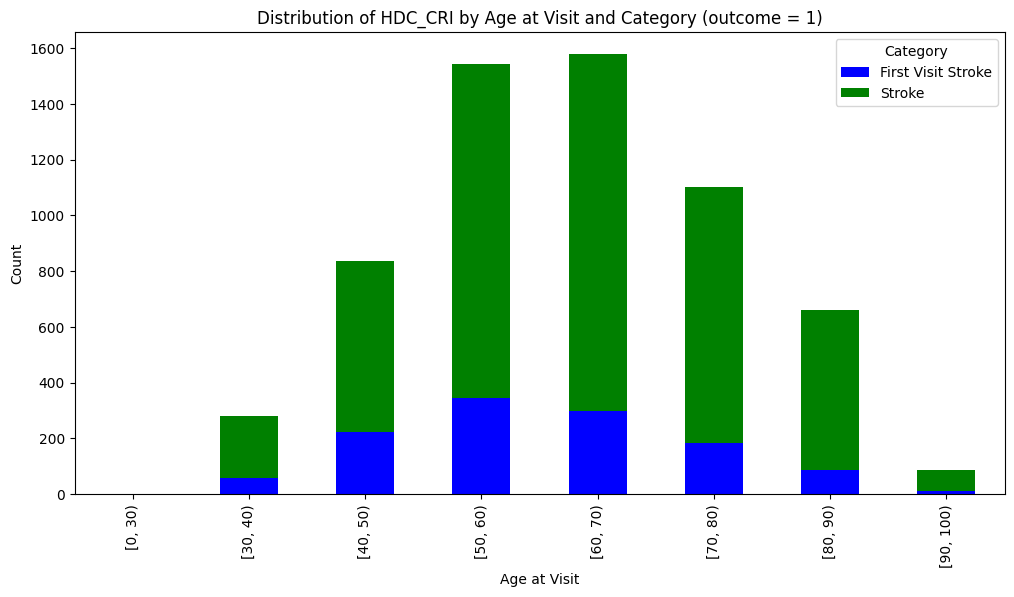

In [19]:
# Filtering data where outcome is 1
df_filtered = HDC_CRI[HDC_CRI['outcome'] == 1]

# Categorizing the data
df_filtered['category'] = df_filtered['final_cat'].apply(
    lambda x: 'First Visit Stroke' if x == 'First Visit Stroke' else 'Stroke'
)

# Binning age_at_visit (optional, you can modify the bins as needed)
df_filtered['age_bin'] = pd.cut(df_filtered['age_at_visit'], bins=[0, 30, 40, 50, 60, 70, 80, 90, 100], right=False)

# Counting occurrences by age_bin and category
count_data = df_filtered.groupby(['age_bin', 'category']).size().unstack(fill_value=0)

# Plotting the stacked bar chart
count_data.plot(kind='bar', stacked=True, figsize=(12, 6), color=['blue', 'green'])

plt.title('Distribution of HDC_CRI by Age at Visit and Category (outcome = 1)')
plt.xlabel('Age at Visit')
plt.ylabel('Count')
plt.legend(title='Category')
plt.show()

## Remove first visit stroke and Road accidence

In [ ]:
HDC_CRI[HDC_CRI['outcome'] == 1]['cid'].nunique()

In [ ]:
len(HDC_CRI[HDC_CRI['insurance_group'] == "Road Accident Fund"])

In [ ]:
HDC_CRI[HDC_CRI['insurance_group'] == "Road Accident Fund"]['cid'].nunique()

In [ ]:
len(HDC_CRI[HDC_CRI['final_cat'] == "First Visit Stroke"])

In [ ]:
HDC_CRI[HDC_CRI['final_cat'] == "First Visit Stroke"]['cid'].nunique()

In [ ]:
HDC_CRI = HDC_CRI[HDC_CRI['final_cat'] != "First Visit Stroke"]
HDC_CRI = HDC_CRI[HDC_CRI['insurance_group'] != "Road Accident Fund"]

In [ ]:
HDC_CRI[HDC_CRI['outcome'] == 1]['cid'].nunique()

In [ ]:
len(HDC_CRI)

In [ ]:
HDC_CRI['cid'].nunique()

In [ ]:
HDC_CRI['final_cat'].unique()

In [ ]:
HDC_CRI['insurance_group'].unique()

# Final imputation

In [ ]:
# HDC_NCD = pd.read_csv('output/HDC_NCD_final_imputed.csv', header=0)

In [ ]:
# Sort HDC_NCD by 'cid', 'date_serv', and all imputed columns
imputed_columns = ['imputed_smoke', 'imputed_alcohol', 'imputed_weight', 'imputed_height', 'imputed_waist_cm', 'imputed_bmi']
HDC_NCD.sort_values(by=['cid', 'date_serv'] + imputed_columns, inplace=True)

In [ ]:
HDC_NCD['date_serv'] = pd.to_datetime(HDC_NCD['date_serv'])
HDC_CRI['date_serv'] = pd.to_datetime(HDC_CRI['date_serv'])

In [ ]:
HDC_NCD['imputed_bmi'].unique()

In [ ]:
HDC_NCD = HDC_NCD[['cid', 'date_serv','imputed_smoke', 'imputed_alcohol', 'imputed_weight', 'imputed_height', 'imputed_waist_cm', 'imputed_bmi']]

In [ ]:
HDC_NCD

In [ ]:
HDC_CRI

In [ ]:
# Perform the merge operation to combine the DataFrames based on 'cid' and 'date_serv'
HDC_EX = pd.merge(HDC_NCD, HDC_CRI, on=['cid', 'date_serv'], how='inner')

In [ ]:
HDC_EX

In [ ]:
HDC_CRI = HDC_EX

## Impute BMI < 10 or > 50

In [ ]:
# Calculate median BMI for each cid, excluding out-of-range values
median_bmi_per_cid = HDC_CRI[(HDC_CRI['bmi'] >= 10) & (HDC_CRI['bmi'] <= 50)].groupby('cid')['bmi'].median()


In [ ]:
# Counter for the number of median imputations
median_imputations_count = 0

# Function to replace out-of-range BMI with the median for that cid
def replace_bmi_with_median(row):
    global median_imputations_count
    if row['bmi'] < 10 or row['bmi'] > 50:
        median_bmi = median_bmi_per_cid.get(row['cid'], np.nan)
        if pd.notna(median_bmi):
            median_imputations_count += 1
            row['bmi'] = median_bmi
            row['imputed_bmi'] = 'median impute'
    return row

# Apply the function to each row and update the DataFrame
HDC_CRI = HDC_CRI.apply(replace_bmi_with_median, axis=1)

print(f"Number of median BMI imputations: {median_imputations_count}")

In [ ]:
HDC_CRI[(HDC_CRI['bmi'] < 10) | (HDC_CRI['bmi'] > 50)]

In [ ]:
len(HDC_CRI[ HDC_CRI['imputed_bmi'] == 'median impute'])

In [ ]:
# Define the default waist and BMI values for each age group and gender category
# Male == 1, Female == 2
default_values = {
    '30 - 44': {'1.0': {'waist_cm': 83.8, 'bmi': 24.8},
                '2.0': {'waist_cm': 80.5, 'bmi': 25.9},
                'other': {'waist_cm': 82.1, 'bmi': 25.4}},
    '45 - 59': {'1.0': {'waist_cm': 84.7, 'bmi': 24.6},
                '2.0': {'waist_cm': 82.7, 'bmi': 26},
                'other': {'waist_cm': 83.7, 'bmi': 25.3}},
    '60 - 69': {'1.0': {'waist_cm': 83.8, 'bmi': 23.6},
                '2.0': {'waist_cm': 83.5, 'bmi': 25.3},
                'other': {'waist_cm': 83.6, 'bmi': 24.6}},
    '70 - 79': {'1.0': {'waist_cm': 82.8, 'bmi': 23.1},
                '2.0': {'waist_cm': 82.4, 'bmi': 24.3},
                'other': {'waist_cm': 82.6, 'bmi': 23.8}},
    '≥ 80': {'1.0': {'waist_cm': 80.5, 'bmi': 21.7},
             '2.0': {'waist_cm': 79.3, 'bmi': 22.1},
             'other': {'waist_cm': 79.8, 'bmi': 21.9}}
}

# A function to categorize age into groups
def categorize_age(age):
    if age < 45:
        return '30 - 44'
    elif age < 60:
        return '45 - 59'
    elif age < 70:
        return '60 - 69'
    elif age < 80:
        return '70 - 79'
    else:
        return '≥ 80'

# alculate age at each visit into age group
HDC_CRI['age_group'] = HDC_CRI['age_at_visit'].apply(categorize_age)

In [ ]:
# # Counter for the number of default value imputations
# default_imputations_count = 0

# # Function to replace remaining out-of-range BMIs with default values
# def replace_bmi_with_default(row):
#     global default_imputations_count
#     if row['bmi'] < 10 or row['bmi'] > 50:
#         sex_key = str(row['sex']) if str(row['sex']) in ['1.0', '2.0'] else 'other'
#         default_bmi = default_values[row['age_group']][sex_key]['bmi']
#         default_imputations_count += 1
#         return default_bmi
#     return row['bmi']

# # Apply the function
# HDC_CRI['bmi'] = HDC_CRI.apply(replace_bmi_with_default, axis=1)

# print(f"Number of default BMI imputations: {default_imputations_count}")
# # Number of default BMI imputations: 739

In [ ]:
# Count the number of null 'bmi' before imputation
null_count_before = HDC_CRI['bmi'].isnull().sum()

# Create a copy of the original dataframe to compare imputed values
original_HDC_CRI = HDC_CRI.copy()

# Vectorized imputation for 'bmi'
for age_group, age_group_values in default_values.items():
    for sex, values in age_group_values.items():
        # Create mask for current age_group and sex
        mask = (HDC_CRI['age_group'] == age_group) & (HDC_CRI['sex_category'] == sex)
        
        # Impute 'bmi'
        HDC_NCD.loc[mask & HDC_NCD['bmi'].isnull(), 'bmi'] = values['bmi']


# Count the number of null 'bmi' after imputation
null_count_after = HDC_CRI['bmi'].isnull().sum()

# Print the counts before and after imputation
print(f"Null 'bmi' count before imputation: {null_count_before}")
print(f"Null 'bmi' count after imputation: {null_count_after}")

# Null 'bmi' count before imputation: 4138913
# Null 'bmi' count after imputation: 0



In [ ]:
# Update the 'bmi' column to 'Fill NHES' for rows where NA values were filled
HDC_CRI['imputed_bmi'] = np.where(
    (original_HDC_CRI['bmi'].isnull()) & (HDC_CRI['bmi'].notnull()), 
    'Fill NHES', 
    HDC_CRI['imputed_bmi']
)

In [ ]:
HDC_CRI[(HDC_CRI['bmi'] < 10) | (HDC_CRI['bmi'] > 50)]

## Summary Imputation

In [ ]:
# List of imputed columns
imputed_columns = ['imputed_smoke', 'imputed_alcohol', 'imputed_weight', 'imputed_height', 'imputed_waist_cm', 'imputed_bmi']

# Function to summarize the unique values in each column
def summarize_imputations(df, columns):
    summary = {}
    for col in columns:
        unique_values = df[col].dropna().unique()
        col_summary = []
        for val in unique_values:
            rows_count = df[df[col] == val].shape[0]
            unique_cid_count = df[df[col] == val]['cid'].nunique()
            col_summary.append({'value': val, 'rows': rows_count, 'unique_cid': unique_cid_count})
        summary[col] = col_summary
    return summary

# Summarize imputations
imputation_summary = summarize_imputations(HDC_CRI, imputed_columns)

imputation_summary

In [ ]:
# Optionally convert the summary to a DataFrame for better visualization
summary_df = pd.DataFrame([(col, item['value'], item['rows'], item['unique_cid'])
                           for col, summary in imputation_summary.items()
                           for item in summary],
                          columns=['Column', 'Value', 'Rows', 'Unique cid'])

summary_df

## Change category name

In [ ]:
# Replace values in 'occupation_category'
occupation_replacements = {
    'Blue-Collar Jobs': 'Manual worker',
    'Service Industry': 'Service worker',
    'White-Collar Jobs': 'Office worker'
}

HDC_CRI['occupation_category'] = HDC_CRI['occupation_category'].replace(occupation_replacements)

# Replace values in 'education'
education_replacements = {
    'Low Education Level': 'Lower Level',
    'Mid-Level Education': 'Middle Level',
    'Higher Education': 'Higher Level'
}

HDC_CRI['education_category'] = HDC_CRI['education_category'].replace(education_replacements)


In [ ]:
HDC_CRI

In [ ]:
HDC_CRI['occupation_category'].unique()

In [ ]:
HDC_CRI['education_category'].unique()

## Backup after Final Imputation

In [ ]:
# HDC_CRI.to_csv('output/HDC_CRI_Final_Impute.csv', index=False)

In [3]:
HDC_CRI = pd.read_csv('output/HDC_CRI_Final_Impute.csv', header=0)

/var/folders/k4/b693sswd65n0k8hpy9xxfrm40000gq/T/ipykernel_5508/66926137.py:1: DtypeWarning: Columns (2,3,6,13,25,28,31,40,41,46,47,50,52,60,64,67) have mixed types. Specify dtype option on import or set low_memory=False.
  HDC_CRI = pd.read_csv('output/HDC_CRI_Final_Impute.csv', header=0)


# Visualization

## HT Category

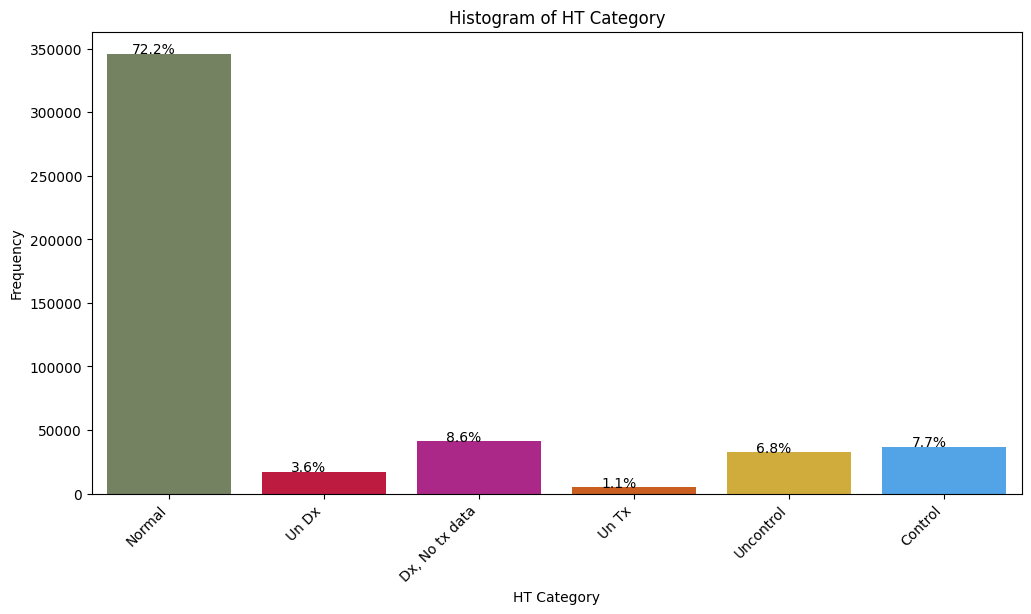

Total unique cids: 479589


In [4]:
# Filter out duplicates
filtered_data = HDC_CRI.drop_duplicates(subset=['cid'])


# Create the plot with specified order and palette for x-axis
category_order = ['Normal', 'Un Dx', 'Dx, No tx data', 'Un Tx', 'Uncontrol', 'Control']
palette_colors = ["#76885B" ,"#D80032", "#C21292", "#E55604", "#E9B824", "#39A7FF"]

plt.figure(figsize=(12, 6))
ax = sns.countplot(data=filtered_data, x='final_cat', order=category_order, palette=palette_colors)
plt.title('Histogram of HT Category')
plt.xlabel('HT Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate x-labels for better visibility

# Calculate the percentages and annotate the bars
total = len(filtered_data['final_cat'])
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2 - 0.1
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x, y), ha='center')

plt.show()

# Print the total number of unique cids
print("Total unique cids:", len(filtered_data['final_cat']))

## BP Use most frequent data

In [ ]:
# Calculate the most frequent value for each column grouped by 'cid'
tqdm.pandas()

def mode_or_none(x):
    return x.mode().iloc[0] if not x.mode().empty else None

most_frequent = HDC_CRI.groupby('cid')[[
    'occupation_category', 'education_category', 'sex_category', 'insurance_group', 'hospcode_category', 'age_at_visit'
]].progress_apply(lambda x: x.agg(mode_or_none)).reset_index()


In [ ]:
# Group by 'cid' and calculate the median for 'sbp' and 'dbp'
HDC_mBP = HDC_CRI.groupby('cid')[['sbp', 'dbp']].median().reset_index()
HDC_mBP = HDC_mBP.rename(columns={'sbp': 'median_sbp', 'dbp': 'median_dbp'})

In [ ]:
# Merge with the median values
HDC_mBP = pd.merge(HDC_mBP, most_frequent, on='cid', how='left')
HDC_mBP

In [ ]:
HDC_mBP[HDC_mBP.duplicated(subset=['cid'], keep='first')]

In [ ]:
# Reorder categories
ordered_categories = ['Lower Level', 'Middle Level', 'Higher Level', 'Unknown']
HDC_mBP['education_category'] = pd.Categorical(HDC_mBP['education_category'], categories=ordered_categories, ordered=True)


# BP Visualize

## Median Age

In [ ]:
# Calculate median age for each cid
median_age_per_cid = HDC_CRI.groupby('cid')['age_at_visit'].median().reset_index()
median_age_per_cid.rename(columns={'age_at_visit': 'median_age'}, inplace=True)

# Merge the median_age back to the original DataFrame
HDC_CRI = HDC_CRI.merge(median_age_per_cid, on='cid', how='left')

In [ ]:
HDC_CRI

In [ ]:

# Plotting the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(median_age_per_cid['cid'], median_age_per_cid['median_age'], alpha=0.6)

# Adding titles and labels
plt.title('Median Age of Patients by CID')
plt.xlabel('CID')
plt.ylabel('Median Age')

# Optionally, you can add grid for better readability
plt.grid(True)

# Show the plot
plt.show()


## Sex plot

In [ ]:
# Sex with Median SBP
plt.figure(figsize=(10, 6))
sns.boxplot(x='sex_category', y='median_sbp', data=HDC_mBP)
plt.title('Boxplot of median_sbp by Sex')
plt.xlabel('sex_category')
plt.ylabel('median_sbp')
plt.show()

print("Total visits:", len(HDC_mBP))

In [ ]:
# Group the data by 'sex_category' and collect the 'median_sbp' in lists
groups = HDC_mBP.groupby('sex_category')['median_sbp'].apply(list)

# Perform Kruskal-Wallis test
h_stat, p_value = kruskal(*groups)

print(f"H-statistic: {h_stat}")
print(f"P-value: {p_value}")

# Interpret the result
if p_value < 0.05:
    print("There is a statistically significant difference between the groups.")
else:
    print("There is no statistically significant difference between the groups.")

## Education plot

In [ ]:
# Education with Median SBP
plt.figure(figsize=(10, 6))
sns.boxplot(x='education_category', y='median_sbp', data=HDC_mBP)
plt.title('Boxplot of median_sbp by Education')
plt.xlabel('education_category')
plt.ylabel('median_sbp')
plt.show()

In [ ]:
# Assuming HDC_mBP is your DataFrame
# Group the data by 'education_category' and collect the 'median_sbp' in lists
groups = HDC_mBP.groupby('education_category')['median_sbp'].apply(list)

# Perform Kruskal-Wallis test
h_stat, p_value = kruskal(*groups)

print(f"H-statistic: {h_stat}")
print(f"P-value: {p_value}")

# Interpret the result
if p_value < 0.05:
    print("There is a statistically significant difference between the groups.")
else:
    print("There is no statistically significant difference between the groups.")

## Occupation plot

In [ ]:

plt.figure(figsize=(10, 6))
sns.boxplot(x='occupation_category', y='median_sbp', data=HDC_mBP, order=[
   'Manual worker', 'Healthcare Workers', 'Service worker', 'Office worker', 'Unemployed', 'Unknown'
])
plt.title('Boxplot of median_sbp by occupation')
plt.xlabel('occupation_category')
plt.ylabel('median_sbp')
plt.show()


In [ ]:
# Assuming HDC_mBP is your DataFrame
# Group the data by 'occupation_category' and collect the 'median_sbp' in lists
groups = HDC_mBP.groupby('occupation_category')['median_sbp'].apply(list)

# Perform Kruskal-Wallis test
h_stat, p_value = kruskal(*groups)

print(f"H-statistic: {h_stat}")
print(f"P-value: {p_value}")

# Interpret the result
if p_value < 0.05:
    print("There is a statistically significant difference between the groups.")
else:
    print("There is no statistically significant difference between the groups.")


# Time of Serv Date

In [ ]:
HDC_CRI

In [ ]:
# Convert 'date_serv' to datetime if it's not already
HDC_CRI['date_serv'] = pd.to_datetime(HDC_CRI['date_serv'])


In [ ]:
# Since the 'visits' column is not available, we will count the occurrences of 'date_serv' for each week.

# First, we'll recreate the 'year_week' and 'year_month' columns based on 'date_serv'.
HDC_CRI['year_week'] = HDC_CRI['date_serv'].dt.strftime('%Y-%U')
HDC_CRI['year_month'] = HDC_CRI['date_serv'].dt.strftime('%Y-%m')

# Now, we'll count the number of rows for each 'year_week', which represents the weekly visit count.
weekly_visit_counts = HDC_CRI.groupby('year_week').size().reset_index(name='visit_count')

# Determine the first week of each month to place the month-year label
first_week_of_month = HDC_CRI.groupby('year_month')['year_week'].first().reset_index()

# Merge the weekly visit counts with the first week of each month to get the month-year labels
weekly_visits_labeled = weekly_visit_counts.merge(first_week_of_month, on='year_week', how='left')

# Replace NaN values in 'year_month' with the previous non-NaN value for continuous labeling
weekly_visits_labeled['year_month'] = weekly_visits_labeled['year_month'].fillna(method='ffill')

# Filter out only rows where 'year_month' column is not NaN which corresponds to the first week of each month
monthly_labels = weekly_visits_labeled.dropna(subset=['year_month'])

# Now we can plot the histogram with the visit counts by week, labeled as month-year.
plt.figure(figsize=(18, 6))
ax = sns.barplot(data=monthly_labels, x='year_week', y='visit_count', ci=None)
plt.title('Sum of Visits by Week Number')
plt.xlabel('Year-Week Number')
plt.ylabel('Visit Count')

# Set the custom x-ticks and labels for the first week of each month
ax.set_xticks(range(len(monthly_labels['year_week'])))
ax.set_xticklabels(monthly_labels['year_month'], rotation=90)

plt.tight_layout()  # Adjust layout to fit the rotated x-tick labels
plt.show()

print("Total visits:", len(HDC_CRI))

In [ ]:
# To display visits by year-month, we'll group by 'year_month' and count the occurrences of 'date_serv'.

# Group by 'year_month' to get monthly visit counts
monthly_visit_counts = HDC_CRI.groupby('year_month').size().reset_index(name='visit_count')

# Plotting the bar chart for visits by year-month
plt.figure(figsize=(18, 6))
ax = sns.barplot(data=monthly_visit_counts, x='year_month', y='visit_count', ci=None)
plt.title('Visits by Year-Month')
plt.xlabel('Year-Month')
plt.ylabel('Visit Count')

# Rotate x-tick labels for better readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()  # Adjust layout to fit the rotated x-tick labels
plt.show()

print("Total visits:", len(HDC_CRI))

# Day of week

In [ ]:
HDC_CRI['Day_of_Week'] = HDC_CRI['date_serv'].dt.day_name()
HDC_CRI

In [ ]:

# Saraburi hospital visit
sns.countplot(data=HDC_CRI, x='Day_of_Week', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Number of Visits by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Visits')
plt.show()

In [ ]:
# Group by 'cid' and calculate the frequency
cid_frequency = HDC_CRI.groupby('cid').size()

# Calculate the median, Q1, and Q3 of the frequency
median = cid_frequency.median()
q1 = cid_frequency.quantile(0.25)
q3 = cid_frequency.quantile(0.75)

print("Median number of Visit:", median)
print("Q1 number of Visit:", q1)
print("Q3 number of Visit:", q3)

# Plot

## Median Age

In [ ]:
# Set the style of seaborn
sns.set(style="darkgrid")

# Assuming median_age_per_cid is your DataFrame with 'cid' and 'median_age'
# Plotting the histogram with seaborn's distplot, which provides a smoother density estimate
plt.figure(figsize=(10, 6))
sns.histplot(median_age_per_cid['median_age'], bins=30, color="skyblue", edgecolor='black')

# Adding titles and labels
plt.title('Median age from all visits of all patients', fontsize=16)
plt.xlabel('Median Age', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Show the plot
plt.show()

## Education

In [ ]:
# Filter out duplicates
filtered_data = HDC_CRI.drop_duplicates(subset=['cid'])

# Create the plot with specified order and palette for x-axis
category_order = ['Lower Level', 'Middle Level', 'Higher Level', 'Unknown']

# Create the plot
plt.figure(figsize=(12, 6))
sns.countplot(data=filtered_data, x='education_category', order=category_order)
plt.title('Histogram of Education Group')
plt.xlabel('Education Level')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate x-labels for better visibility
plt.show()

print(len(HDC_CRI.drop_duplicates(subset=['cid'])['education_category']))

## Sex

In [ ]:
# Filter out duplicates
filtered_data = HDC_CRI.drop_duplicates(subset=['cid'])

# Create the plot
plt.figure(figsize=(12, 6))
sns.countplot(data=filtered_data, x='sex_category')
plt.title('Histogram of Sex Group')
plt.xlabel('Sex')
plt.ylabel('Frequency')
# plt.xticks(rotation=45, ha='right')  # Rotate x-labels for better visibility
plt.show()

print(len(HDC_CRI.drop_duplicates(subset=['cid'])['sex_category']))

## Occupation

In [ ]:
# Filter out duplicates
filtered_data = HDC_CRI.drop_duplicates(subset=['cid'])

# Create the plot
plt.figure(figsize=(12, 6))
sns.countplot(data=filtered_data, x='occupation_category')
plt.title('Histogram of Occupation')
plt.xlabel('Occupation')
plt.ylabel('Frequency')
# plt.xticks(rotation=45, ha='right')  # Rotate x-labels for better visibility
plt.show()

print(len(HDC_CRI.drop_duplicates(subset=['cid'])['occupation_category']))


## Type Area

In [ ]:
# Get the order of categories based on their frequency, and move 'Unknown' to the far right
category_order = HDC_CRI['typearea'].value_counts().index.tolist()
if 'Unknown' in category_order:
    category_order.remove('Unknown')
    category_order.append('Unknown')
    
# Create the plot
plt.figure(figsize=(12, 6))
sns.countplot(data=HDC_CRI, x='typearea', order=category_order)
plt.title('Histogram of Type Area')
plt.xlabel('Type Area')
plt.ylabel('Frequency')
# plt.xticks(rotation=45, ha='right')  # Rotate x-labels for better visibility


plt.show()

print(len(HDC_CRI['typearea']))


## Insurance Type

In [ ]:
# Get the order of categories based on their frequency, and move 'Unknown' to the far right
category_order = HDC_CRI['insurance_group'].value_counts().index.tolist()
if 'Unknown' in category_order:
    category_order.remove('Unknown')
    category_order.append('Unknown')

# Create the plot
plt.figure(figsize=(12, 6))
sns.countplot(data=HDC_CRI, x='insurance_group', order=category_order)
plt.title('Histogram of Payment Group')
plt.xlabel('Payment Group')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

print(len(HDC_CRI['insurance_group']))

## Hospital code

In [ ]:
# Get the order of categories based on their frequency
category_order = HDC_CRI['hospcode_category'].value_counts().sort_values(ascending=False).index.tolist()

# Create the plot
plt.figure(figsize=(12, 6))
sns.countplot(data=HDC_CRI, x='hospcode_category', order=category_order)
plt.title('Histogram of Hospital Type')
plt.xlabel('Hospital Type')
plt.ylabel('Frequency')
plt.xticks(rotation=20, ha='right', fontsize=12)
plt.show()

print(len(HDC_CRI['hospcode_category']))

## BMI

In [ ]:
# Create the histogram with 1 to 2 interval bins
bin_edges = np.arange(0, 51, 1)  # Bin edges from 0 to 50 with a step of 1

plt.hist(HDC_CRI['bmi'], bins=bin_edges, color="lightblue", edgecolor="black")
plt.title('BMI Distribution')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.xlim(0, 50)  # Limiting x-axis from 0 to 50

# Display the plot
plt.show()

In [ ]:
# Create the histogram with 1 to 2 interval bins
bin_edges = np.arange(0, 300, 1)  # Bin edges from 0 to 300 with a step of 1

plt.hist(HDC_CRI['weight'], bins=bin_edges, color="lightblue", edgecolor="black")
plt.title('weight Distribution')
plt.xlabel('weight')
plt.ylabel('Frequency')
plt.xlim(0, 200)  

# Display the plot
plt.show()

In [ ]:
# Create the histogram with 1 to 2 interval bins
bin_edges = np.arange(0, 300, 1)  

plt.hist(HDC_CRI['height'], bins=bin_edges, color="lightblue", edgecolor="black")
plt.title('height Distribution')
plt.xlabel('height')
plt.ylabel('Frequency')
plt.xlim(0, 200)  

# Display the plot
plt.show()

In [ ]:
# Create the histogram with 1 to 2 interval bins
bin_edges = np.arange(0, 300, 1)  

plt.hist(HDC_CRI['waist_cm'], bins=bin_edges, color="yellow", edgecolor="black")
plt.title('waist(cm) Distribution')
plt.xlabel('waist(cm)')
plt.ylabel('Frequency')
plt.xlim(0, 200)  

# Display the plot
plt.show()

# First Visit Stroke

In [ ]:
first_visit_stroke = HDC_CRI[HDC_CRI['final_cat'] == 'First Visit Stroke']
first_visit_stroke

In [ ]:
first_visit_stroke['cid'].nunique()

In [ ]:
# Set the style of seaborn
sns.set(style="darkgrid")

# Assuming median_age_per_cid is your DataFrame with 'cid' and 'median_age'
# Plotting the histogram with seaborn's distplot, which provides a smoother density estimate
plt.figure(figsize=(10, 6))
sns.histplot(first_visit_stroke['median_age'], bins=30, color="skyblue", edgecolor='black')

# Adding titles and labels
plt.title('Median age from all visits of first-visit stroke patients', fontsize=16)
plt.xlabel('Median Age', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Show the plot
plt.show()

In [ ]:
first_visit_stroke

## Visualize total time

In [ ]:
# Plotting the histogram
plt.hist(HDC_CRI['total_years'], bins=30, edgecolor='black')

# Adding titles and labels
plt.title('Histogram of patients\' survival time')
plt.xlabel('Total Years')
plt.ylabel('Frequency')

# Show the plot
plt.show()


In [ ]:
# Filter the DataFrame for patients who had a stroke
stroke_patients = HDC_CRI[HDC_CRI['outcome'] == 1]

# Plotting the histogram for total_years of patients who had a stroke
plt.hist(stroke_patients['total_years'], bins=30, color='red', edgecolor='black')

# Adding titles and labels
plt.title('Histogram of Stroke Patients\' survival time')
plt.xlabel('Total Years')
plt.ylabel('Frequency')

# Show the plot
plt.show()


In [ ]:
# Filter the DataFrame for patients who not had a stroke
normal_patients = HDC_CRI[HDC_CRI['outcome'] == 0]

# Plotting the histogram for total_years of patients who had a stroke
plt.hist(normal_patients['total_years'], bins=30, color='green', edgecolor='black')

# Adding titles and labels
plt.title('Histogram of non-stroke patients\' survival time')
plt.xlabel('Total Years')
plt.ylabel('Frequency')

# Show the plot
plt.show()


In [ ]:
# Plotting boxplots
plt.figure(figsize=(10, 6))
sns.boxplot(x='outcome', y='total_years', data=HDC_CRI)

# Adding titles and labels
plt.title('Comparison of Total Years Between Stroke and Non-Stroke Patients')
plt.xlabel('Patient Type')
plt.ylabel('Total Years')

# Show the plot
plt.show()


# Survival Analysis

In [ ]:
HDC_CRI

In [ ]:
# Convert columns to datetime format
HDC_CRI['date_serv'] = pd.to_datetime(HDC_CRI['date_serv'], errors='raise')
HDC_CRI['birth'] = pd.to_datetime(HDC_CRI['birth'], errors='raise')

In [ ]:
HDC_CRI['First_HT_Diagnosis_Date'] = pd.to_datetime(HDC_CRI['First_HT_Diagnosis_Date'], errors='raise')
HDC_CRI['First_Treatment_Date'] = pd.to_datetime(HDC_CRI['First_Treatment_Date'], errors='raise')
HDC_CRI['DM_date'] = pd.to_datetime(HDC_CRI['DM_date'], errors='raise')
HDC_CRI['CKD_date'] = pd.to_datetime(HDC_CRI['CKD_date'], errors='raise')
HDC_CRI['CVD_date'] = pd.to_datetime(HDC_CRI['CVD_date'], errors='raise')
HDC_CRI['TOD_date'] = pd.to_datetime(HDC_CRI['TOD_date'], errors='raise')
HDC_CRI['date_gl_2019'] = pd.to_datetime(HDC_CRI['date_gl_2019'], errors='raise')

In [ ]:
HDC_CRI.info(show_counts=True)

## COX

In [ ]:
HDC_cox = HDC_CRI[['cid','date_serv', 'sex_category','occupation_category','education_category', 'insurance_group', 'hospcode_category','smoke','alcohol','weight', 'height','waist_cm','bmi', 'sbp', 'dbp','age_at_visit','median_age' ,'total_years', 'start_age', 'stop_age', 'outcome', 'final_cat' ]]
HDC_cox

In [ ]:
HDC_cox.info(show_counts=True)

In [ ]:
HDC_cox['cid'].nunique()

In [ ]:
HDC_cox[HDC_cox['bmi'] == 0]

In [ ]:
# Find the earliest and latest 'date_serv'
earliest_date = HDC_cox['date_serv'].min()
latest_date = HDC_cox['date_serv'].max()

print(f"Earliest date_serv: {earliest_date}")
print(f"Latest date_serv: {latest_date}")

In [ ]:
HDC_cox[HDC_cox.duplicated(subset=['cid', 'date_serv'], keep=False)]

## Date as time scale

In [ ]:
HDC_cox = HDC_cox.sort_values(by=['cid', 'date_serv'])

# Calculate the first visit date for each patient
HDC_cox['first_visit'] = HDC_cox.groupby('cid')['date_serv'].transform('min')


# Initialize empty columns for start_date and stop_date
HDC_cox['start_sur'] = None
HDC_cox['stop_sur'] = (HDC_cox['date_serv'] - HDC_cox['first_visit']).dt.days

# Apply the function with a progress bar
for cid, group in tqdm(HDC_cox.groupby('cid'), desc="Processing"):
    start_dates = group['stop_sur'].shift(1)
    start_dates.iloc[0] = group['stop_sur'].iloc[0]  # Fill NA for the first row in each group
    HDC_cox.loc[group.index, 'start_sur'] = start_dates

# Reset index
HDC_cox.reset_index(drop=True, inplace=True)


In [ ]:
HDC_cox

In [ ]:
HDC_cox.to_csv('output/HDC_cox.csv', index=False)

In [ ]:
HDC_cox.groupby('occupation_category')['cid'].nunique()

In [ ]:
HDC_cox.groupby('sex_category')['cid'].nunique()

In [ ]:
# Selecting only the columns you need
df_tte = HDC_cox[['cid','sex_category','occupation_category','education_category',
                    'insurance_group', 'hospcode_category',
                    'smoke','alcohol','weight', 'height','waist_cm','bmi', 'final_cat', 
                    'sbp', 'dbp','age_at_visit','median_age' ,'total_years', 'start_age', 'stop_age','start_sur', 'stop_sur', 'outcome' ]]


In [ ]:
df_tte[df_tte['outcome']==1]

In [ ]:
df_tte.to_csv('output/HDC_tte2.csv', index=False)

# Cluster bar chart

In [ ]:
# Features to consider for aggregation
features = ['cid', 'final_cat', 'sex_category']  # Add more demographic variables if needed

# Aggregate data at the 'cid' level using mode (most frequent value)
aggregated_data = HDC_cox[features].groupby('cid').agg(lambda x: x.mode()[0] if not x.mode().empty else "Unknown").reset_index()

# Create a new DataFrame for the count of each 'sex_category' within each 'final_cat'
cluster_counts = aggregated_data.groupby(['final_cat', 'sex_category']).size().reset_index(name='counts')

# Plotting the clustered bar chart
plt.figure(figsize=(12, 8))
sns.barplot(x='final_cat', y='counts', hue='sex_category', data=cluster_counts)

plt.title('Clustered Bar Chart of Sex Categories across Final Categories (One row per CID)')
plt.xlabel('Final Category')
plt.ylabel('Counts')
plt.legend(title='Sex Category')
plt.show()


# Aggregrate data

In [ ]:
# HDC_cox = pd.read_csv('output/HDC_cox.csv', header=0)

In [ ]:
HDC_cox

In [ ]:
# Aggregating the data
aggregated_data = HDC_cox.groupby('cid').agg({
    'sex_category': lambda x: x.mode()[0] if not x.mode().empty else "Unknown",
    'occupation_category': lambda x: x.mode()[0] if not x.mode().empty else "Unknown",
    'education_category': lambda x: x.mode()[0] if not x.mode().empty else "Unknown",
    'smoke': lambda x: x.mode()[0] if not x.mode().empty else "Unknown",
    'alcohol': lambda x: x.mode()[0] if not x.mode().empty else "Unknown",
    'insurance_group': lambda x: x.mode()[0] if not x.mode().empty else "Unknown",
    'hospcode_category': lambda x: x.mode()[0] if not x.mode().empty else "Unknown",
    'weight': 'median',
    'height': 'median',
    'waist_cm': 'median',
    'bmi': 'median',
    'median_age': 'median',
    'final_cat': lambda x: x.mode()[0] if not x.mode().empty else "Unknown"
}).reset_index()


In [ ]:
# Determine the outcome for each cid based on HDC_cox
outcome_per_cid = HDC_cox.groupby('cid')['outcome'].max().reset_index()

# Merge this outcome with aggregated_data
aggregated_data = aggregated_data.merge(outcome_per_cid, on='cid', how='left')


In [ ]:
aggregated_data

In [ ]:
aggregated_data.info(show_counts=True)

In [ ]:
aggregated_data.to_csv('output/aggregated_cid.csv', index=False)

# Show attack rate tables

In [ ]:
# aggregated_data = pd.read_csv('output/aggregated_cid.csv', header=0)

In [ ]:
aggregated_data

In [ ]:
aggregated_data[aggregated_data['final_cat'] == "First Visit Stroke"]

In [ ]:
# Define the variables of interest
variables = ['sex_category', 'occupation_category', 'education_category', 'final_cat', "insurance_group", "hospcode_category", 'smoke', 'alcohol']

# Loop to create tables for each variable from aggregated_data
results_agg = []
for var in variables:
    # Count the occurrence of stroke and not stroke per category
    summary_agg = aggregated_data.groupby(var)['outcome'].value_counts().unstack(fill_value=0)
    summary_agg.columns = ['Not had stroke', 'Had Stroke']
    # Calculate attack rate
    summary_agg['Attack rate'] = ((summary_agg['Had Stroke'] / (summary_agg['Had Stroke'] + summary_agg['Not had stroke'])) * 100).round(2).astype(str) + '%'
    # Reset index for display
    summary_agg = summary_agg.reset_index()
    results_agg.append((var, summary_agg))

# Display results for each variable from aggregated_data
for var, table in results_agg:
    print(f"Table for {var}:\n", table, "\n")

In [ ]:
!jupyter nbconvert --to html HT_stroke_research.ipynb

# Clustering

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Features to be used for clustering
features = ['sex_category', 'occupation_category', 'education_category', 'smoke', 'alcohol', 'cid']

# Encoding categorical variables
X = pd.get_dummies(aggregated_data, drop_first=True)

# Standard scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Clustering
kmeans = KMeans(n_clusters=len(aggregated_data['cid'].unique()), random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# You can now add the cluster labels back to the aggregated data if needed
aggregated_data['Cluster'] = clusters


In [ ]:
"""
In this script:

We first one-hot encode 'sex_category' and 'occupation_category'.
Perform KMeans clustering on the encoded features.
Map each cluster to the most frequent 'final_cat' in that cluster.
Use a scatter plot where each point represents a patient, colored and styled by the cluster (i.e., 'final_cat') they belong to.
"""
# Encode the categorical features
X_cat = pd.get_dummies(HDC_cox[['sex_category', 'occupation_category']], drop_first=True)

# Clustering
kmeans = KMeans(n_clusters=len(labels.unique()), random_state=42)
clusters = kmeans.fit_predict(X_cat)

# Add clusters to the original DataFrame
HDC_cox['Cluster'] = clusters

# Map cluster numbers to 'final_cat' names
cluster_to_final_cat = HDC_cox.groupby('Cluster')['final_cat'].agg(lambda x: x.mode()[0]).to_dict()

# Rename clusters in the DataFrame
HDC_cox['Cluster_Name'] = HDC_cox['Cluster'].map(cluster_to_final_cat)

# Categorical scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=HDC_cox, x='sex_category', y='occupation_category', hue='Cluster_Name', style='Cluster_Name', s=100)
plt.title('Cluster Visualization with Sex and Occupation Categories')
plt.xlabel('Sex Category')
plt.ylabel('Occupation Category')
plt.legend(title='Cluster (Final Cat)')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Perform Principal Component Analysis (PCA) for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plotting the clusters
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', label=labels.unique())
plt.title('Cluster Visualization after PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()


In [ ]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler


# Assuming you've already encoded your categorical variables and standardized them
X_encoded = pd.get_dummies(HDC_cox[['sex_category', 'occupation_category', 'education_category']], drop_first=True)
X_standardized = StandardScaler().fit_transform(X_encoded)

# t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_standardized)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=HDC_cox['final_cat'].astype('category').cat.codes, cmap='viridis')
plt.title('t-SNE Visualization of Clusters')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.colorbar()
plt.show()


In [ ]:
# Calculate counts for each combination
counts = aggregated_data.groupby(['median_age', 'education_category', 'final_cat']).size().reset_index(name='counts')

# Create the bubble plot
plt.figure(figsize=(12, 8))
bubble_plot = sns.scatterplot(data=counts, x='median_age', y='education_category', size='counts', hue='final_cat', sizes=(20, 2000), alpha=0.7, legend='full')

plt.title('Bubble Plot of Median Age and Education Categories by Final Category')
plt.xlabel('Median Age')
plt.ylabel('Education Category')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.legend(title='Final Category', bbox_to_anchor=(1.05, 1), loc=2)
bubble_plot.figure.tight_layout()
plt.show()


# Forest plot

In [ ]:
# Data preparation
categories = [
    ("Undiagnosed", [8.2, 7.2, 6.2, 6.3, 15.9], [5.6, 5.0, 4.7, 4.7, 8.3], [12.1, 10.3, 8.2, 8.5, 30.5]),
    ("Diagnosed, No drug data", [15.2, 13.1, 8.2, 5.0, 6.0], [10.3, 9.2, 6.5, 3.9, 3.4], [22.5, 18.6, 10.2, 6.3, 10.4]),
    ("Untreated", [10.1, 8.0, 5.0, 4.7, 7.2], [6.9, 5.6, 3.2, 3.1, 3.1], [14.7, 11.4, 7.9, 7.1, 16.8]),
    ("Uncontrolled", [15.5, 12.6, 8.8, 5.5, 9.2], [10.2, 8.7, 7.1, 4.4, 5.4], [23.5, 18.2, 10.9, 6.9, 15.8]),
    ("Controlled", [4.3, 4.3, 3.3, 2.4, 3.0], [2.9, 3.0, 2.6, 1.9, 1.7], [6.4, 6.1, 4.3, 3.1, 5.5])
]
age_groups = ["30-44", "45-59", "60-69", "70-84", "≥ 85"]

fig, ax = plt.subplots(figsize=(10, 8))

# Plot data
for i, (category, hr, lower_ci, upper_ci) in enumerate(categories):
    positions = np.arange(len(hr)) + i * 0.2
    ax.errorbar(hr, positions, xerr=[np.array(hr) - np.array(lower_ci), np.array(upper_ci) - np.array(hr)], fmt='o', label=category, capsize=5)

# Formatting
ax.axvline(1, color='grey', linestyle='--')
ax.set_yticks(np.arange(len(age_groups)) + 0.4)
ax.set_yticklabels(age_groups)
ax.set_xlabel("Hazard Ratio")
ax.set_title("Forest Plot of HT Status by Age Group")
ax.legend()

plt.grid(True, axis='x', linestyle='--', linewidth=0.7)
plt.tight_layout()

# Save and display the plot
plt.savefig("/mnt/data/forest_plot.png")
plt.show()


In [ ]:
# Data preparation for the second forest plot
categories_sex = [
    ("Male", [1.5, 1.8, 1.6, 1.5, 1.1], [1.3, 1.6, 1.4, 1.4, 0.9], [1.7, 1.9, 1.8, 1.7, 1.4])
]

categories_bmi = [
    ("BMI", [0.962, 0.949, 0.975, 0.977, 1.029], [0.953, 0.944, 0.958, 0.959, 0.997], [0.972, 0.953, 0.992, 0.996, 1.063])
]

categories_bp = [
    ("Systolic BP", [1.039, 1.041, 1.039, 1.040, 1.038], [1.037, 1.040, 1.037, 1.038, 1.034], [1.042, 1.042, 1.041, 1.042, 1.042])
]

age_groups_sex_bmi_bp = ["30-44", "45-59", "60-69", "70-84", "≥ 85"]

fig, ax = plt.subplots(3, 1, figsize=(10, 15))

# Plot data for Sex
for i, (category, hr, lower_ci, upper_ci) in enumerate(categories_sex):
    positions = np.arange(len(hr))
    ax[0].errorbar(hr, positions, xerr=[np.array(hr) - np.array(lower_ci), np.array(upper_ci) - np.array(hr)], fmt='o', label=category, capsize=5)

# Plot data for BMI
for i, (category, hr, lower_ci, upper_ci) in enumerate(categories_bmi):
    positions = np.arange(len(hr))
    ax[1].errorbar(hr, positions, xerr=[np.array(hr) - np.array(lower_ci), np.array(upper_ci) - np.array(hr)], fmt='o', label=category, capsize=5)

# Plot data for Systolic BP
for i, (category, hr, lower_ci, upper_ci) in enumerate(categories_bp):
    positions = np.arange(len(hr))
    ax[2].errorbar(hr, positions, xerr=[np.array(hr) - np.array(lower_ci), np.array(upper_ci) - np.array(hr)], fmt='o', label=category, capsize=5)

# Formatting for Sex
ax[0].axvline(1, color='grey', linestyle='--')
ax[0].set_yticks(np.arange(len(age_groups_sex_bmi_bp)))
ax[0].set_yticklabels(age_groups_sex_bmi_bp)
ax[0].set_xlabel("Hazard Ratio")
ax[0].set_title("Forest Plot of Sex by Age Group")
ax[0].legend()

# Formatting for BMI
ax[1].axvline(1, color='grey', linestyle='--')
ax[1].set_yticks(np.arange(len(age_groups_sex_bmi_bp)))
ax[1].set_yticklabels(age_groups_sex_bmi_bp)
ax[1].set_xlabel("Hazard Ratio")
ax[1].set_title("Forest Plot of BMI by Age Group")
ax[1].legend()

# Formatting for Systolic BP
ax[2].axvline(1, color='grey', linestyle='--')
ax[2].set_yticks(np.arange(len(age_groups_sex_bmi_bp)))
ax[2].set_yticklabels(age_groups_sex_bmi_bp)
ax[2].set_xlabel("Hazard Ratio")
ax[2].set_title("Forest Plot of Systolic BP by Age Group")
ax[2].legend()

plt.grid(True, axis='x', linestyle='--', linewidth=0.7)
plt.tight_layout()

# Save and display the plot
plt.savefig("/mnt/data/forest_plot_sex_bmi_bp.png")
plt.show()


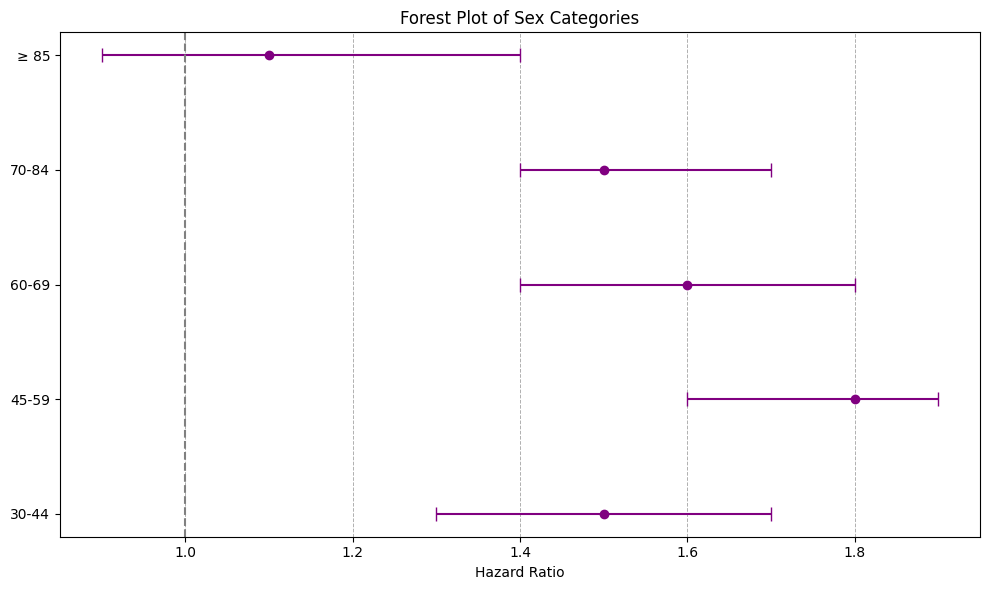

In [17]:
# Data preparation for Sex plot
categories_sex = [
    ("Male", [1.5, 1.8, 1.6, 1.5, 1.1], [1.3, 1.6, 1.4, 1.4, 0.9], [1.7, 1.9, 1.8, 1.7, 1.4])
]

fig, ax = plt.subplots(figsize=(10, 6))

# Plot data for Sex with purple color
hr_sex = [item[1] for item in categories_sex][0]
lower_ci_sex = [item[2] for item in categories_sex][0]
upper_ci_sex = [item[3] for item in categories_sex][0]
positions_sex = np.arange(len(hr_sex))
for idx in range(len(hr_sex)):
    ax.errorbar(hr_sex[idx], positions_sex[idx], xerr=[[hr_sex[idx] - lower_ci_sex[idx]], [upper_ci_sex[idx] - hr_sex[idx]]], fmt='o', color='purple', capsize=5)
ax.axvline(1, color='grey', linestyle='--')
ax.set_yticks(np.arange(len(hr_sex)))
ax.set_yticklabels(["30-44", "45-59", "60-69", "70-84", "≥ 85"])
ax.set_xlabel("Hazard Ratio")
ax.set_title("Forest Plot of Sex Categories")
ax.grid(True, axis='x', linestyle='--', linewidth=0.7)

plt.tight_layout()

# Save and display the plot
# plt.savefig("/mnt/data/forest_plot_sex.png")
plt.show()


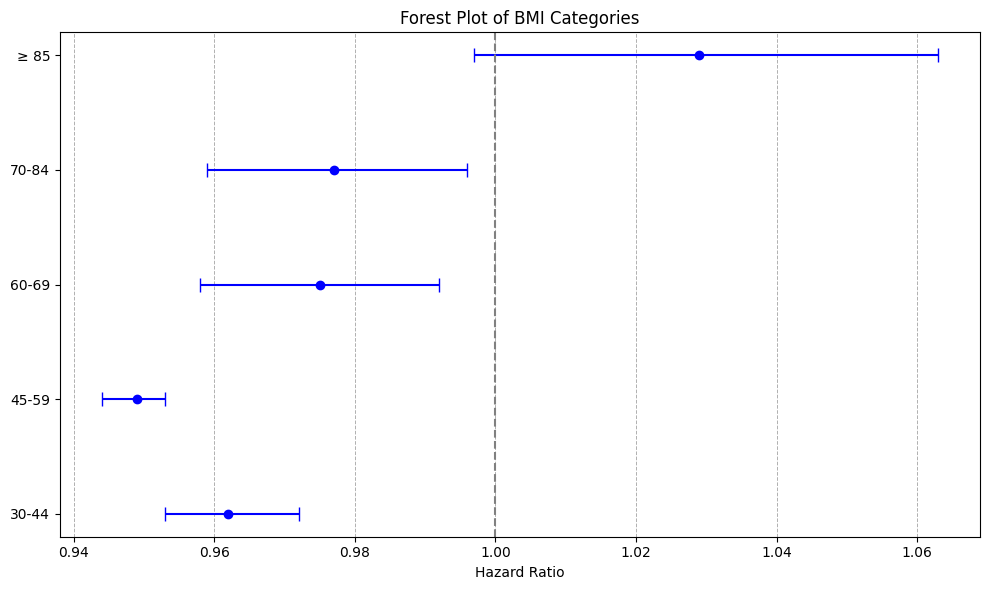

In [19]:
# Data preparation for BMI plot
categories_bmi = [
    ("BMI", [0.962, 0.949, 0.975, 0.977, 1.029], [0.953, 0.944, 0.958, 0.959, 0.997], [0.972, 0.953, 0.992, 0.996, 1.063])
]

fig, ax = plt.subplots(figsize=(10, 6))

# Plot data for BMI with blue color
hr_bmi = [item[1] for item in categories_bmi][0]
lower_ci_bmi = [item[2] for item in categories_bmi][0]
upper_ci_bmi = [item[3] for item in categories_bmi][0]
positions_bmi = np.arange(len(hr_bmi))
for idx in range(len(hr_bmi)):
    ax.errorbar(hr_bmi[idx], positions_bmi[idx], xerr=[[hr_bmi[idx] - lower_ci_bmi[idx]], [upper_ci_bmi[idx] - hr_bmi[idx]]], fmt='o', color='blue', capsize=5)
ax.axvline(1, color='grey', linestyle='--')
ax.set_yticks(np.arange(len(hr_bmi)))
ax.set_yticklabels(["30-44", "45-59", "60-69", "70-84", "≥ 85"])
ax.set_xlabel("Hazard Ratio")
ax.set_title("Forest Plot of BMI Categories")
ax.grid(True, axis='x', linestyle='--', linewidth=0.7)

plt.tight_layout()

# Save and display the plot
# plt.savefig("/mnt/data/forest_plot_bmi.png")
plt.show()


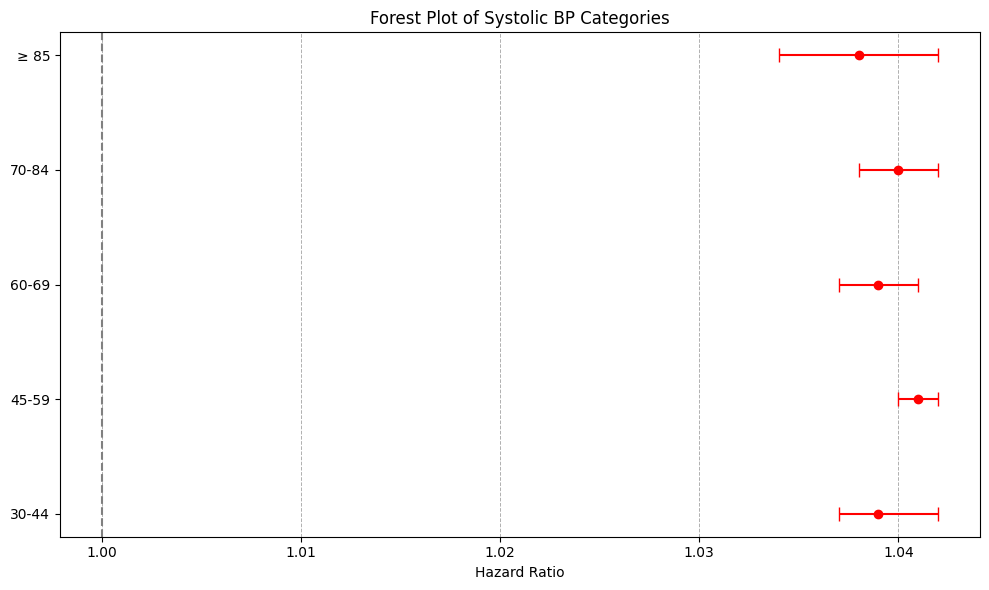

In [21]:
# Data preparation for Systolic BP plot
categories_bp = [
    ("Systolic BP", [1.039, 1.041, 1.039, 1.040, 1.038], [1.037, 1.040, 1.037, 1.038, 1.034], [1.042, 1.042, 1.041, 1.042, 1.042])
]

fig, ax = plt.subplots(figsize=(10, 6))

# Plot data for Systolic BP with red color
hr_bp = [item[1] for item in categories_bp][0]
lower_ci_bp = [item[2] for item in categories_bp][0]
upper_ci_bp = [item[3] for item in categories_bp][0]
positions_bp = np.arange(len(hr_bp))
for idx in range(len(hr_bp)):
    ax.errorbar(hr_bp[idx], positions_bp[idx], xerr=[[hr_bp[idx] - lower_ci_bp[idx]], [upper_ci_bp[idx] - hr_bp[idx]]], fmt='o', color='red', capsize=5)
ax.axvline(1, color='grey', linestyle='--')
ax.set_yticks(np.arange(len(hr_bp)))
ax.set_yticklabels(["30-44", "45-59", "60-69", "70-84", "≥ 85"])
ax.set_xlabel("Hazard Ratio")
ax.set_title("Forest Plot of Systolic BP Categories")
ax.grid(True, axis='x', linestyle='--', linewidth=0.7)

plt.tight_layout()

# Save and display the plot
# plt.savefig("/mnt/data/forest_plot_sbp.png")
plt.show()


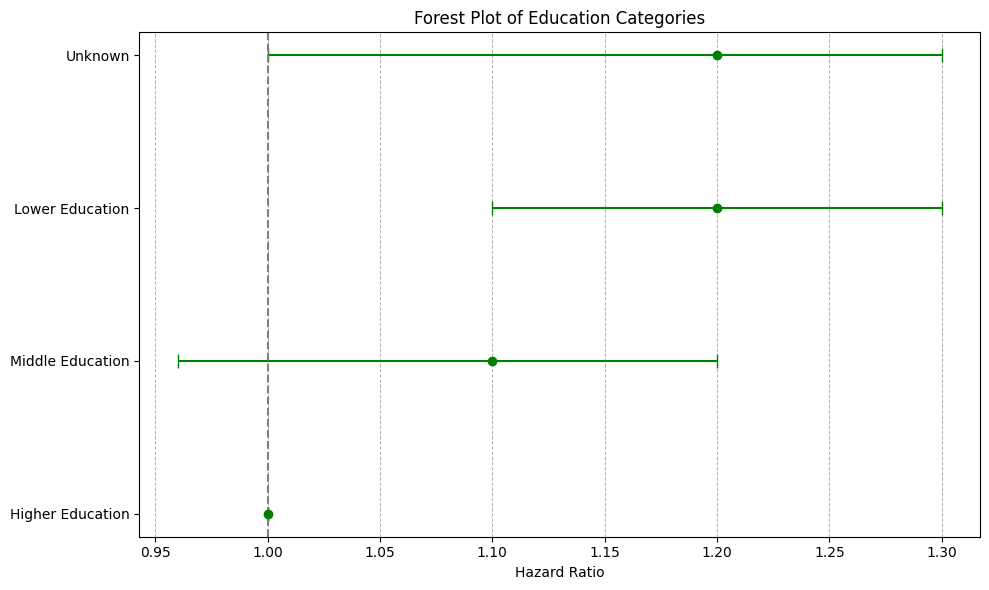

In [15]:
# Plot data for Education with green color
fig, ax = plt.subplots(figsize=(10, 6))

hr_education = [item[1][0] for item in categories_education]
lower_ci_education = [item[2][0] for item in categories_education]
upper_ci_education = [item[3][0] for item in categories_education]
positions_education = np.arange(len(hr_education))
for idx in range(len(hr_education)):
    ax.errorbar(hr_education[idx], positions_education[idx], xerr=[[hr_education[idx] - lower_ci_education[idx]], [upper_ci_education[idx] - hr_education[idx]]], fmt='o', color='green', capsize=5)
ax.axvline(1, color='grey', linestyle='--')
ax.set_yticks(np.arange(len(hr_education)))
ax.set_yticklabels(["Higher Education", "Middle Education", "Lower Education", "Unknown"])
ax.set_xlabel("Hazard Ratio")
ax.set_title("Forest Plot of Education Categories")
ax.grid(True, axis='x', linestyle='--', linewidth=0.7)

plt.tight_layout()

# Save and display the plot
# plt.savefig("/mnt/data/forest_plot_education.png")
plt.show()


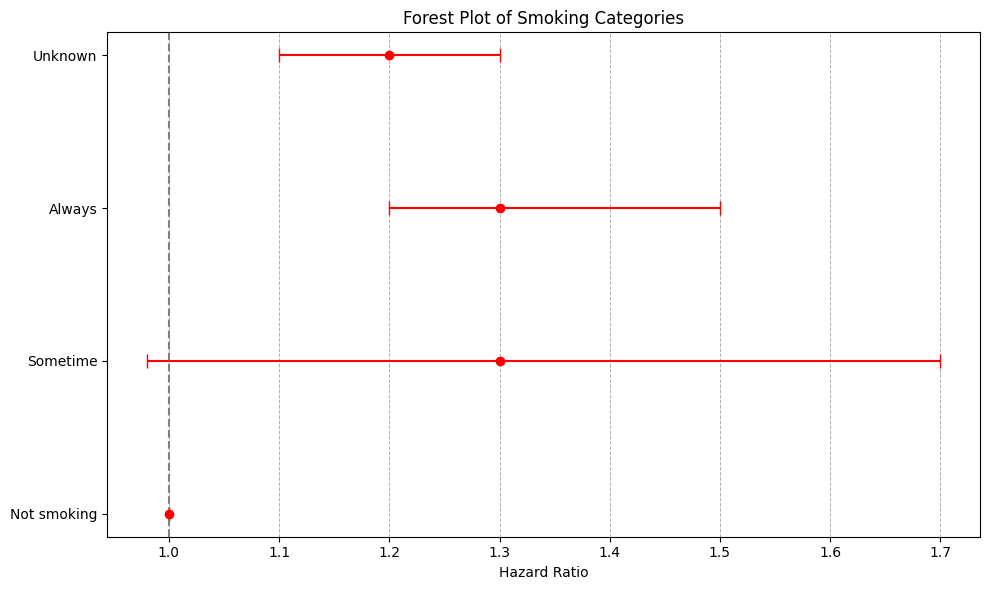

In [14]:
# Plot data for Smoking with red color
fig, ax = plt.subplots(figsize=(10, 6))

hr_smoking = [item[1][0] for item in categories_smoking]
lower_ci_smoking = [item[2][0] for item in categories_smoking]
upper_ci_smoking = [item[3][0] for item in categories_smoking]
positions_smoking = np.arange(len(hr_smoking))
for idx in range(len(hr_smoking)):
    ax.errorbar(hr_smoking[idx], positions_smoking[idx], xerr=[[hr_smoking[idx] - lower_ci_smoking[idx]], [upper_ci_smoking[idx] - hr_smoking[idx]]], fmt='o', color='red', capsize=5)
ax.axvline(1, color='grey', linestyle='--')
ax.set_yticks(np.arange(len(hr_smoking)))
ax.set_yticklabels(["Not smoking", "Sometime", "Always", "Unknown"])
ax.set_xlabel("Hazard Ratio")
ax.set_title("Forest Plot of Smoking Categories")
ax.grid(True, axis='x', linestyle='--', linewidth=0.7)

plt.tight_layout()

# Save and display the plot
# plt.savefig("/mnt/data/forest_plot_smoking.png")
plt.show()


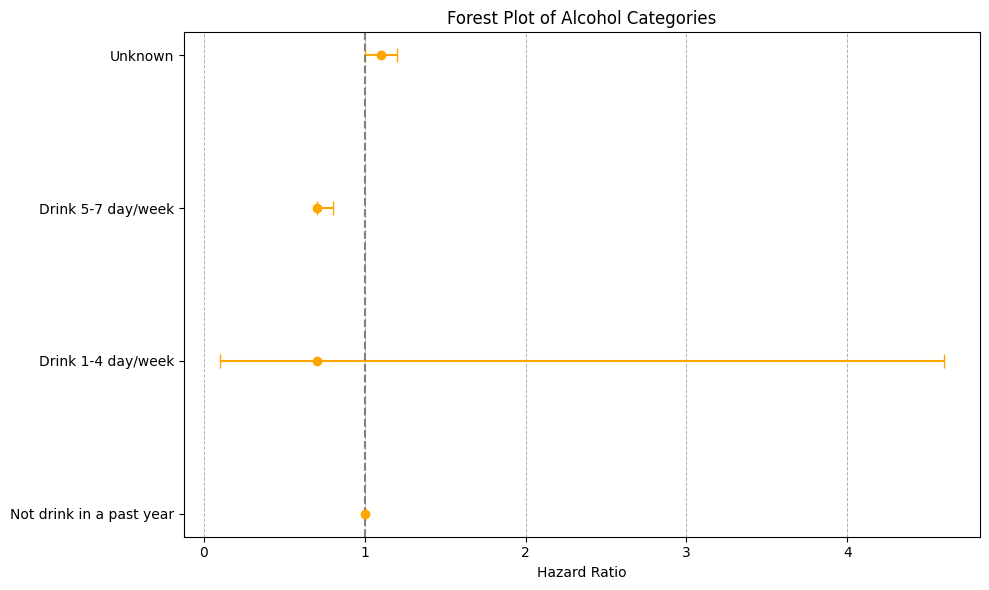

In [12]:
categories_alcohol = [
    ("Not drink in a past year", [1.0], [1.0], [1.0]),
    ("Drink 1-4 day/week", [0.7], [0.1], [4.6]),
    ("Drink 5-7 day/week", [0.7], [0.7], [0.8]),
    ("Unknown", [1.1], [1.0], [1.2])
]

# Plot data for Alcohol with orange color
fig, ax = plt.subplots(figsize=(10, 6))

hr_alcohol = [item[1][0] for item in categories_alcohol]
lower_ci_alcohol = [item[2][0] for item in categories_alcohol]
upper_ci_alcohol = [item[3][0] for item in categories_alcohol]
positions_alcohol = np.arange(len(hr_alcohol))
for idx in range(len(hr_alcohol)):
    ax.errorbar(hr_alcohol[idx], positions_alcohol[idx], xerr=[[hr_alcohol[idx] - lower_ci_alcohol[idx]], [upper_ci_alcohol[idx] - hr_alcohol[idx]]], fmt='o', color='orange', capsize=5)
ax.axvline(1, color='grey', linestyle='--')
ax.set_yticks(np.arange(len(hr_alcohol)))
ax.set_yticklabels(["Not drink in a past year", "Drink 1-4 day/week", "Drink 5-7 day/week", "Unknown"])
ax.set_xlabel("Hazard Ratio")
ax.set_title("Forest Plot of Alcohol Categories")
ax.grid(True, axis='x', linestyle='--', linewidth=0.7)

plt.tight_layout()

# Save and display the plot
# plt.savefig("/mnt/data/forest_plot_alcohol.png")
plt.show()